## Deep Learning for extensive air showers reconstruction: an interpretable multi-task CNN-Transformer model for the CONDOR Observatory

This notebook mirrors the pipeline described in the paper. Multi-task CNN-Transformer for (1) gamma/hadron classification, (2) zenith angle reconstruction, (3) energy estimation.

### Contributions and Reference
- Joint multi-task learning for classification + regression (angle, energy).
- Hybrid sequence + global branch with attention.
- Physics-driven feature engineering and balanced splits.

Paper DOI: _Coming soon_

In [3]:
import os
import json
import pickle
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    mean_absolute_error,
    root_mean_squared_error,
    r2_score,
)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks, optimizers, Input, Model
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Optional

### Reproducibility and Environment
- Fixed seeds (numpy, random, tensorflow).
- GPU memory growth + mixed precision.
- Paths and artifact directories.

In [2]:
# ----------------------------- #
# Reproducibility configuration #
# ----------------------------- #
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

os.environ.setdefault("TF_GPU_ALLOCATOR", "cuda_malloc_async")
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass
if gpus:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

NameError: name 'np' is not defined

### Data Source and Physics Cuts
- Monte Carlo EAS simulations for CONDOR.
- Energy bands: 3E2, 5E2, 8E2; zenith ≤ 40°; min total particles ≥ 30.
- Cached pickle download if missing.

In [1]:
# ----------------------------- #
# Paths and pipeline parameters #
# ----------------------------- #
BASE_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction")
CACHE_FILE = BASE_DIR / "processed_all_data.pkl"

import gdown

# Download the processed_all_data.pkl file if it does not exist
if not CACHE_FILE.exists():
    url = "https://drive.google.com/uc?id=1Z6EqKXUzKrlxIYcbYg1bPfNkNhfP6Pgz"
    gdown.download(url, str(CACHE_FILE), quiet=False)

ARTIFACTS_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

ENERGY_FILTER = ("3E2", "5E2", "8E2")
ANGLE_MAX = 40.0
MIN_TOTAL_PARTICLES = 30

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15  # test will be 0.15 (remaining)
BATCH_SIZE = 32
EPOCHS = 100

sns.set_context("poster")
sns.set_style("ticks")

NameError: name 'Path' is not defined

In [ ]:
# ----------------------------- #
# Load from pickle              #
# ----------------------------- #
def load_dataset_from_cache(cache_path: Path) -> pd.DataFrame:
    if not cache_path.exists():
        raise FileNotFoundError(
            f"{cache_path} not found. Regenerate the pickle before running the pipeline."
        )
    with cache_path.open("rb") as fh:
        data = pickle.load(fh)
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    elif isinstance(data, dict):
        df = pd.DataFrame(data)
    else:
        raise ValueError("Unsupported cache format.")
    required_cols = {"shower_data", "angle", "label", "energy", "total_particles", "max_time"}
    if not required_cols.issubset(df.columns):
        raise ValueError("The pickle does not contain all required columns.")
    return df.reset_index(drop=True)

df_full = load_dataset_from_cache(CACHE_FILE)

df_full = df_full[
    (df_full["energy"].isin(ENERGY_FILTER)) &
    (df_full["angle"] <= ANGLE_MAX) &
    (df_full["total_particles"] >= MIN_TOTAL_PARTICLES)
].reset_index(drop=True)
if df_full.empty:
    raise RuntimeError("No events found after filtering by energy / angle / particles.")
df_full["idx"] = df_full.index

In [8]:
df_full.head()

shower_data  angle  label energy  \
0  [[34.0, 0.0, 1.0, -10.521292, -0.18196964, -12...    0.0      1    3E2   
1  [[72.0, 0.0, 1.0, 23.91233, -21.620737, 21.25,...    0.0      1    3E2   
2  [[52.0, 0.0, 3.0, 5.457006, -21.212957, 4.25, ...    0.0      1    3E2   
3  [[46.0, 0.0, 1.0, -3.1485364, 15.506375, -4.25...    0.0      1    3E2   
4  [[64.0, 0.0, 2.0, 10.033819, -3.3683705, 12.75...    0.0      1    3E2   

   total_particles  max_time  idx  
0               31        28    0  
1               92        49    1  
2              154        77    2  
3              109       104    3  
4               48        74    4

### Description of CONDOR Dataset Variables

Below are the variables used in this notebook, originating from simulated extensive air showers (EAS) under the CONDOR observatory conditions. These variables are divided into sequence features (individual hits), global event features, and target variables.

| Variable | Description |
|:---|:---|
| **`shower_data`** | Raw sequence of hits recorded by the detectors. This is the main input for the convolutional/recurrent branch. |
| `detector_id` | Unique identifier of the detector that registered the signal. |
| `x_center`, `y_center` | Spatial coordinates (in meters) of the center of the activated detector. |
| `t_bin` | Discretized time bin when the signal was recorded in the detector. |
| `particle_count` | Number of secondary particles detected in the detector at that instant. |
| `total_energy` (hit) | Energy deposited in the specific detector during the hit. |
| **`total_particles`** | Total sum of particles detected across the entire array (global feature). |
| **`active_detectors`** | Number of unique detectors activated during the event (global feature). |
| **`max_time / duration`** | Total temporal duration of the event in the array (global feature). |
| **`energy_central`** | Accumulated energy specifically in the 16 central detectors of the array (global feature). |
| **`label`** | Classification label: Type of primary particle (Photon $\gamma$ vs Proton/Hadron). |
| **`angle`** | Zenith angle of the incoming primary particle (in degrees). Regression target variable. |
| **`energy`** | Energy of the primary particle (in GeV). Regression target variable (e.g., 300, 500, 800 GeV). |

> **Note:** Sequence variables (`detector_id`, `t_bin`, etc.) are processed as time series, while global variables (`total_particles`, etc.) are injected directly into the dense layers of the hybrid model.

### Detector Geometry Reconstruction
- Map detector_id → (x_center, y_center).
- Save catalog for spatial features.

In [9]:
# ----------------------------- #
# Catálogo de detectores        #
# ----------------------------- #
def build_detector_catalog(df: pd.DataFrame) -> pd.DataFrame:
    positions = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            continue
        positions.append(arr[:, [0, 5, 6]])  # detector_id, x_center, y_center
    if not positions:
        return pd.DataFrame(columns=["detector_id", "x_center", "y_center"])
    catalog = (
        pd.DataFrame(np.vstack(positions), columns=["detector_id", "x_center", "y_center"])
        .drop_duplicates(subset=["detector_id"])
        .sort_values("detector_id")
        .reset_index(drop=True)
    )
    catalog["detector_id"] = catalog["detector_id"].astype(int)
    return catalog

detector_catalog = build_detector_catalog(df_full)
detector_catalog.to_csv(ARTIFACTS_DIR / "detector_catalog.csv", index=False)

In [10]:
detector_catalog

detector_id   x_center  y_center
0              0 -38.250000    -40.50
1              1 -38.250000    -31.50
2              2 -38.250000    -22.50
3              3 -38.250000    -13.50
4              4 -38.250000     -4.50
..           ...        ...       ...
115          115  50.400002    -13.50
116          116  50.400002     13.50
117          117  50.400002     40.50
118          118  50.400002    -53.75
119          119  50.400002     53.75

[120 rows x 3 columns]

### Balancing Strategy
- Undersample/oversample by (label, angle, energy) to remove spectral/geom biases.
- Target = median group size.

In [ ]:
def balance_by_group(df: pd.DataFrame, group_cols, random_state: int) -> tuple[pd.DataFrame, int]:
    counts = df.groupby(list(group_cols)).size()
    counts = counts[counts > 0]
    if counts.empty:
        raise RuntimeError("No groups available for balancing.")
    target = int(counts.median())
    balanced_parts = []
    for _, group in df.groupby(list(group_cols)):
        replace = len(group) < target
        balanced_parts.append(group.sample(n=target, replace=replace, random_state=random_state))
    balanced_df = pd.concat(balanced_parts, ignore_index=True)
    balanced_df = balanced_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return balanced_df, target

df_balanced, target_per_group = balance_by_group(
    df_full,
    group_cols=("label", "angle", "energy"),
    random_state=SEED,
)

### Distribution Checks
- Histograms for label, angle, energy (pre/post balance).
- Cross-table summaries.

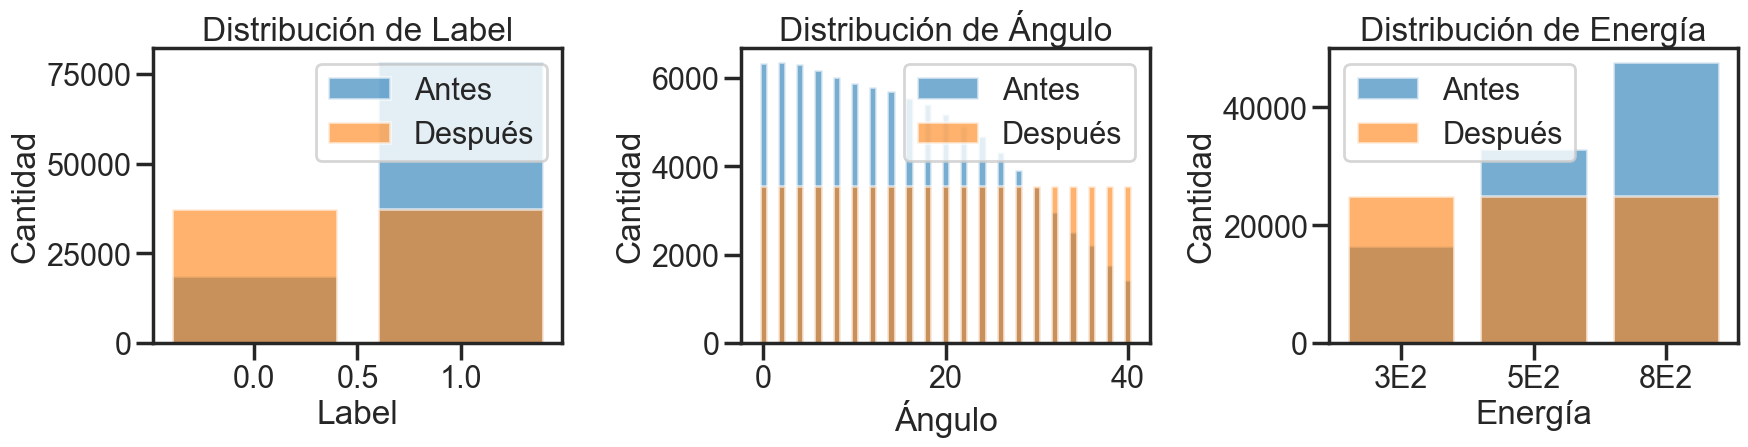

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Before balancing
df_full_counts = {
    "label": df_full["label"].value_counts().sort_index(),
    "angle": df_full["angle"].value_counts().sort_index(),
    "energy": df_full["energy"].value_counts().sort_index(),
}

# After balancing
df_balanced_counts = {
    "label": df_balanced["label"].value_counts().sort_index(),
    "angle": df_balanced["angle"].value_counts().sort_index(),
    "energy": df_balanced["energy"].value_counts().sort_index(),
}

features = ["label", "angle", "energy"]
titles = ["Label", "Angle", "Energy"]

for i, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[i]
    ax.bar(df_full_counts[feature].index, df_full_counts[feature].values, alpha=0.6, label="Before")
    ax.bar(df_balanced_counts[feature].index, df_balanced_counts[feature].values, alpha=0.6, label="After")
    ax.set_title(f"{title} Distribution")
    ax.set_xlabel(title)
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

In [13]:
def resumen_balanceo(df_pre, df_post):
    label_map = {0: "Photon", 1: "Proton"}
    def agregar_tabla(df, nombre):
        tabla = (
            df.assign(label=df["label"].map(label_map))
            .groupby(["energy", "label", "angle"])
            .size()
            .unstack("angle", fill_value=0)
        )
        tabla["Total"] = tabla.sum(axis=1)
        tabla["Set"] = nombre
        return tabla.reset_index()
    tabla_pre = agregar_tabla(df_pre, "Antes")
    tabla_post = agregar_tabla(df_post, "Después")
    tabla_final = pd.concat([tabla_pre, tabla_post], ignore_index=True)
    display(tabla_final)

resumen_balanceo(df_full, df_balanced)


angle energy   label   0.0   2.0   4.0   6.0   8.0  10.0  12.0  14.0  ...  \
0        3E2  Photon   179   168   150   154   112   129   130   143  ...   
1        3E2  Proton  1174  1136  1118  1071  1087  1045   979   935  ...   
2        5E2  Photon   449   369   344   371   316   307   261   310  ...   
3        5E2  Proton  1844  1845  1843  1812  1807  1785  1752  1683  ...   
4        8E2  Photon   706   847   866   796   713   627   690   651  ...   
5        8E2  Proton  1987  1988  1991  1986  1994  1986  1980  1979  ...   
6        3E2  Photon   593   593   593   593   593   593   593   593  ...   
7        3E2  Proton   593   593   593   593   593   593   593   593  ...   
8        5E2  Photon   593   593   593   593   593   593   593   593  ...   
9        5E2  Proton   593   593   593   593   593   593   593   593  ...   
10       8E2  Photon   593   593   593   593   593   593   593   593  ...   
11       8E2  Proton   593   593   593   593   593   593   593   593  ...   

angle  26.0  28.0  30.0  32.0  34.0  36.0  38.0  40.0  Total      Set  
0        78    63    64    38    36    30    31    19   1958    Antes  
1       513   415   364   287   223   197   124    90  14474    Antes  
2       233   229   153   161   103   116   101    85   5306    Antes  
3      1226  1075   961   721   634   526   399   287  27611    Antes  
4       460   394   356   332   242   249   216   214  11496    Antes  
5      1810  1740  1636  1425  1278  1091   895   725  36143    Antes  
6       593   593   593   593   593   593   593   593  12453  Después  
7       593   593   593   593   593   593   593   593  12453  Después  
8       593   593   593   593   593   593   593   593  12453  Después  
9       593   593   593   593   593   593   593   593  12453  Después  
10      593   593   593   593   593   593   593   593  12453  Después  
11      593   593   593   593   593   593   593   593  12453  Después  

[12 rows x 25 columns]

### Sequence Features
- Time-ordered hits: detector_id, particle_count, t_bin, total_energy, x_center, y_center.
- Sorted by t_bin; padded sequences.

In [14]:
# ----------------------------- #
# Construcción de secuencias    #
# ----------------------------- #
FEATURE_ORDER = [0, 2, 1, 7, 5, 6]  # detector_id, particle_count, t_bin, total_energy, x_center, y_center
FEATURE_NAMES = ["detector_id", "particle_count", "t_bin", "total_energy", "x_center", "y_center"]

def build_sequence_list(df: pd.DataFrame) -> list[np.ndarray]:
    sequences = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            sequences.append(np.zeros((0, len(FEATURE_ORDER)), dtype=np.float32))
            continue
        order = np.argsort(arr[:, 1])  # t_bin
        ordered = arr[order][:, FEATURE_ORDER].astype(np.float32)
        sequences.append(ordered)
    return sequences

X_sequences = build_sequence_list(df_balanced)
angles = df_balanced["angle"].to_numpy(dtype=np.float32)
labels = df_balanced["label"].to_numpy(dtype=np.int32)
energies = df_balanced["energy"].to_numpy()

### Global Features
- Total particles, total energy, active detectors, duration, central energy (inner detectors).
- Central IDs: 16 central detectors.

In [15]:
# ----------------------------- #
# Features globales             #
# ----------------------------- #
detector_catalog["distance"] = np.hypot(detector_catalog["x_center"], detector_catalog["y_center"])
central_ids = detector_catalog.nsmallest(16, "distance")["detector_id"].astype(int).tolist()

def compute_global_features(sequences: list[np.ndarray], central_detectors: list[int]) -> np.ndarray:
    central_detectors = np.array(central_detectors, dtype=np.int32)
    features = np.zeros((len(sequences), 5), dtype=np.float32)
    for idx, seq in enumerate(sequences):
        if seq.size == 0:
            continue
        det_ids = seq[:, 0].astype(np.int32)
        particle_counts = seq[:, 1]
        t_bins = seq[:, 2]
        tot_energy = seq[:, 3]

        total_particles = float(particle_counts.sum())
        total_energy = float(tot_energy.sum())
        active_detectors = float(np.unique(det_ids).size)
        duration = float(t_bins.max() - t_bins.min())
        mask_central = np.isin(det_ids, central_detectors)
        energy_central = float(tot_energy[mask_central].sum()) if np.any(mask_central) else 0.0

        features[idx] = [
            total_particles,
            total_energy,
            active_detectors,
            duration,
            energy_central,
        ]
    return features

X_global = compute_global_features(X_sequences, central_ids)
X_padded = pad_sequences(X_sequences, padding="post", dtype="float32")
max_sequence_length = int(X_padded.shape[1])

### Stratified Split
- 70/15/15 stratified on (angle, label).
- Energy both categorical (bins) and continuous (scaled).
- Record means/std for scaling.

In [16]:
# ----------------------------- #
# Splits estratificados         #
# ----------------------------- #
indices = np.arange(len(X_padded))
strata = np.array([f"{int(round(a))}_{lbl}" for a, lbl in zip(angles, labels)])

train_idx, temp_idx = train_test_split(
    indices,
    test_size=1.0 - TRAIN_RATIO,
    stratify=strata,
    random_state=SEED,
    shuffle=True,
)

val_fraction = VAL_RATIO / (1.0 - TRAIN_RATIO)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=1.0 - val_fraction,
    stratify=strata[temp_idx],
    random_state=SEED,
    shuffle=True,
)

def split_arrays(arr: np.ndarray, tr: np.ndarray, va: np.ndarray, te: np.ndarray):
    return arr[tr], arr[va], arr[te]

X_train, X_val, X_test = split_arrays(X_padded, train_idx, val_idx, test_idx)
Xg_train, Xg_val, Xg_test = split_arrays(X_global, train_idx, val_idx, test_idx)
y_angle_train, y_angle_val, y_angle_test = split_arrays(angles, train_idx, val_idx, test_idx)
y_label_train, y_label_val, y_label_test = split_arrays(labels, train_idx, val_idx, test_idx)
y_energy_train, y_energy_val, y_energy_test = split_arrays(energies, train_idx, val_idx, test_idx)

energy_levels = sorted({e for e in df_balanced["energy"]}, key=lambda x: float(x.replace("E", "e")))
energy_to_idx = {e: idx for idx, e in enumerate(energy_levels)}
y_energy_train_cls = np.array([energy_to_idx[e] for e in y_energy_train], dtype=np.int32)
y_energy_val_cls = np.array([energy_to_idx[e] for e in y_energy_val], dtype=np.int32)
y_energy_test_cls = np.array([energy_to_idx[e] for e in y_energy_test], dtype=np.int32)

def parse_energy(arr: np.ndarray) -> np.ndarray:
    return np.array([float(s.replace("E", "e")) for s in arr], dtype=np.float32)

y_energy_train_cont = parse_energy(y_energy_train)
y_energy_val_cont = parse_energy(y_energy_val)
y_energy_test_cont = parse_energy(y_energy_test)

energy_mean = float(y_energy_train_cont.mean())
energy_std = float(y_energy_train_cont.std(ddof=0) + 1e-8)
y_energy_train_scaled = (y_energy_train_cont - energy_mean) / energy_std
y_energy_val_scaled = (y_energy_val_cont - energy_mean) / energy_std
y_energy_test_scaled = (y_energy_test_cont - energy_mean) / energy_std

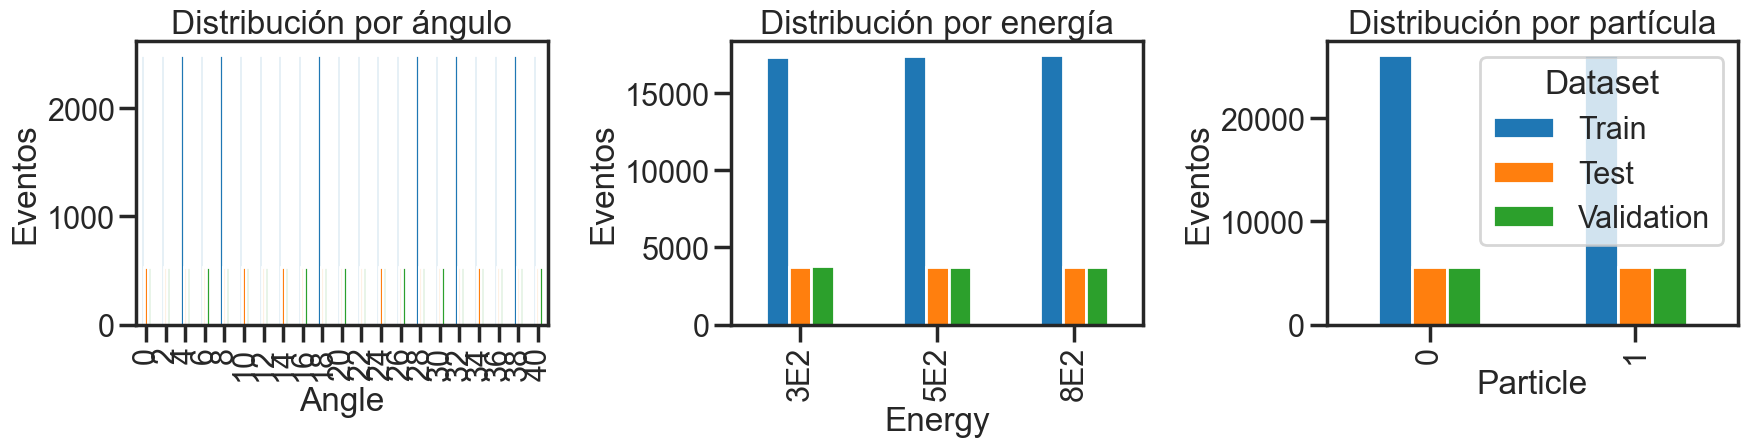

In [17]:
datasets = [
    ("Train", y_angle_train, y_energy_train, y_label_train),
    ("Validation", y_angle_val, y_energy_val, y_label_val),
    ("Test", y_angle_test, y_energy_test, y_label_test),
]

frames = []
for name, angle_arr, energy_arr, particle_arr in datasets:
    frames.append(
        pd.DataFrame(
            {
                "dataset": name,
                "angle": angle_arr.astype(int),
                "energy": energy_arr,
                "particle": particle_arr.astype(int),
            }
        )
    )

dist_df = pd.concat(frames, ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plots = [
    ("angle", "Distribución por ángulo"),
    ("energy", "Distribución por energía"),
    ("particle", "Distribución por partícula"),
]

order = ["Train", "Test", "Validation"]

for i, (ax, (feature, title)) in enumerate(zip(axes, plots)):
    counts = (
        dist_df.groupby(["dataset", feature])
        .size()
        .unstack("dataset", fill_value=0)
        .sort_index()
    )
    counts = counts[order]  # Reordenar columnas
    counts.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Eventos")
    if i == 2:
        ax.legend(title="Dataset")
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

In [18]:
# Crear una lista con los nombres de los sets
sets = ["Train", "Validation", "Test"]

# Crear una lista con las combinaciones energía-tipo
energy_types = []
for energy in energy_levels:
    for label in [0, 1]:
        tipo = "Photon" if label == 0 else "Proton"
        energy_types.append(f"{energy}-{tipo}")

# Inicializar el diccionario de conteos
table_dict = {set_name: [] for set_name in sets}
totals = []

for set_name, angle_arr, energy_arr, label_arr in datasets:
    row = []
    for energy in energy_levels:
        for label in [0, 1]:
            count = ((energy_arr == energy) & (label_arr == label)).sum()
            row.append(count)
    total = sum(row)
    table_dict[set_name] = row + [total]
    totals.append(total)

# Construir el DataFrame
columns = energy_types + ["Total"]
tabla = pd.DataFrame([table_dict[set_name] for set_name in sets], columns=columns, index=sets)
display(tabla)

3E2-Photon  3E2-Proton  5E2-Photon  5E2-Proton  8E2-Photon  \
Train             8678        8684        8728        8718        8745   
Validation        1892        1894        1838        1875        1872   
Test              1883        1875        1887        1860        1836   

            8E2-Proton  Total  
Train             8749  52302  
Validation        1836  11207  
Test              1868  11209

### Hybrid CNN-Transformer with Multi-Task Heads
- Sequence branch: Conv1D stack → Transformer blocks (per head tap).
- Global branch: dense layers.
- Heads: particle (sigmoid), angle (linear), energy (linear, scaled).
- Attention taps for interpretability.

In [19]:
model_dir = ARTIFACTS_DIR / "model"
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / "condor_multitask_model.keras"

In [33]:
from tensorflow.keras.metrics import Metric

# ----------------------------- #
# Definición del modelo         #
# ----------------------------- #
def build_multitask_model(sequence_shape: tuple[int, int], global_dim: int, include_attention_outputs: bool = False) -> Model:
    seq_input = Input(shape=sequence_shape, name="seq_input")
    global_input = Input(shape=(global_dim,), name="global_input")

    # Secuencia enmascarada (raw)
    x_raw = layers.Masking(mask_value=0.0, name="masking")(seq_input)

    # Rama CNN (igual que antes, operando sobre raw)
    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_0")(x_raw)
    x_cnn = layers.BatchNormalization(name="bn_0")(x_cnn)
    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_1")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_1")(x_cnn)
    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_2")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_2")(x_cnn)
    x_cnn = layers.MaxPooling1D(pool_size=2, padding="same", name="pool_2")(x_cnn)
    x_cnn = layers.Dense(128, activation="elu", name="dense_after_cnn1")(x_cnn)
    x_cnn = layers.Dense(256, activation="elu", name="dense_after_cnn2")(x_cnn)
    x_cnn = layers.Dropout(0.40, name="dropout_after_cnn")(x_cnn)
    x_cnn = layers.Dense(128, activation="elu", name="dense_after_cnn4")(x_cnn)

    attention_recorders = []
    attention_tap_names = {}

    def transformer_block(x: tf.Tensor, prefix: str) -> tuple[tf.Tensor, tf.Tensor]:
        x_norm = layers.LayerNormalization(name=f"pre_mha_norm_{prefix}")(x)
        mha_layer = layers.MultiHeadAttention(num_heads=1, key_dim=32, name=f"mha_{prefix}")
        attn_output, attn_scores = mha_layer(x_norm, x_norm, return_attention_scores=True)
        recorder = layers.Lambda(lambda s: s, name=f"attention_scores_{prefix}")(attn_scores)
        attention_tap_names[prefix] = recorder.name
        attention_recorders.append(recorder)
        x_add = layers.Add(name=f"add_{prefix}")([x, attn_output])
        x_norm_ffn = layers.LayerNormalization(name=f"pre_ffn_norm_{prefix}")(x_add)
        ffn = layers.Dense(128, activation="elu", name=f"ffn_dense_{prefix}1")(x_norm_ffn)
        ffn = layers.Dense(x.shape[-1], name=f"ffn_dense_{prefix}2")(ffn)
        x_out = layers.Add(name=f"ffn_add_{prefix}")([x_add, ffn])
        pooled = layers.GlobalAveragePooling1D(name=f"temporal_pooling_{prefix}")(x_out)
        return pooled, recorder

    # Transformers sobre la salida CNN
    feat_angle_cnn, attn_angle_cnn = transformer_block(x_cnn, "angle_cnn")
    feat_particle_cnn, attn_class_cnn = transformer_block(x_cnn, "class_cnn")
    feat_energy_cnn, attn_energy_cnn = transformer_block(x_cnn, "energy_cnn")

    # Transformers sobre la secuencia raw (sin convolución)
    feat_angle_raw, attn_angle_raw = transformer_block(x_raw, "angle_raw")
    feat_particle_raw, attn_class_raw = transformer_block(x_raw, "class_raw")
    feat_energy_raw, attn_energy_raw = transformer_block(x_raw, "energy_raw")

    # Fusionar features de atención CNN + raw
    feat_angle = layers.Concatenate(name="feat_angle_fused")([feat_angle_cnn, feat_angle_raw])
    feat_particle = layers.Concatenate(name="feat_particle_fused")([feat_particle_cnn, feat_particle_raw])
    feat_energy = layers.Concatenate(name="feat_energy_fused")([feat_energy_cnn, feat_energy_raw])

    merged_angle = layers.Concatenate(name="merge_angle")([feat_angle, global_input])
    merged_particle = layers.Concatenate(name="merge_particle")([feat_particle, global_input])
    merged_energy = layers.Concatenate(name="merge_energy")([feat_energy, global_input])

    class_branch = layers.Dropout(0.35, name="dropout_particle")(merged_particle)
    class_branch = layers.Dense(128, activation="elu", name="dense_particle")(class_branch)
    particle_out = layers.Dense(1, activation="sigmoid", dtype="float32", name="particle_output")(class_branch)

    angle_branch = layers.Dense(128, activation="elu", name="dense_angle")(merged_angle)
    angle_out = layers.Dense(1, activation="linear", dtype="float32", name="angle_output")(angle_branch)

    energy_branch = layers.Dense(128, activation="elu", name="dense_energy")(merged_energy)
    energy_branch = layers.Dropout(0.50, name="dropout_energy")(energy_branch)
    energy_out = layers.Dense(1, activation="linear", dtype="float32", name="energy_output")(energy_branch)

    outputs = [particle_out, angle_out, energy_out]
    if include_attention_outputs:
        outputs.extend([
            attn_class_cnn, attn_angle_cnn, attn_energy_cnn,
            attn_class_raw, attn_angle_raw, attn_energy_raw,
        ])

    model = Model(inputs=[seq_input, global_input], outputs=outputs, name="CONDOR_Multitask")
    optimizer = optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

    model.attention_recorders = {
        logical: model.get_layer(layer_name)
        for logical, layer_name in attention_tap_names.items()
        if layer_name in [layer.name for layer in model.layers]
    }
    model.attention_layer_names = attention_tap_names

    class F1Score(Metric):
        def __init__(self, name="f1_score", threshold=0.5, **kwargs):
            super().__init__(name=name, **kwargs)
            self.threshold = threshold
            self.tp = self.add_weight(name="tp", initializer="zeros")
            self.fp = self.add_weight(name="fp", initializer="zeros")
            self.fn = self.add_weight(name="fn", initializer="zeros")

        def update_state(self, y_true, y_pred, sample_weight=None):
            y_pred = tf.cast(y_pred > self.threshold, tf.float32)
            y_true = tf.cast(y_true, tf.float32)
            tp = tf.reduce_sum(y_true * y_pred)
            fp = tf.reduce_sum((1 - y_true) * y_pred)
            fn = tf.reduce_sum(y_true * (1 - y_pred))
            self.tp.assign_add(tp)
            self.fp.assign_add(fp)
            self.fn.assign_add(fn)

        def result(self):
            precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
            recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
            return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        def reset_state(self):
            self.tp.assign(0)
            self.fp.assign(0)
            self.fn.assign(0)

    # Solo compilar con las primeras 3 salidas (predicciones)
    model.compile(
        optimizer=optimizer,
        loss={
            "particle_output": "binary_crossentropy",
            "angle_output": tf.keras.losses.Huber(),
            "energy_output": tf.keras.losses.Huber(),
        },
        loss_weights={
            "particle_output": 0.6,
            "angle_output": 1.0,
            "energy_output": 1.5,
        },
        metrics={
            "particle_output": [F1Score(name="f1_score")],
            "angle_output": "mae",
            "energy_output": "mae",
        },
    )
    return model

model = build_multitask_model(sequence_shape=(max_sequence_length, len(FEATURE_NAMES)), global_dim=Xg_train.shape[1])
model.summary()

Model: "CONDOR_Multitask"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 472, 6)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 472, 6)       0           ['seq_input[0][0]']              
                                                                                                  
 conv_0 (Conv1D)                (None, 472, 128)     5504        ['masking[0][0]']                
                                                                                                  
 bn_0 (BatchNormalization)      (None, 472, 128)     512         ['conv_0[0][0]']                 
                                                                                   

### Training Protocol
- Losses: BCE (particle), Huber (angle, energy).
- Loss weights: particle 0.6, angle 1.0, energy 1.5.
- Optimizer: Adam lr=5e-4, clipnorm=1.0.
- Callbacks: EarlyStopping, ReduceLROnPlateau.
- Mixed precision if GPU.

### Model Fitting and Persistence
- Train with stratified splits.
- Save model, history, attention map.
- Store artifacts under pipeline_artifacts/.

In [ ]:
# ----------------------------- #
# Entrenamiento                 #
# ----------------------------- #
callbacks_list = [
    callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, verbose=1, min_lr=1e-6),
]

history = model.fit(
    x=[X_train, Xg_train],
    y=[y_label_train, y_angle_train, y_energy_train_scaled],
    validation_data=([X_val, Xg_val], [y_label_val, y_angle_val, y_energy_val_scaled]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1,
)

model.save(model_path)
model.save_weights(model_dir / "condor_multitask.weights.h5")
print(f"Modelo guardado en: {model_path}")

Epoch 1/100
1635/1635 [==============================] - 189s 106ms/step - loss: 3.7108 - particle_output_loss: 0.4874 - angle_output_loss: 1.7314 - energy_output_loss: 1.1246 - particle_output_f1_score: 0.8047 - angle_output_mae: 2.1697 - energy_output_mae: 1.5281 - val_loss: 1.8583 - val_particle_output_loss: 0.3512 - val_angle_output_loss: 1.0450 - val_energy_output_loss: 0.4017 - val_particle_output_f1_score: 0.8819 - val_angle_output_mae: 1.4638 - val_energy_output_mae: 0.7759 - lr: 5.0000e-04
Epoch 2/100
1635/1635 [==============================] - 186s 114ms/step - loss: 1.8720 - particle_output_loss: 0.3142 - angle_output_loss: 1.0523 - energy_output_loss: 0.4208 - particle_output_f1_score: 0.8828 - angle_output_mae: 1.4700 - energy_output_mae: 0.7986 - val_loss: 1.9984 - val_particle_output_loss: 0.2634 - val_angle_output_loss: 1.2476 - val_energy_output_loss: 0.3952 - val_particle_output_f1_score: 0.9122 - val_angle_output_mae: 1.6810 - val_energy_output_mae: 0.7664 - lr: 5.0

### Training Curves
- Losses per head (train/val).
- Metrics: F1 (particle), MAE (angle, energy).

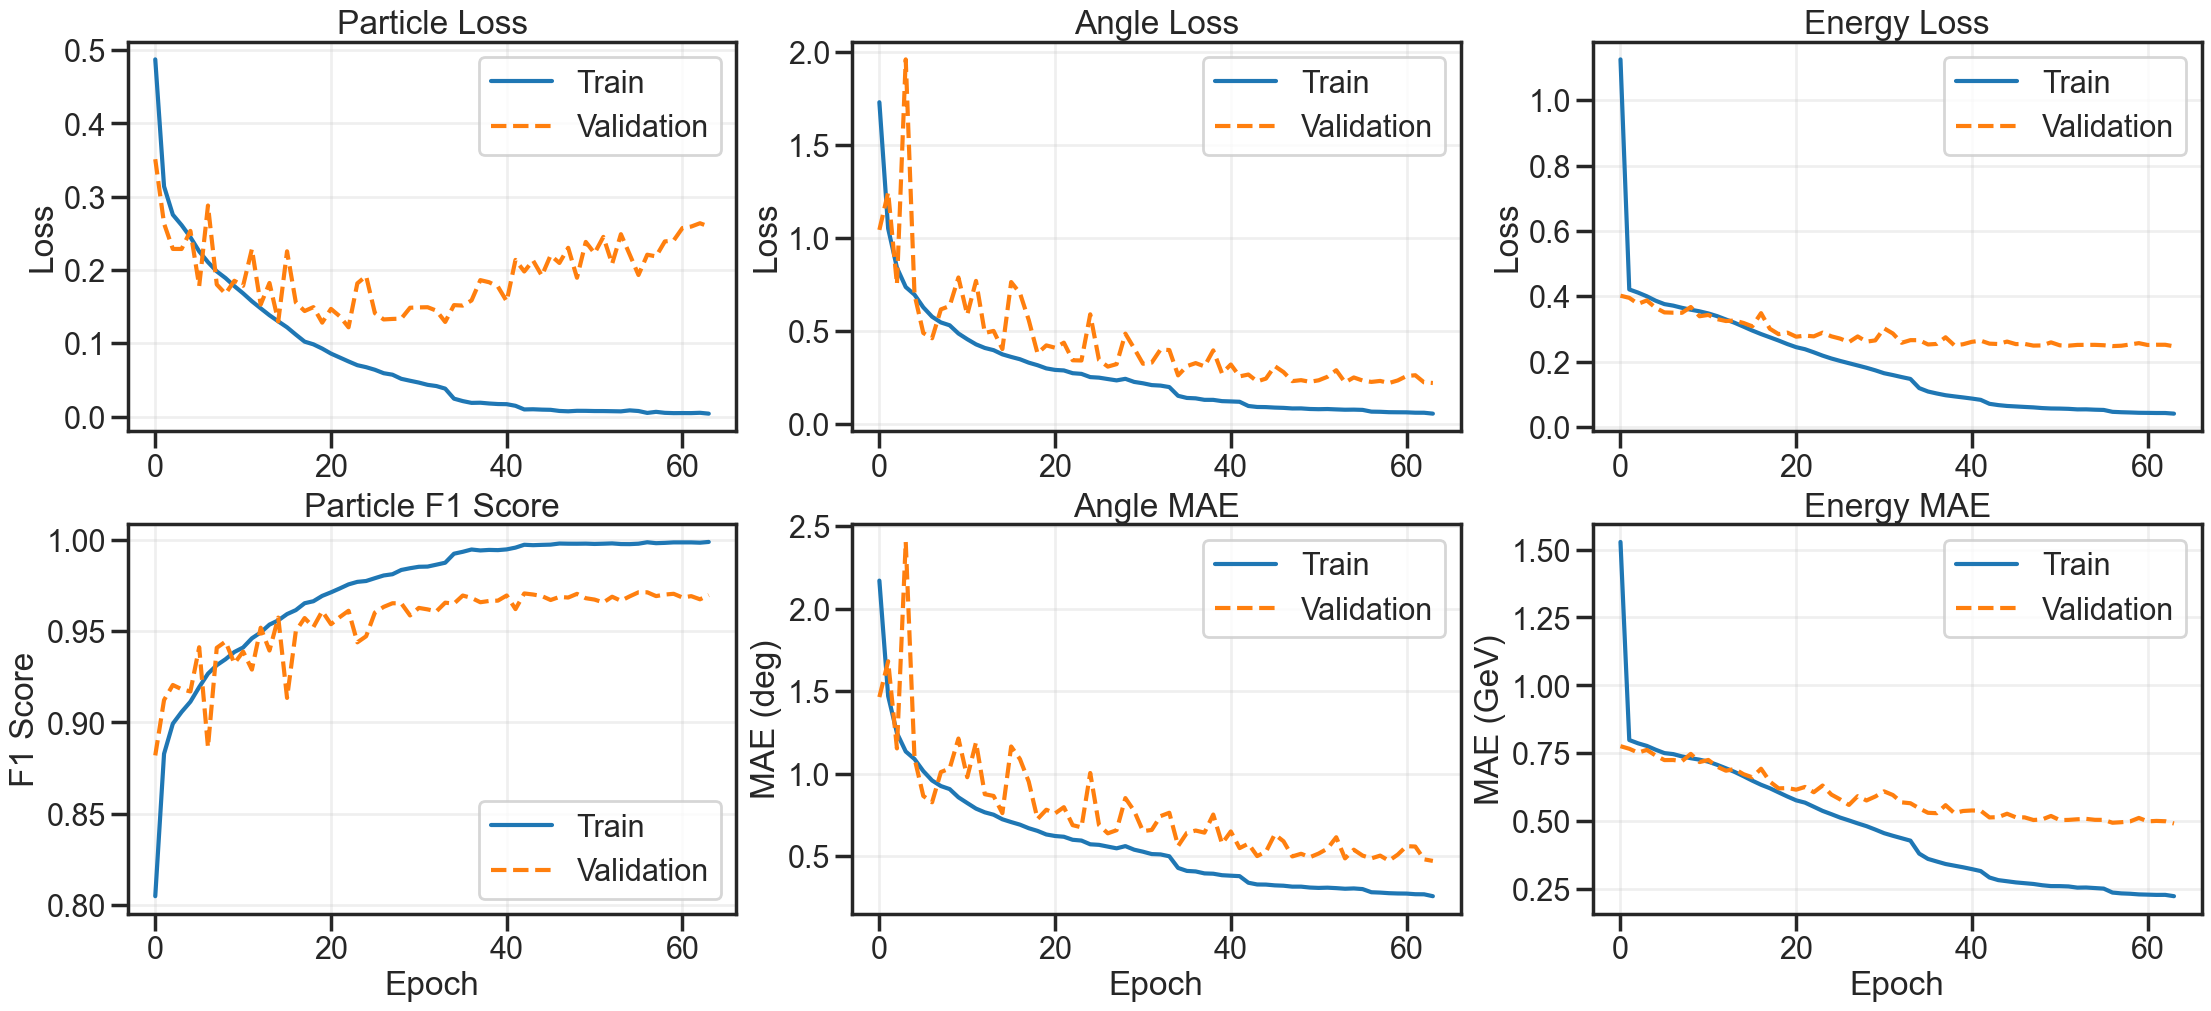

In [35]:
history_csv_path = model_dir / "training_history.csv"
plots_dir = ARTIFACTS_DIR / "diagnostics"
plots_dir.mkdir(parents=True, exist_ok=True)

if "history" not in globals() or history is None:
    if history_csv_path.exists():
        history_df = pd.read_csv(history_csv_path)
        class HistoryObj:
            def __init__(self, df):
                self.history = {col: df[col].values for col in df.columns}
        history = HistoryObj(history_df)
        print(f"Historial de entrenamiento cargado desde: {history_csv_path}")
    else:
        raise FileNotFoundError(f"No se encontró el historial en {history_csv_path}")

# Curvas de entrenamiento
fig, axes = plt.subplots(2, 3, figsize=(22, 10), constrained_layout=True)
for j, (col, title) in enumerate(zip(
    ["particle_output_loss", "angle_output_loss", "energy_output_loss"],
    ["Particle Loss", "Angle Loss", "Energy Loss"],
)):
    axes[0, j].plot(history.history[col], label="Train", color="tab:blue")
    axes[0, j].plot(history.history[f"val_{col}"], label="Validation", color="tab:orange", linestyle="--")
    axes[0, j].set_title(title)
    axes[0, j].set_ylabel("Loss")
    axes[0, j].grid(alpha=0.3)
    axes[0, j].legend()
    axes[1, j].set_xlabel("Epoch")

for j, (col, title, ylabel) in enumerate(zip(
    ["particle_output_f1_score", "angle_output_mae", "energy_output_mae"],
    ["Particle F1 Score", "Angle MAE", "Energy MAE"],
    ["F1 Score", "MAE (deg)", "MAE (GeV)"],
)):
    axes[1, j].plot(history.history[col], label="Train", color="tab:blue")
    axes[1, j].plot(history.history[f"val_{col}"], label="Validation", color="tab:orange", linestyle="--")
    axes[1, j].set_title(title)
    axes[1, j].set_ylabel(ylabel)
    axes[1, j].grid(alpha=0.3)
    axes[1, j].legend()

fig.savefig(plots_dir / "training_curves_artifacts.png", dpi=200)
plt.show()



In [36]:
def attach_attention_recorders(m):
    tap_names = {
        "angle_raw": "attention_scores_angle",
        "particle_raw": "attention_scores_class",
        "energy_raw": "attention_scores_energy",
    }
    m.attention_layer_names = tap_names
    m.attention_recorders = {
        logical: m.get_layer(layer_name)
        for logical, layer_name in tap_names.items()
        if any(layer.name == layer_name for layer in m.layers)
    }

use_in_memory_model = "model" in globals() and model is not None and "history" in globals()

if use_in_memory_model:
    print("Modelo en memoria detectado; se mantiene el modelo entrenado en esta sesión.")
    attach_attention_recorders(model)
else:
    if not model_path.exists():
        raise FileNotFoundError(f"No se encontró el modelo en {model_path}")
    if "F1Score" not in globals():
        class F1Score(tf.keras.metrics.Metric):
            def __init__(self, name="f1_score", threshold=0.5, **kwargs):
                super().__init__(name=name, **kwargs)
                self.threshold = threshold
                self.tp = self.add_weight("tp", initializer="zeros")
                self.fp = self.add_weight("fp", initializer="zeros")
                self.fn = self.add_weight("fn", initializer="zeros")

            def update_state(self, y_true, y_pred, sample_weight=None):
                y_pred = tf.cast(y_pred > self.threshold, tf.float32)
                y_true = tf.cast(y_true, tf.float32)
                self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
                self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
                self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

            def result(self):
                precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
                recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
                return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

            def reset_state(self):
                for var in (self.tp, self.fp, self.fn):
                    var.assign(0.0)

    model = tf.keras.models.load_model(
        model_path,
        custom_objects={"F1Score": F1Score},
    )
    attach_attention_recorders(model)
    print(f"Modelo cargado desde: {model_path}")

Modelo en memoria detectado; se mantiene el modelo entrenado en esta sesión.


### Test Evaluation
- Keras metrics + custom metrics (accuracy, MAE, RMSE).
- Denormalize energy predictions.

In [37]:
# ----------------------------- #
# Evaluación numérica básica    #
# ----------------------------- #
eval_results = model.evaluate(
    x=[X_test, Xg_test],
    y=[y_label_test, y_angle_test, y_energy_test_scaled],
    verbose=1,
)
metrics_names = model.metrics_names
eval_dict = {name: float(value) for name, value in zip(metrics_names, eval_results)}

pred_particle, pred_angle, pred_energy_scaled = model.predict([X_test, Xg_test], batch_size=256, verbose=1)
pred_particle = pred_particle.reshape(-1)
pred_angle = pred_angle.reshape(-1)
pred_energy_scaled = pred_energy_scaled.reshape(-1)
pred_energy_cont = pred_energy_scaled * energy_std + energy_mean

pred_particle_labels = (pred_particle >= 0.5).astype(np.int32)
particle_accuracy = float(np.mean(pred_particle_labels == y_label_test))
angle_mae = float(np.mean(np.abs(pred_angle - y_angle_test)))
energy_mae = float(np.mean(np.abs(pred_energy_cont - y_energy_test_cont)))
energy_rmse = float(np.sqrt(np.mean((pred_energy_cont - y_energy_test_cont) ** 2)))

additional_metrics = {
    "particle_accuracy_custom": particle_accuracy,
    "angle_mae_deg_custom": angle_mae,
    "energy_mae_GeV_custom": energy_mae,
    "energy_rmse_GeV_custom": energy_rmse,
}

44/44 [==============================] - 10s 189ms/step


In [38]:
# ----------------------------- #
# Persistencia de artefactos    #
# ----------------------------- #

# Persistir metadatos de atención para reconstruir los taps al recargar
default_attention_map = {
    "angle_raw": "attention_scores_angle",
    "particle_raw": "attention_scores_class",
    "energy_raw": "attention_scores_energy",
}
attention_map = getattr(model, "attention_layer_names", None) or default_attention_map
attention_json = model_dir / "attention_layers.json"
with attention_json.open("w", encoding="utf-8") as fh:
    json.dump(attention_map, fh, indent=2)
print(f"Mapeo de capas de atención guardado en: {attention_json}")

# history_df = pd.DataFrame(history.history)
history_csv = model_dir / "training_history.csv"
# history_df.to_csv(history_csv, index=False)
# print(f"Historial de entrenamiento guardado en: {history_csv}")

metrics_path = model_dir / "evaluation_metrics.json"
with metrics_path.open("w", encoding="utf-8") as fh:
    json.dump(
        {"keras_metrics": eval_dict, "custom_metrics": additional_metrics},
        fh,
        indent=2,
    )
print(f"Métricas básicas guardadas en: {metrics_path}")

pred_npz_path = ARTIFACTS_DIR / "test_predictions.npz"
np.savez_compressed(
    pred_npz_path,
    particle_probability=pred_particle.astype(np.float32),
    particle_label_pred=pred_particle_labels,
    particle_label_true=y_label_test,
    angle_pred=pred_angle.astype(np.float32),
    angle_true=y_angle_test,
    energy_pred_scaled=pred_energy_scaled.astype(np.float32),
    energy_pred=pred_energy_cont.astype(np.float32),
    energy_true=y_energy_test_cont,
    energy_true_str=np.array(y_energy_test, dtype="<U8"),
    energy_levels=np.array(energy_levels, dtype="<U8"),
    energy_mean=np.array([energy_mean], dtype=np.float32),
    energy_std=np.array([energy_std], dtype=np.float32),
)
print(f"Predicciones de test guardadas en: {pred_npz_path}")

Mapeo de capas de atención guardado en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\model\attention_layers.json
Métricas básicas guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\model\evaluation_metrics.json
Predicciones de test guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\test_predictions.npz


In [39]:
metadata = {
    "seed": SEED,
    "energies_used": list(ENERGY_FILTER),
    "angle_max_deg": ANGLE_MAX,
    "min_total_particles": MIN_TOTAL_PARTICLES,
    "balance_target_per_group": target_per_group,
    "num_events_total": int(len(df_balanced)),
    "train_val_test_split": {
        "train": int(len(train_idx)),
        "val": int(len(val_idx)),
        "test": int(len(test_idx)),
    },
    "feature_order": FEATURE_NAMES,
    "max_sequence_length": max_sequence_length,
    "global_features_definition": [
        "sum_particle_count",
        "sum_total_energy",
        "num_active_detectors",
        "duration_tbin",
        "sum_total_energy_central_ids",
    ],
    "central_detector_ids": [int(x) for x in central_ids],
    "energy_scaling": {"mean": energy_mean, "std": energy_std},
    "artifacts": {
        "dataset_npz": str(pred_npz_path),
        "history_csv": str(history_csv),
        "model_path": str(model_path),
        "metrics_path": str(metrics_path),
        "predictions_npz": str(pred_npz_path),
        "detector_catalog_csv": str(ARTIFACTS_DIR / "detector_catalog.csv"),
    },
    "keras_metrics": eval_dict,
    "custom_metrics": additional_metrics,
}

metadata_path = ARTIFACTS_DIR / "preprocessing_metadata.json"
with metadata_path.open("w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)
print(f"Metadata guardada en: {metadata_path}")

Metadata guardada en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\preprocessing_metadata.json


In [40]:
# ----------------------------- #
# Visualización de predicciones #
# ----------------------------- #

pred_summary = pd.DataFrame(
    {
        "particle_true": y_label_test.astype(int),
        "particle_pred_prob": pred_particle.astype(float),
        "particle_pred_label": pred_particle_labels.astype(int),
        "angle_true_deg": y_angle_test.astype(float),
        "angle_pred_deg": pred_angle.astype(float),
        "energy_true_GeV": y_energy_test_cont.astype(float),
        "energy_pred_GeV": pred_energy_cont.astype(float),
        "energy_level_true": y_energy_test,
    }
)
pred_summary["angle_error_deg"] = pred_summary["angle_pred_deg"] - pred_summary["angle_true_deg"]
pred_summary["energy_error_GeV"] = pred_summary["energy_pred_GeV"] - pred_summary["energy_true_GeV"]
pred_summary["particle_correct"] = pred_summary["particle_pred_label"] == pred_summary["particle_true"]
pred_summary["angle_abs_error_deg"] = pred_summary["angle_error_deg"].abs()
pred_summary["energy_abs_error_GeV"] = pred_summary["energy_error_GeV"].abs()

angle_metrics = {
    "MAE (deg)": mean_absolute_error(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
    "RMSE (deg)": root_mean_squared_error(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
    "R2": r2_score(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
}
energy_metrics = {
    "MAE (GeV)": mean_absolute_error(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
    "RMSE (GeV)": root_mean_squared_error(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
    "R2": r2_score(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
}

display(pd.DataFrame(angle_metrics, index=["Ángulo"]).T.round(4))
display(pd.DataFrame(energy_metrics, index=["Energía"]).T.round(4))

Ángulo
MAE (deg)   0.5095
RMSE (deg)  0.7740
R2          0.9959

Energía
MAE (GeV)   100.9871
RMSE (GeV)  152.2409
R2            0.4498

### Gamma/Hadron Results
- Confusion matrix, classification report.
- ROC/AUC, score histograms.
- Q-factor, efficiencies, Li-Ma significance.

precision  recall  f1-score     support
Proton           0.9736  0.9668    0.9702   5606.0000
Photon           0.9670  0.9738    0.9704   5603.0000
accuracy         0.9703  0.9703    0.9703      0.9703
macro avg        0.9703  0.9703    0.9703  11209.0000
weighted avg     0.9703  0.9703    0.9703  11209.0000

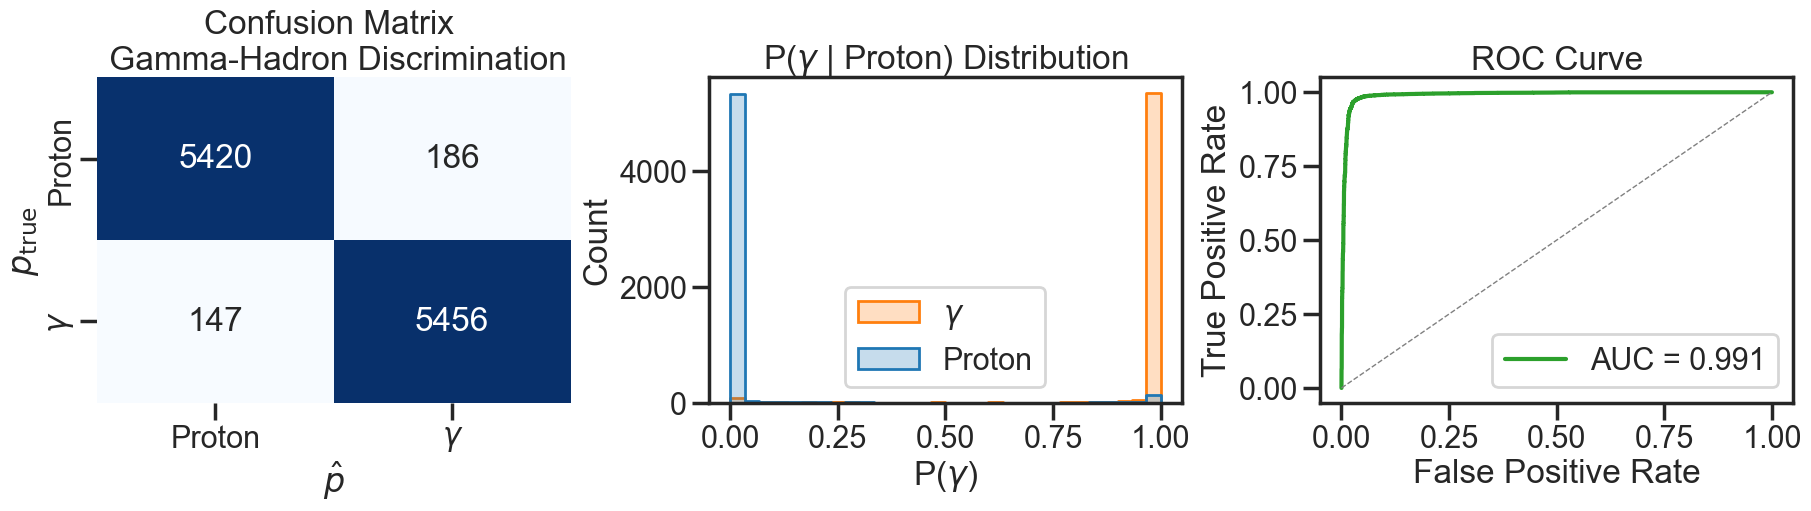

In [41]:
# ----------------------------- #
# Diagnóstico de clasificación de partícula #
# ----------------------------- #
cm_particle = confusion_matrix(pred_summary["particle_true"], pred_summary["particle_pred_label"])
particle_report = classification_report(
    pred_summary["particle_true"],
    pred_summary["particle_pred_label"],
    target_names=["Proton", "Photon"],
    output_dict=True,
)
display(pd.DataFrame(particle_report).T.round(4))

fpr, tpr, _ = roc_curve(pred_summary["particle_true"], pred_summary["particle_pred_prob"])
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

sns.heatmap(cm_particle, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_xlabel(r"$\hat{p}$")
axes[0].set_ylabel(r"$p_{\text{true}}$")
axes[0].set_title("Confusion Matrix \n Gamma-Hadron Discrimination")
axes[0].set_xticklabels(["Proton", r"$\gamma$"])
axes[0].set_yticklabels(["Proton", r"$\gamma$"])

sns.histplot(
    data=pred_summary,
    x="particle_pred_prob",
    hue="particle_true",
    bins=30,
    element="step",
    common_norm=False,
    palette={0: "tab:blue", 1: "tab:orange"},
    ax=axes[1],
)
axes[1].set_title(r"P($\gamma$ | Proton) Distribution")
axes[1].set_xlabel(r"P($\gamma$)")
axes[1].legend(labels=[r"$\gamma$", "Proton"])

axes[2].plot(fpr, tpr, color="tab:green", label=f"AUC = {roc_auc:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC Curve")
axes[2].legend(loc="lower right")

fig.savefig(plots_dir / "particle_predictions_overview.png", dpi=200)
plt.show()

In [42]:
# ============================================================
# Q-FACTOR Y EFICIENCIAS (Estándar en IACT/Observatorios)
# ============================================================

def gamma_hadron_metrics(y_true, y_pred_proba, threshold=0.5):
    """
    Métricas estándar en discriminación gamma/hadron:
    - Q-factor: figura de mérito
    - Eficiencias gamma/hadron
    - Pureza de muestra
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Asumiendo: 1=gamma, 0=proton
    gamma_mask = y_true == 1
    proton_mask = y_true == 0
    
    # True Positives, False Positives, etc.
    tp = np.sum((y_pred == 1) & gamma_mask)
    fp = np.sum((y_pred == 1) & proton_mask)
    fn = np.sum((y_pred == 0) & gamma_mask)
    tn = np.sum((y_pred == 0) & proton_mask)
    
    epsilon_gamma = tp / (tp + fn) if (tp + fn) > 0 else 0  # Eficiencia gamma
    epsilon_hadron = fp / (fp + tn) if (fp + tn) > 0 else 0  # Contaminación hadrónica
    
    # Q-factor (usado en CTA, MAGIC, VERITAS)
    q_factor = epsilon_gamma / np.sqrt(epsilon_hadron) if epsilon_hadron > 0 else 0
    
    # Pureza de muestra gamma
    purity = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'efficiency_gamma': epsilon_gamma,
        'contamination_hadron': epsilon_hadron,
        'q_factor': q_factor,
        'purity_gamma': purity,
        'significance_lima': calculate_lima_significance(tp, fp)  # Ver abajo
    }

def calculate_lima_significance(n_on, n_off, alpha=1.0):
    """
    Li & Ma significance (ApJ 272:317-324, 1983)
    Estándar en astronomía de rayos gamma
    """
    if n_on == 0 or n_off == 0:
        return 0.0
    
    n_on = float(n_on)
    n_off = float(n_off)
    
    term1 = n_on * np.log((1 + alpha) / alpha * (n_on / (n_on + n_off)))
    term2 = n_off * np.log((1 + alpha) * (n_off / (n_on + n_off)))
    
    significance = np.sqrt(2 * (term1 + term2))
    return significance

gh_metrics = gamma_hadron_metrics(
    pred_summary["particle_true"],
    pred_summary["particle_pred_prob"]
)

print("\n🎯 GAMMA/HADRON DISCRIMINATION (Standard Metrics)")
print("="*60)
for key, val in gh_metrics.items():
    print(f"  {key:25s}: {val:.4f}")


🎯 GAMMA/HADRON DISCRIMINATION (Standard Metrics)
  efficiency_gamma         : 0.9738
  contamination_hadron     : 0.0332
  q_factor                 : 5.3459
  purity_gamma             : 0.9670
  significance_lima        : 78.6531


### Zenith Angle Results
- Error distributions (abs/rel).
- Profile plots: predicted vs true.
- Metrics: MAE, RMSE, bias, PSF68.

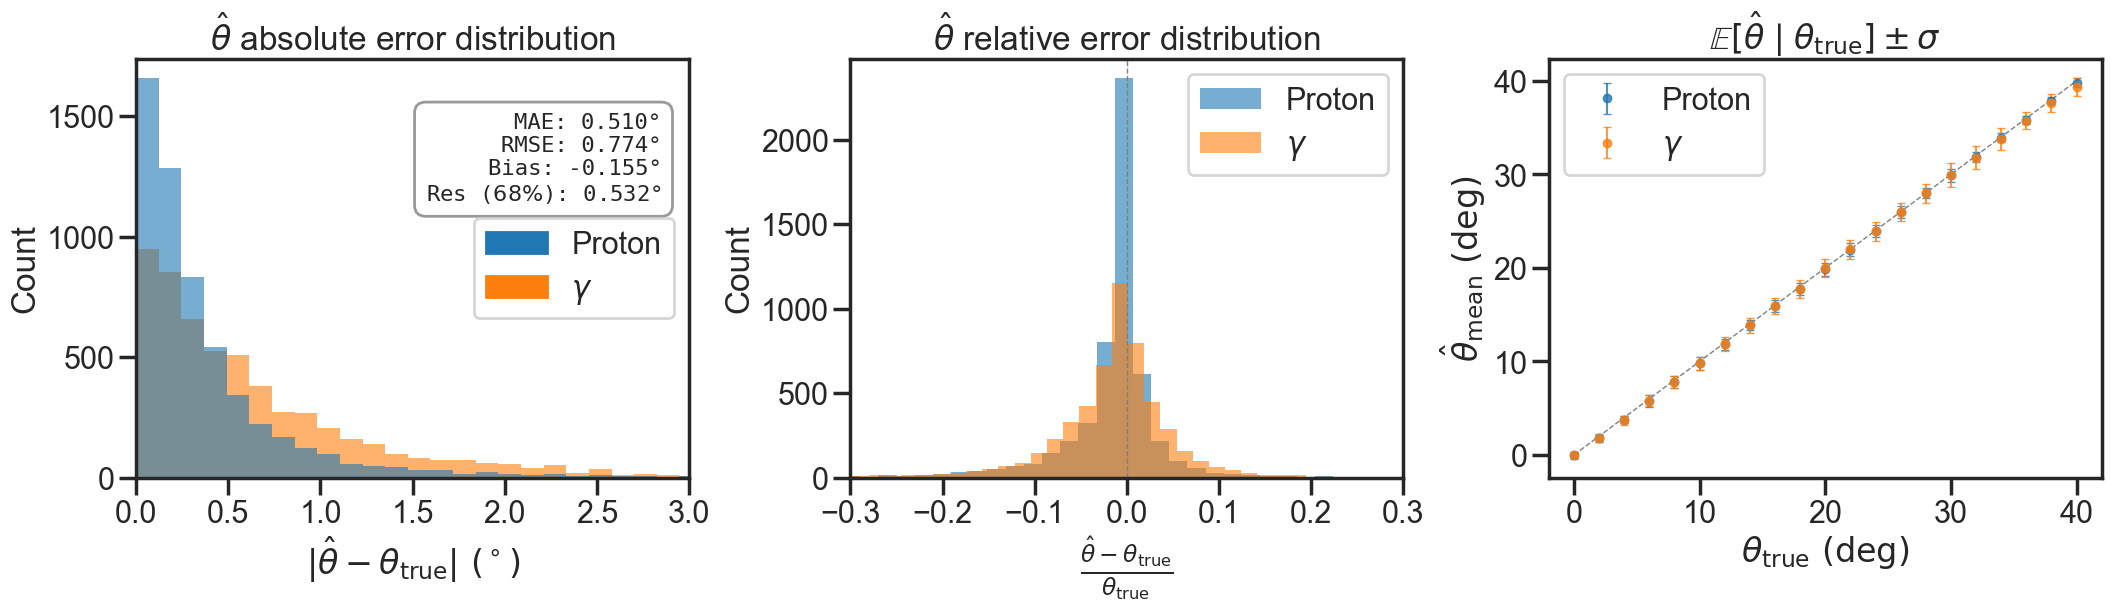

In [43]:
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------- #
# Diagnóstico de ángulo y energía (por partícula) #
# ----------------------------- #
theta_hat = pred_summary["angle_pred_deg"]
theta_true = pred_summary["angle_true_deg"]
particle_series = pred_summary["particle_true"]

particle_names = {0: "Proton", 1: r"$\gamma$"}
particle_palette = {0: "tab:blue", 1: "tab:orange"}

# --- Cálculos para Gráfico 2 (Error Relativo) ---
denom = theta_true.replace(0.0, np.nan)
theta_rel_error = (theta_hat - theta_true) / denom
theta_rel_error = theta_rel_error.replace([np.inf, -np.inf], np.nan)

# --- Agrupación para Gráfico 3 ---
angle_bins = np.round(theta_true, 1)
angle_group = (
    pred_summary.assign(angle_bin=angle_bins)
    .groupby("angle_bin")
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)
angle_group_particle = (
    pred_summary.assign(angle_bin=angle_bins)
    .groupby(["particle_true", "angle_bin"])
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)

# --- CÁLCULO DE MÉTRICAS PARA EL TEXTO ---
# Calculamos directamente desde los datos para asegurar consistencia
errors = theta_hat - theta_true
abs_errors = np.abs(errors)

mae_val = np.mean(abs_errors)
rmse_val = np.sqrt(np.mean(errors**2))
bias_val = np.mean(errors) # Bias sistemático (Mean Signed Error)
resolution_val = np.percentile(abs_errors, 68) # Resolución Angular (Sigma 68)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

# --- AXES 0: Distribución de Error Absoluto ---
sns.histplot(
    pred_summary,
    x="angle_abs_error_deg",
    hue="particle_true",
    bins=60,
    ax=axes[0],
    edgecolor="none",
    alpha=0.6,
    palette=particle_palette,
)
axes[0].set_xlabel(r"$|\hat{\theta} - \theta_{\mathrm{true}}|\ (^\circ)$")
axes[0].set_title(r"$\hat{\theta}$ absolute error distribution")
axes[0].legend(handles=[
    Patch(color=particle_palette[pid], label=particle_names[pid]) for pid in particle_palette
])
axes[0].set_xlim(0.0, 3.0)

# --- TEXTO CON LAS 4 MÉTRICAS ---
metrics_text = (
    f"MAE: {mae_val:.3f}°\n"
    f"RMSE: {rmse_val:.3f}°\n"
    f"Bias: {bias_val:+.3f}°\n"     # El signo + fuerza a mostrar + o -
    f"Res ($68\%$): {resolution_val:.3f}°"
)

axes[0].text(
    0.95,
    0.65, # Bajé ligeramente la posición para que quepa bien
    metrics_text,
    transform=axes[0].transAxes,
    fontsize=16,
    va="bottom",
    ha="right",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.5"),
    family="monospace" # Alineación numérica mejorada
)

# --- AXES 1: Distribución de Error Relativo ---
for pid, color in particle_palette.items():
    mask = particle_series == pid
    sns.histplot(
        theta_rel_error[mask].dropna(),
        bins=80,
        color=color,
        ax=axes[1],
        edgecolor="none",
        alpha=0.6,
        label=particle_names[pid],
    )
axes[1].axvline(0.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\frac{\hat{\theta}-\theta_{\mathrm{true}}}{\theta_{\mathrm{true}}}$")
axes[1].set_title(r"$\hat{\theta}$ relative error distribution")
axes[1].set_xlim(-0.3, 0.3)
axes[1].legend()

# --- AXES 2: Perfil (Mean +- Std) ---
for pid, color in particle_palette.items():
    subset = angle_group_particle[angle_group_particle["particle_true"] == pid]
    axes[2].errorbar(
        subset["angle_bin"],
        subset["mean_pred"],
        yerr=subset["std_pred"].fillna(0.0),
        fmt=".",
        color=color,
        ecolor=color,
        elinewidth=1.5,
        alpha=0.8,
        capsize=3,
        label=particle_names[pid],
    )
axes[2].plot(
    angle_group["angle_bin"],
    angle_group["angle_bin"],
    color="gray",
    linestyle="--",
    linewidth=1,
)
axes[2].set_xlabel(r"$\theta_{\mathrm{true}}\ (\text{deg})$")
axes[2].set_ylabel(r"$\hat{\theta}_{\mathrm{mean}}\ (\text{deg})$")
axes[2].set_title(r"$\mathbb{E}[\hat{\theta}\mid\theta_{\mathrm{true}}] \pm \sigma$")
axes[2].legend()

# Guardar y mostrar
#fig.savefig(plots_dir / "angle_predictions_overview.png", dpi=200)
plt.show()

In [44]:
# Agregar después de la celda de métricas de ángulo:

# ============================================================
# MÉTRICAS ESTÁNDAR DE RECONSTRUCCIÓN ANGULAR
# ============================================================

def angular_resolution_metrics(theta_true, theta_pred, percentiles=[68, 95]):
    """
    Métricas estándar en astrofísica de rayos cósmicos.
    
    Returns:
    - PSF (Point Spread Function): percentiles del error angular
    - Bias sistemático
    - Resolution (sigma efectivo)
    """
    errors = np.abs(theta_pred - theta_true)
    
    metrics = {
        'bias_deg': np.mean(theta_pred - theta_true),
        'median_error_deg': np.median(errors),
        'rms_deg': np.sqrt(np.mean((theta_pred - theta_true)**2)),
    }
    
    # PSF: Angular Resolution (equivalente a "sigma" en astronomía)
    for p in percentiles:
        metrics[f'psf_{p}_deg'] = np.percentile(errors, p)
    
    # Q-factor: fracción de eventos bien reconstruidos (< 5°)
    metrics['q_factor_5deg'] = np.mean(errors < 5.0)
    
    return metrics

angle_resolution = angular_resolution_metrics(
    pred_summary["angle_true_deg"], 
    pred_summary["angle_pred_deg"]
)

print("\n📐 ANGULAR RESOLUTION (Standard Metrics)")
print("="*60)
for key, val in angle_resolution.items():
    print(f"  {key:20s}: {val:.4f}")


📐 ANGULAR RESOLUTION (Standard Metrics)
  bias_deg            : -0.1547
  median_error_deg    : 0.3136
  rms_deg             : 0.7740
  psf_68_deg          : 0.5320
  psf_95_deg          : 1.7119
  q_factor_5deg       : 0.9996


### Energy Estimation Results
- Predicted energy histograms by true bin.
- Absolute/relative errors; linearity plot.
- Bias/Resolution per energy bin; pull distribution.

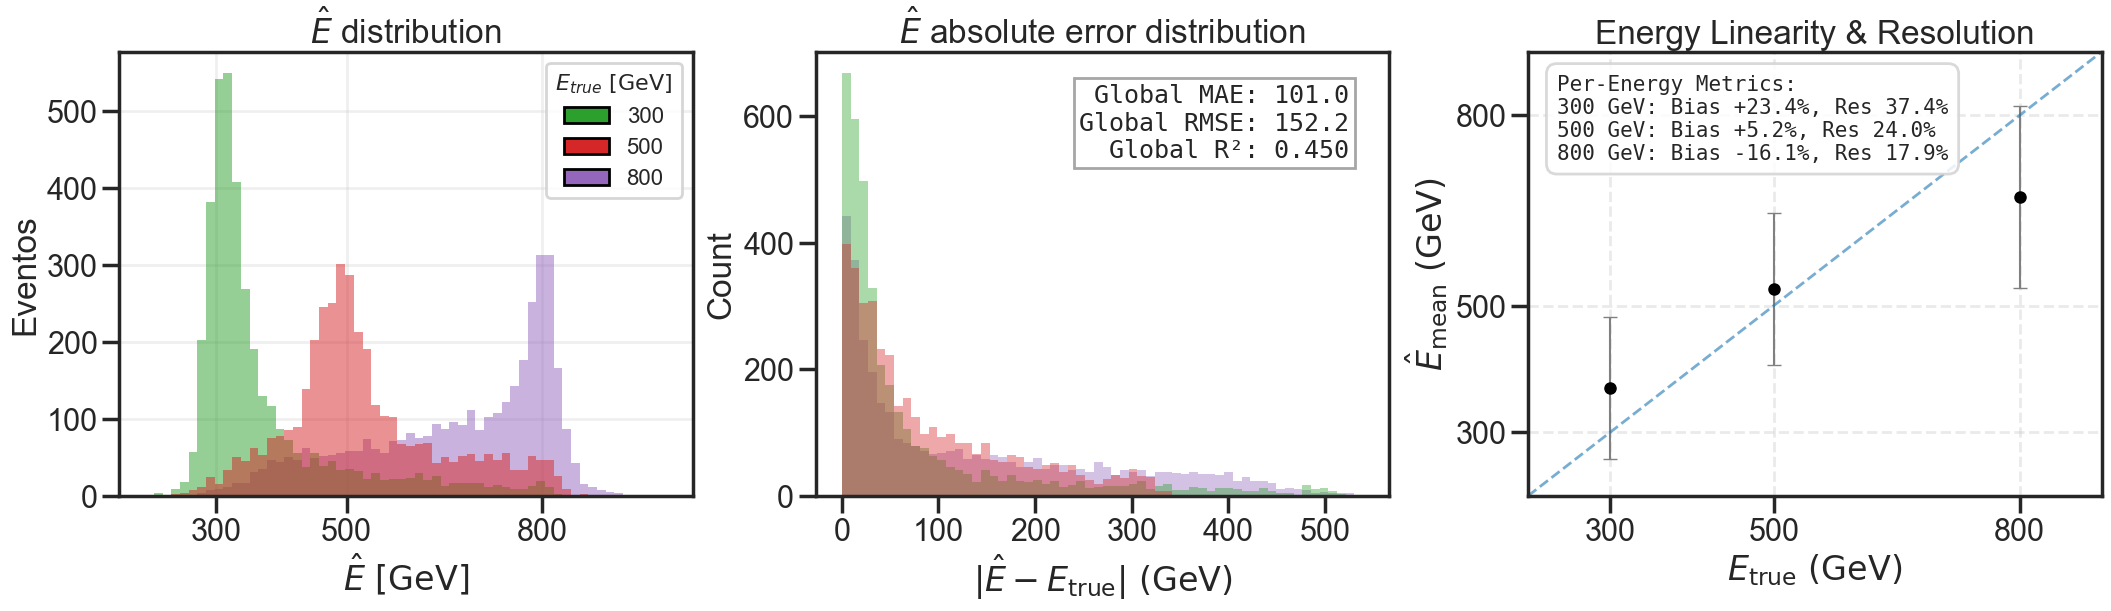

In [45]:
E_hat = pred_summary["energy_pred_GeV"]
E_true = pred_summary["energy_true_GeV"]

# Cálculo de error relativo global para uso interno
# Bias = (Pred - True) / True
rel_error_series = (E_hat - E_true) / E_true.replace(0.0, np.nan)
pred_summary["relative_error"] = rel_error_series # Lo guardamos en el DF para facilitar el groupby

energy_group = (
    pred_summary.groupby("energy_true_GeV")
    .agg(mean_pred=("energy_pred_GeV", "mean"), std_pred=("energy_pred_GeV", "std"))
    .reset_index()
)

energy_group_level = (
    pred_summary.groupby("energy_level_true")
    .agg(
        mean_pred=("energy_pred_GeV", "mean"),
        std_pred=("energy_pred_GeV", "std"),
        true_energy=("energy_true_GeV", "mean"),
    )
    .reset_index()
    .sort_values("true_energy")
)

energy_palette = {"3E2": "tab:green", "5E2": "tab:red", "8E2": "tab:purple"}
label_map = {"3E2": "300", "5E2": "500", "8E2": "800"}
desired_order = ["300", "500", "800"]

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

# --- AXES 0: Distribución de Predicciones ---
sns.histplot(
    data=pred_summary,
    x="energy_pred_GeV",
    hue="energy_level_true",
    bins=60,
    ax=axes[0],
    alpha=0.5,
    edgecolor="none",
    palette=energy_palette,
    multiple="layer",
)
axes[0].set_xlabel(r"$\hat{E}\ \mathrm{[GeV]}$")
axes[0].set_ylabel("Eventos")
axes[0].set_title(r"$\hat{E}$ distribution")
axes[0].set_xticks([300, 500, 800])
axes[0].grid(alpha=0.3)

# Leyenda ordenada para Axes 0
handles0, labels0 = axes[0].get_legend_handles_labels()
if handles0:
    mapped = []
    for h, lab in zip(handles0, labels0):
        mapped_label = label_map.get(lab, lab)
        mapped.append((mapped_label, h))
    in_order = [item for item in mapped if item[0] in desired_order]
    out_order = [item for item in mapped if item[0] not in desired_order]
    in_order_sorted = sorted(in_order, key=lambda x: desired_order.index(x[0]))
    new_handles = [h for lbl, h in (in_order_sorted + out_order)]
    new_labels = [lbl for lbl, h in (in_order_sorted + out_order)]
    axes[0].legend(new_handles, new_labels, title=r"$E_{true}\ \mathrm{[GeV]}$")
else:
    manual_handles = []
    manual_labels = []
    for key in ["3E2", "5E2", "8E2"]:
        if (pred_summary["energy_level_true"] == key).any():
            manual_handles.append(Patch(facecolor=energy_palette[key], edgecolor="k"))
            manual_labels.append(label_map[key])
    if manual_handles:
        axes[0].legend(manual_handles, manual_labels, title=r"$E_{true}\ \mathrm{[GeV]}$", fontsize=16, title_fontsize=16)

# --- AXES 1: Error Absoluto ---
sns.histplot(
    pred_summary,
    x="energy_abs_error_GeV",
    hue="energy_level_true",
    bins=60,
    ax=axes[1],
    alpha=0.4,
    edgecolor="none",
    palette=energy_palette,
)
axes[1].set_xlabel(r"$|\hat{E} - E_{\mathrm{true}}|\ (\mathrm{GeV})$")
axes[1].set_title(r"$\hat{E}$ absolute error distribution")
leg1 = axes[1].get_legend()
if leg1:
    leg1.remove()

sigma_mu_E = energy_group["std_pred"].mean()
metrics_text_E = (
    f"Global MAE: {energy_metrics['MAE (GeV)']:.1f}\n"
    f"Global RMSE: {energy_metrics['RMSE (GeV)']:.1f}\n"
    f"Global R²: {energy_metrics['R2']:.3f}"
)
axes[1].text(
    0.93, 0.75, metrics_text_E,
    transform=axes[1].transAxes,
    fontsize=18,
    va="bottom",
    ha="right",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),
    family="monospace"
)

# --- AXES 2: Linealidad con Bias y Resolución ---
axes[2].errorbar(
    energy_group_level["true_energy"],
    energy_group_level["mean_pred"],
    yerr=energy_group_level["std_pred"].fillna(0.0),
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=1.5,
    capsize=5,
    markersize=8
)
# Línea de identidad perfecta
axes[2].plot(
    [200, 900], [200, 900], # Rango extendido para que se vea bien la línea
    color="tab:blue",
    linestyle="--",
    linewidth=2,
    alpha=0.6,
    label="Ideal"
)

# --- CÁLCULO DE BIAS Y RESOLUCIÓN PARA EL CUADRO DE TEXTO ---
stats_text_lines = ["Per-Energy Metrics:"]
map_keys = [("3E2", "300"), ("5E2", "500"), ("8E2", "800")]

for key_df, label_display in map_keys:
    # Filtrar datos por nivel de energía
    subset = pred_summary[pred_summary["energy_level_true"] == key_df]
    
    if not subset.empty:
        # Bias: Media del error relativo (%)
        # Resolution: Desviación estándar del error relativo (%)
        rel_errs = subset["relative_error"]
        bias_pct = rel_errs.mean() * 100
        res_pct = rel_errs.std() * 100
        
        line = f"{label_display} GeV: Bias {bias_pct:+.1f}%, Res {res_pct:.1f}%"
        stats_text_lines.append(line)

final_stats_text = "\n".join(stats_text_lines)

# Insertar el cuadro de texto en Axes 2 (Esquina superior izquierda)
axes[2].text(
    0.05, 0.95, 
    final_stats_text,
    transform=axes[2].transAxes,
    fontsize=15,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="lightgray", boxstyle="round,pad=0.5"),
    family="monospace" # Fuente monoespaciada para que los números se alineen mejor
)

axes[2].set_xlabel(r"$E_{\mathrm{true}}\ (\mathrm{GeV})$")
axes[2].set_ylabel(r"$\hat{E}_{\mathrm{mean}}\ (\mathrm{GeV})$")
axes[2].set_title(r"Energy Linearity & Resolution")
axes[2].set_xticks([300, 500, 800])
axes[2].set_yticks([300, 500, 800])
axes[2].set_xlim(200, 900)
axes[2].set_ylim(200, 900)
axes[2].grid(True, linestyle="--", alpha=0.4)

# Guardar y mostrar
# fig.savefig(plots_dir / "energy_predictions_overview.png", dpi=200)
plt.show()

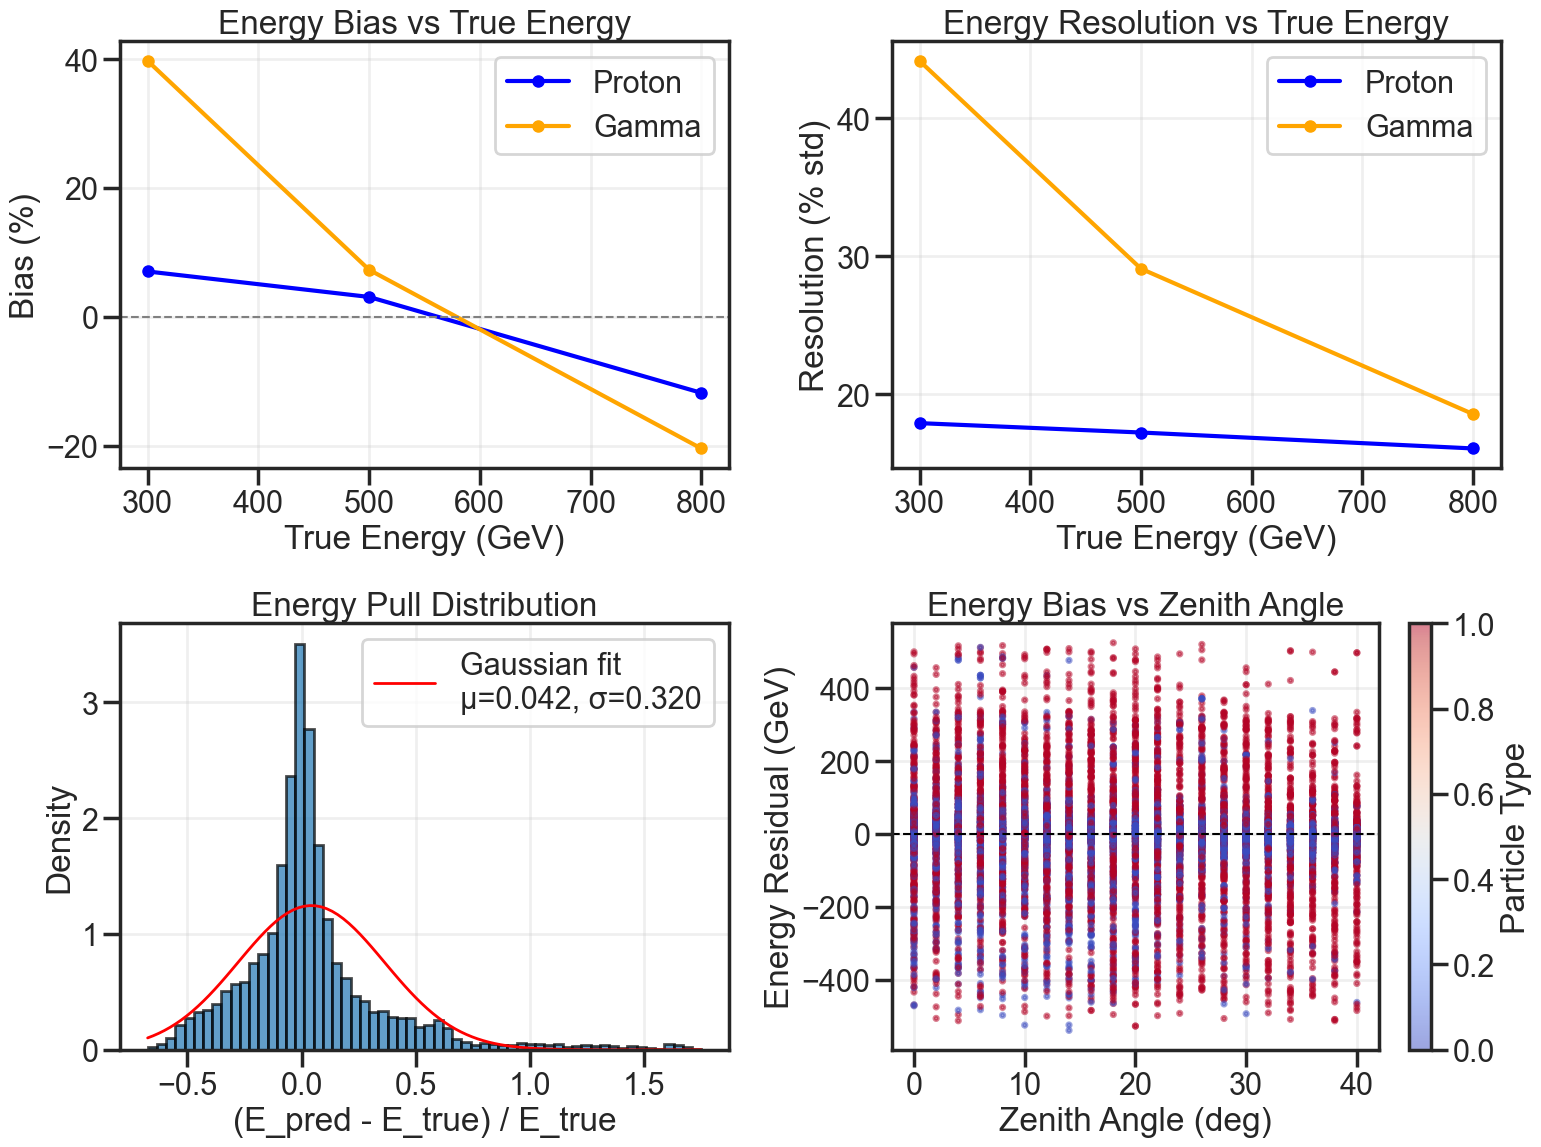

In [46]:
# Reemplazar el Plot de Energía actual por:

# ============================================================
# ENERGY BIAS & RESOLUTION (Estilo CTA/MAGIC)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bias vs True Energy (con ajuste)
ax1 = axes[0, 0]
for particle_type, color, label in [(0, 'blue', 'Proton'), (1, 'orange', 'Gamma')]:
    mask = pred_summary["particle_true"] == particle_type
    subset = pred_summary[mask].groupby("energy_true_GeV").agg({
        "energy_pred_GeV": "mean",
        "energy_true_GeV": "mean"
    }).reset_index(drop=True)
    
    bias = (subset["energy_pred_GeV"] - subset["energy_true_GeV"]) / subset["energy_true_GeV"] * 100
    ax1.plot(subset["energy_true_GeV"], bias, 'o-', color=color, label=label, markersize=8)

ax1.axhline(0, color='gray', linestyle='--', linewidth=1.5)
ax1.set_xlabel("True Energy (GeV)")
ax1.set_ylabel("Bias (%)")
ax1.set_title("Energy Bias vs True Energy")
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Resolution vs True Energy
ax2 = axes[0, 1]
for particle_type, color, label in [(0, 'blue', 'Proton'), (1, 'orange', 'Gamma')]:
    mask = pred_summary["particle_true"] == particle_type
    subset = pred_summary[mask].groupby("energy_true_GeV").agg({
        "relative_error": lambda x: x.std() * 100
    }).reset_index()
    
    ax2.plot(subset["energy_true_GeV"], subset["relative_error"], 'o-', color=color, label=label, markersize=8)

ax2.set_xlabel("True Energy (GeV)")
ax2.set_ylabel("Resolution (% std)")
ax2.set_title("Energy Resolution vs True Energy")
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Pull Distribution (debe ser Gaussiana centrada en 0)
ax3 = axes[1, 0]
pull = (pred_summary["energy_pred_GeV"] - pred_summary["energy_true_GeV"]) / pred_summary["energy_true_GeV"]

ax3.hist(pull, bins=60, alpha=0.7, edgecolor='black', density=True)
mu, sigma = pull.mean(), pull.std()

# Fit Gaussiano
from scipy.stats import norm
x = np.linspace(pull.min(), pull.max(), 100)
ax3.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Gaussian fit\nμ={mu:.3f}, σ={sigma:.3f}')
ax3.set_xlabel("(E_pred - E_true) / E_true")
ax3.set_ylabel("Density")
ax3.set_title("Energy Pull Distribution")
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Energy vs Angle (detectar dependencias sistemáticas)
ax4 = axes[1, 1]
scatter = ax4.scatter(pred_summary["angle_true_deg"], 
                      pred_summary["energy_pred_GeV"] - pred_summary["energy_true_GeV"],
                      c=pred_summary["particle_true"], cmap='coolwarm', alpha=0.5, s=10)
ax4.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax4.set_xlabel("Zenith Angle (deg)")
ax4.set_ylabel("Energy Residual (GeV)")
ax4.set_title("Energy Bias vs Zenith Angle")
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label("Particle Type")
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / "energy_detailed_analysis.png", dpi=200)
plt.show()

### Stratified ROC Analyses
- ROC by energy bin (3E2, 5E2, 8E2).
- ROC by zenith bins (0–10, 10–20, 20–30, 30–40°).

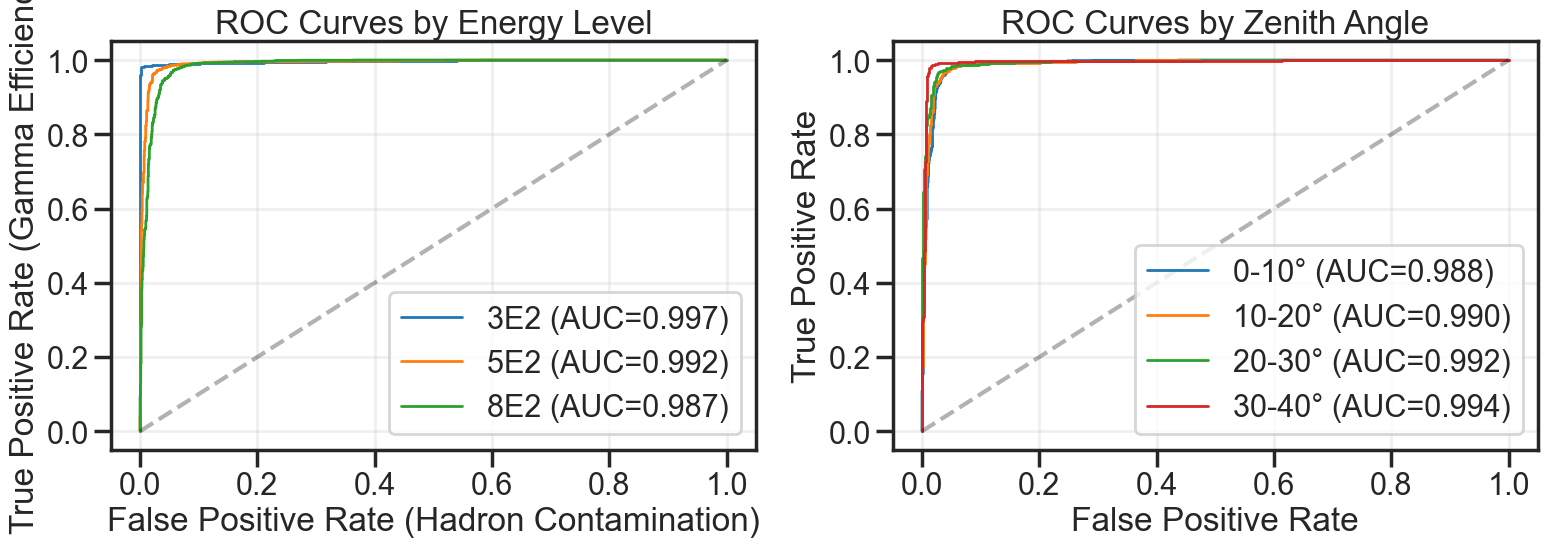

In [47]:
# Agregar después de la celda de ROC general:

# ============================================================
# ROC CURVES: STRATIFIED BY PHYSICS PARAMETERS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC por nivel de energía
ax1 = axes[0]
for energy_level in ["3E2", "5E2", "8E2"]:
    mask = pred_summary["energy_level_true"] == energy_level
    if mask.sum() > 10:
        fpr_e, tpr_e, _ = roc_curve(
            pred_summary[mask]["particle_true"],
            pred_summary[mask]["particle_pred_prob"]
        )
        auc_e = auc(fpr_e, tpr_e)
        ax1.plot(fpr_e, tpr_e, label=f'{energy_level} (AUC={auc_e:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax1.set_xlabel("False Positive Rate (Hadron Contamination)")
ax1.set_ylabel("True Positive Rate (Gamma Efficiency)")
ax1.set_title("ROC Curves by Energy Level")
ax1.legend()
ax1.grid(alpha=0.3)

# ROC por ángulo zenital
ax2 = axes[1]
angle_bins = [(0, 10), (10, 20), (20, 30), (30,40)]
for angle_min, angle_max in angle_bins:
    mask = (pred_summary["angle_true_deg"] >= angle_min) & \
           (pred_summary["angle_true_deg"] < angle_max)
    if mask.sum() > 10:
        fpr_a, tpr_a, _ = roc_curve(
            pred_summary[mask]["particle_true"],
            pred_summary[mask]["particle_pred_prob"]
        )
        auc_a = auc(fpr_a, tpr_a)
        ax2.plot(fpr_a, tpr_a, label=f'{angle_min}-{angle_max}° (AUC={auc_a:.3f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curves by Zenith Angle")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / "roc_stratified.png", dpi=200)
plt.show()

### Migration Matrices
- Energy migration (true vs reconstructed).
- Angle migration.
- Joint energy–particle migration.

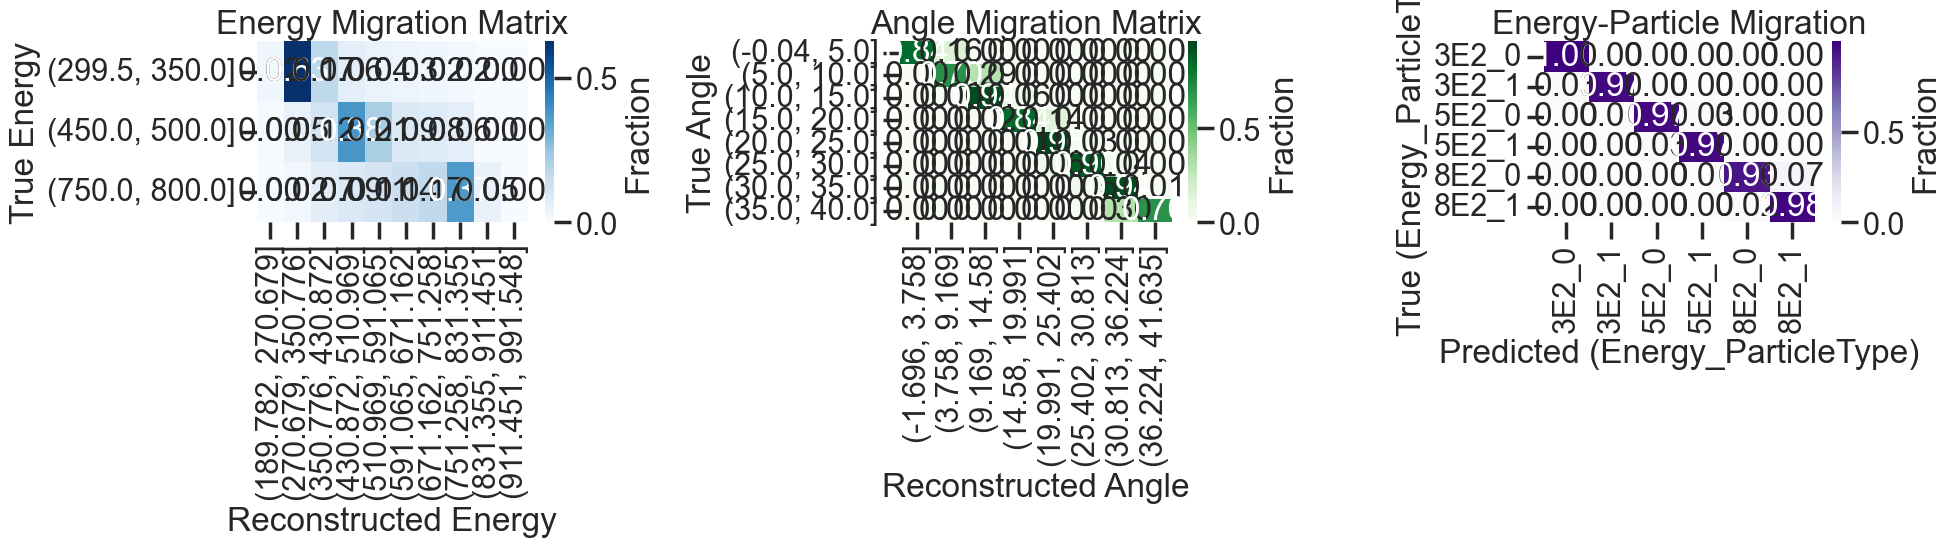

In [48]:
# ============================================================
# MIGRATION MATRICES: TRUE vs RECONSTRUCTED
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Energy Migration Matrix
energy_true_binned = pd.cut(pred_summary["energy_true_GeV"], bins=10)
energy_pred_binned = pd.cut(pred_summary["energy_pred_GeV"], bins=10)
migration_energy = pd.crosstab(energy_true_binned, energy_pred_binned, normalize='index')

sns.heatmap(migration_energy, annot=True, fmt='.2f', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Fraction'})
axes[0].set_title("Energy Migration Matrix")
axes[0].set_xlabel("Reconstructed Energy")
axes[0].set_ylabel("True Energy")

# 2. Angle Migration Matrix
angle_true_binned = pd.cut(pred_summary["angle_true_deg"], bins=8)
angle_pred_binned = pd.cut(pred_summary["angle_pred_deg"], bins=8)
migration_angle = pd.crosstab(angle_true_binned, angle_pred_binned, normalize='index')

sns.heatmap(migration_angle, annot=True, fmt='.2f', cmap='Greens', ax=axes[1], cbar_kws={'label': 'Fraction'})
axes[1].set_title("Angle Migration Matrix")
axes[1].set_xlabel("Reconstructed Angle")
axes[1].set_ylabel("True Angle")

# 3. Joint Energy-Particle Migration
energy_particle_true = pred_summary["energy_level_true"] + "_" + pred_summary["particle_true"].astype(str)
energy_particle_pred = pred_summary["energy_level_true"] + "_" + pred_summary["particle_pred_label"].astype(str)
migration_joint = pd.crosstab(energy_particle_true, energy_particle_pred, normalize='index')

sns.heatmap(migration_joint, annot=True, fmt='.2f', cmap='Purples', ax=axes[2], cbar_kws={'label': 'Fraction'})
axes[2].set_title("Energy-Particle Migration")
axes[2].set_ylabel("True (Energy_ParticleType)")
axes[2].set_xlabel("Predicted (Energy_ParticleType)")

plt.tight_layout()
plt.savefig(plots_dir / "migration_matrices.png", dpi=200)
plt.show()

### Consolidated Performance
- Summary table of primary metrics per task (AUC, PSF68, energy bias/resolution).
- Save CSV.

In [49]:
# ============================================================
# CONSOLIDATED PERFORMANCE TABLE
# ============================================================

summary_table = pd.DataFrame({
    'Task': ['Gamma/Hadron', 'Angle Reconstruction', 'Energy Estimation'],
    'Primary Metric': [
        f"AUC = {roc_auc:.4f}",
        f"PSF68 = {angle_resolution['psf_68_deg']:.2f}°",
        f"Bias = {energy_metrics['MAE (GeV)']:.1f} GeV"
    ],
    'Resolution': [
        f"Q-factor = {gh_metrics['q_factor']:.3f}",
        f"RMS = {angle_resolution['rms_deg']:.2f}°",
        f"σ/E = {(pred_summary['relative_error'].std()*100):.1f}%"
    ],
    'Efficiency/R²': [
        f"ε_γ = {gh_metrics['efficiency_gamma']:.3f}",
        f"Q-factor(<5°) = {angle_resolution['q_factor_5deg']:.3f}",
        f"R² = {energy_metrics['R2']:.4f}"
    ]
})

display(summary_table)
summary_table.to_csv(ARTIFACTS_DIR / "performance_summary.csv", index=False)

Task    Primary Metric        Resolution  \
0          Gamma/Hadron      AUC = 0.9913  Q-factor = 5.346   
1  Angle Reconstruction     PSF68 = 0.53°       RMS = 0.77°   
2     Energy Estimation  Bias = 101.0 GeV       σ/E = 32.0%   

           Efficiency/R²  
0            ε_γ = 0.974  
1  Q-factor(<5°) = 1.000  
2            R² = 0.4498

### Feature Ablation
- Zero/mean/median replacement per feature.
- Impact on particle accuracy, angle MAE, energy MAE.
- Bar plots (absolute and relative drops).
- Summary CSVs.

In [50]:
# ============================================================
# FEATURE ABLATION STUDY (Interpretabilidad Avanzada)
# ============================================================
# 
# Objetivo: Medir importancia de cada feature ELIMINÁNDOLA del modelo
# Diferencia vs PFI: 
#   - PFI: permuta valores (mantiene distribución)
#   - Ablation: reemplaza con valor neutral (mean/median/zero)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------- #
# Configuración de Ablation     #
# ----------------------------- #

ABLATION_STRATEGIES = {
    'zero': lambda feature_data: np.zeros_like(feature_data),
    'mean': lambda feature_data: np.full_like(feature_data, feature_data.mean()),
    'median': lambda feature_data: np.full_like(feature_data, np.median(feature_data)),
}

FEATURE_NAMES_ABLATION = ["detector_id", "particle_count", "t_bin", "total_energy", "x_center", "y_center"]

# ----------------------------- #
# Funciones Core                #
# ----------------------------- #

def ablate_feature(X_seq, feature_idx, strategy='mean'):
    """
    Reemplaza una feature con valor neutral.
    
    Args:
        X_seq: Array (batch, seq_len, n_features)
        feature_idx: Índice de la feature a ablacionar
        strategy: 'zero', 'mean', o 'median'
    
    Returns:
        X_ablated: Copia con feature ablacionada
    """
    X_ablated = np.array(X_seq, copy=True)
    feature_data = X_seq[:, :, feature_idx]
    
    # Aplicar estrategia de ablation
    replacement_fn = ABLATION_STRATEGIES[strategy]
    X_ablated[:, :, feature_idx] = replacement_fn(feature_data)
    
    return X_ablated

def compute_task_metric(y_true, y_pred, task_name):
    """
    Calcula métrica específica por tarea.
    """
    if task_name == 'particle':
        return accuracy_score(y_true.astype(int), (y_pred >= 0.5).astype(int))
    else:  # angle, energy
        return mean_absolute_error(y_true.astype(float), y_pred.astype(float))

def run_ablation_study(
    model, 
    X_seq, 
    X_global, 
    y_true_dict,
    strategy='mean',
    batch_size=256,
    verbose=True
):
    """
    Ejecuta estudio de ablation completo.
    
    Args:
        model: Modelo Keras entrenado
        X_seq: Secuencias de entrada (batch, seq_len, n_features)
        X_global: Features globales (batch, n_global_features)
        y_true_dict: Dict con ground truth por tarea
            {'particle': array, 'angle': array, 'energy': array}
        strategy: 'zero', 'mean', o 'median'
        batch_size: Tamaño de batch para inferencia
        verbose: Mostrar progreso
    
    Returns:
        results_df: DataFrame con resultados de ablation
    """
    
    # 1. Baseline (modelo sin ablation)
    if verbose:
        print("📊 Calculando baseline (sin ablation)...")
    
    baseline_preds = model.predict([X_seq, X_global], batch_size=batch_size, verbose=0)
    pred_particle_base, pred_angle_base, pred_energy_base = baseline_preds
    
    # Desnormalizar energía
    pred_energy_base = pred_energy_base.reshape(-1) * energy_std + energy_mean
    
    baseline_scores = {
        'particle': compute_task_metric(y_true_dict['particle'], pred_particle_base.reshape(-1), 'particle'),
        'angle': compute_task_metric(y_true_dict['angle'], pred_angle_base.reshape(-1), 'angle'),
        'energy': compute_task_metric(y_true_dict['energy'], pred_energy_base, 'energy'),
    }
    
    if verbose:
        print("\n✅ Baseline Scores:")
        for task, score in baseline_scores.items():
            print(f"   {task:12s}: {score:.4f}")
    
    # 2. Ablation por cada feature
    results = []
    
    iterator = enumerate(FEATURE_NAMES_ABLATION)
    if verbose:
        iterator = tqdm(list(iterator), desc="Ablating features")
    
    for feat_idx, feat_name in iterator:
        # Ablacionar feature
        X_ablated = ablate_feature(X_seq, feat_idx, strategy=strategy)
        
        # Predecir con modelo ablacionado
        ablated_preds = model.predict([X_ablated, X_global], batch_size=batch_size, verbose=0)
        pred_particle_abl, pred_angle_abl, pred_energy_abl = ablated_preds
        
        # Desnormalizar energía
        pred_energy_abl = pred_energy_abl.reshape(-1) * energy_std + energy_mean
        
        # Calcular scores
        ablated_scores = {
            'particle': compute_task_metric(y_true_dict['particle'], pred_particle_abl.reshape(-1), 'particle'),
            'angle': compute_task_metric(y_true_dict['angle'], pred_angle_abl.reshape(-1), 'angle'),
            'energy': compute_task_metric(y_true_dict['energy'], pred_energy_abl, 'energy'),
        }
        
        # Calcular degradación
        for task in ['particle', 'angle', 'energy']:
            baseline = baseline_scores[task]
            ablated = ablated_scores[task]
            
            # Para accuracy: baseline - ablated (mayor = más importante)
            # Para MAE: ablated - baseline (mayor = más importante)
            if task == 'particle':
                importance = baseline - ablated  # Accuracy drop
            else:
                importance = ablated - baseline  # MAE increase
            
            results.append({
                'feature': feat_name,
                'task': task,
                'strategy': strategy,
                'baseline_score': baseline,
                'ablated_score': ablated,
                'importance': importance,
                'relative_importance': (importance / baseline) * 100 if baseline != 0 else 0
            })
    
    results_df = pd.DataFrame(results)
    
    return results_df, baseline_scores

In [51]:
# ----------------------------- #
# Ejecutar Ablation Study       #
# ----------------------------- #

print("="*80)
print("🔬 FEATURE ABLATION STUDY")
print("="*80)
print(f"\nEstrategia de ablation: MEAN (reemplazar con promedio)")
print(f"Dataset: Test set ({len(X_test)} samples)")
print(f"Features analizadas: {FEATURE_NAMES_ABLATION}")

y_true_dict = {
    'particle': y_label_test,
    'angle': y_angle_test,
    'energy': y_energy_test_cont
}

# Ejecutar ablation
ablation_results, baseline_scores = run_ablation_study(
    model=model,
    X_seq=X_test,
    X_global=Xg_test,
    y_true_dict=y_true_dict,
    strategy='median',
    batch_size=256,
    verbose=True
)

🔬 FEATURE ABLATION STUDY

Estrategia de ablation: MEAN (reemplazar con promedio)
Dataset: Test set (11209 samples)
Features analizadas: ['detector_id', 'particle_count', 't_bin', 'total_energy', 'x_center', 'y_center']
📊 Calculando baseline (sin ablation)...

✅ Baseline Scores:
   particle    : 0.9703
   angle       : 0.5095
   energy      : 100.9871


Ablating features:   0%|          | 0/6 [00:00<?, ?it/s]

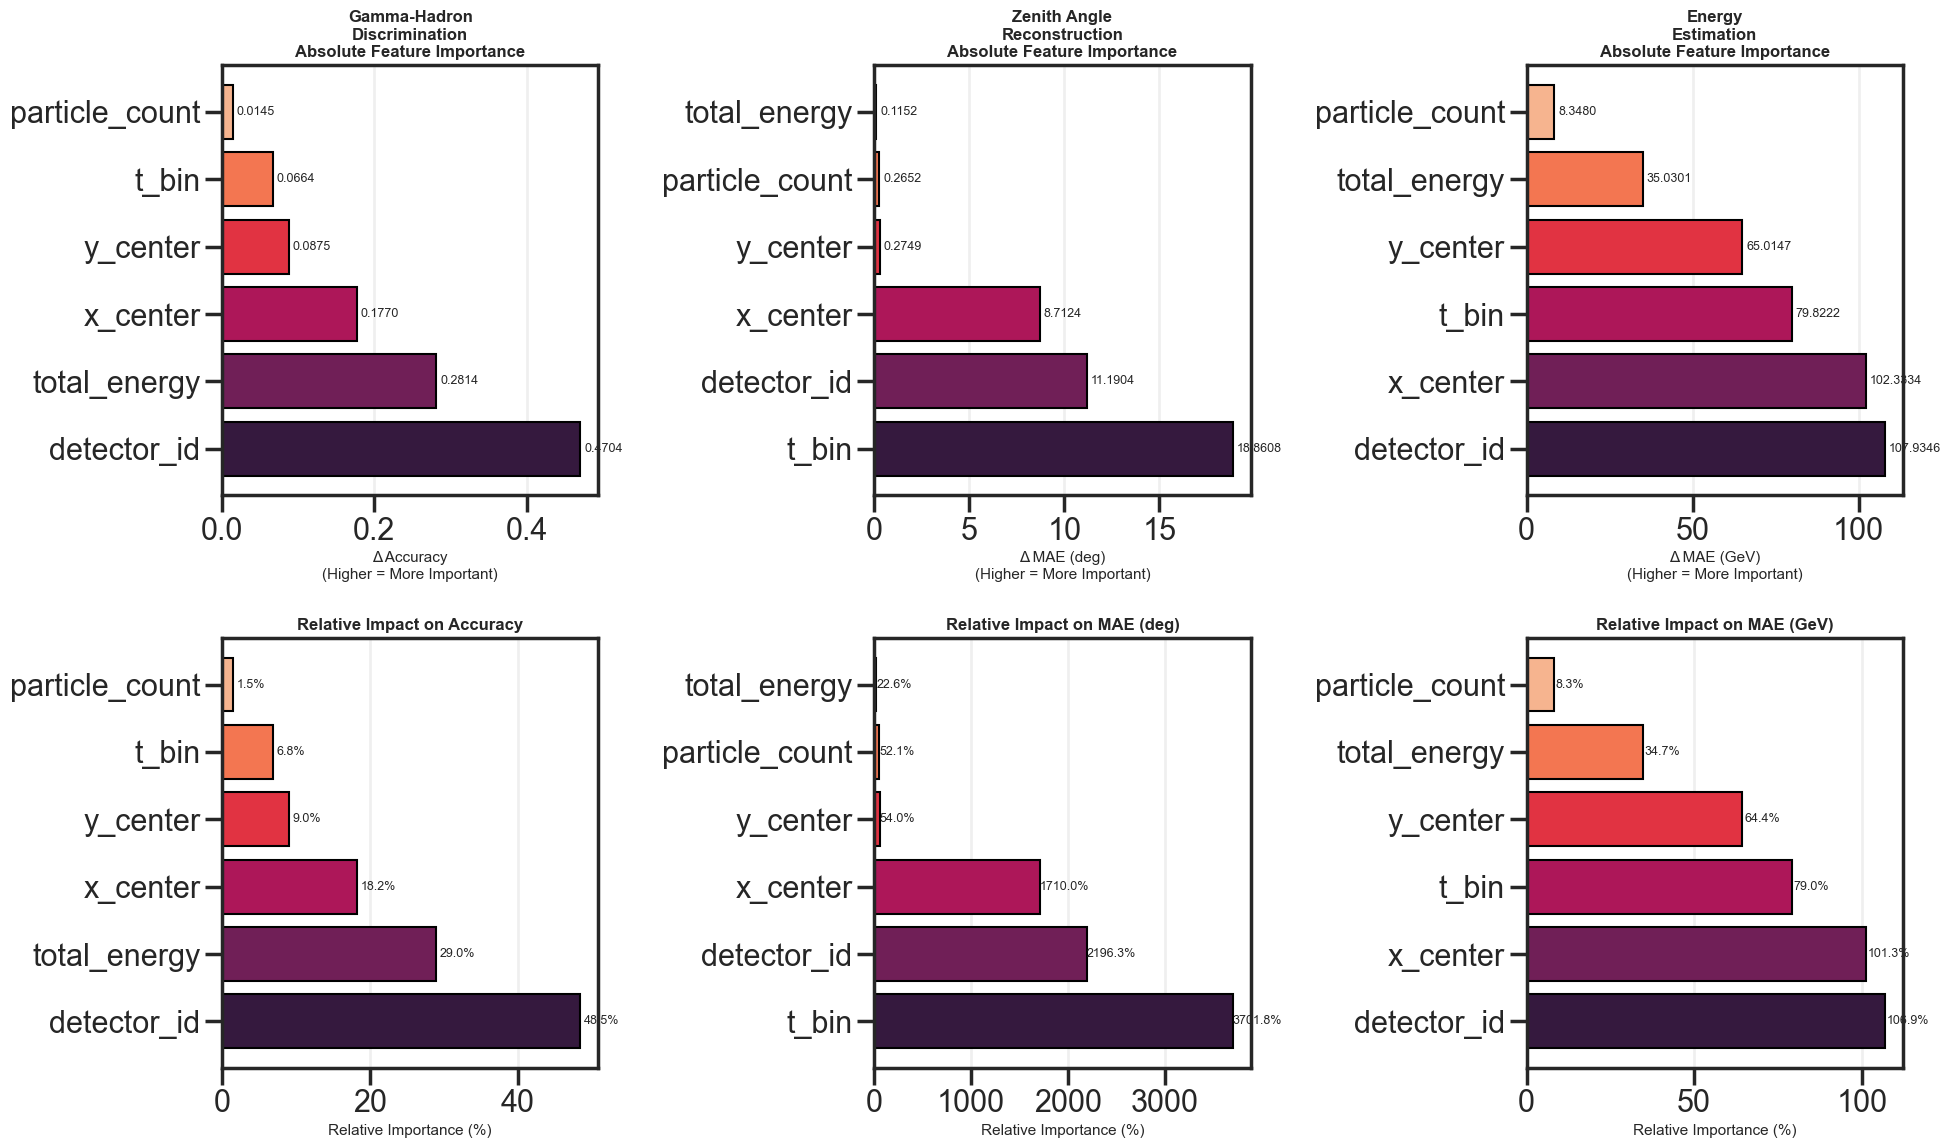

In [52]:
# ----------------------------- #
# Visualización de Resultados   #
# ----------------------------- #

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

tasks = ['particle', 'angle', 'energy']
task_titles = ['Gamma-Hadron\nDiscrimination', 'Zenith Angle\nReconstruction', 'Energy\nEstimation']
task_metrics = ['Accuracy', 'MAE (deg)', 'MAE (GeV)']

for idx, (task, title, metric_name) in enumerate(zip(tasks, task_titles, task_metrics)):
    subset = ablation_results[ablation_results['task'] == task].copy()
    subset = subset.sort_values('importance', ascending=False)
    
    # Plot 1: Importancia absoluta (fila superior)
    ax1 = axes[0, idx]
    colors = sns.color_palette("rocket", len(subset))
    bars1 = ax1.barh(subset['feature'], subset['importance'], color=colors, edgecolor='black', linewidth=1.5)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.set_xlabel(f"Δ {metric_name}\n(Higher = More Important)", fontsize=11)
    ax1.set_title(f"{title}\nAbsolute Feature Importance", fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Agregar valores sobre las barras
    for bar, val in zip(bars1, subset['importance']):
        width = bar.get_width()
        label_x = width + (0.01 * ax1.get_xlim()[1] if width > 0 else -0.01 * ax1.get_xlim()[1])
        ax1.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', ha='left' if width > 0 else 'right', va='center', fontsize=9)
    
    # Plot 2: Importancia relativa (fila inferior)
    ax2 = axes[1, idx]
    bars2 = ax2.barh(subset['feature'], subset['relative_importance'], color=colors, edgecolor='black', linewidth=1.5)
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.set_xlabel("Relative Importance (%)", fontsize=11)
    ax2.set_title(f"Relative Impact on {metric_name}", fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Agregar valores sobre las barras
    for bar, val in zip(bars2, subset['relative_importance']):
        width = bar.get_width()
        label_x = width + (0.5 if width > 0 else -0.5)
        ax2.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{val:.1f}%', ha='left' if width > 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(plots_dir / "feature_ablation_study.png", dpi=200, bbox_inches="tight")
plt.show()

In [53]:
# ----------------------------- #
# Tabla Resumen                 #
# ----------------------------- #

print("\n" + "="*80)
print("📋 FEATURE ABLATION SUMMARY")
print("="*80)

pivot_table = ablation_results.pivot_table(
    index='feature',
    columns='task',
    values='importance',
    aggfunc='mean'
).round(4)

# Agregar ranking por tarea
pivot_table['rank_particle'] = pivot_table['particle'].rank(ascending=False)
pivot_table['rank_angle'] = pivot_table['angle'].rank(ascending=False)
pivot_table['rank_energy'] = pivot_table['energy'].rank(ascending=False)

# Calcular importancia promedio
pivot_table['avg_importance'] = pivot_table[['particle', 'angle', 'energy']].mean(axis=1)
pivot_table = pivot_table.sort_values('avg_importance', ascending=False)

display(pivot_table)

# Guardar resultados
ablation_results.to_csv(ARTIFACTS_DIR / "diagnostics" / "feature_ablation_results.csv", index=False)
pivot_table.to_csv(ARTIFACTS_DIR / "diagnostics" / "feature_ablation_summary.csv")

print(f"\n✅ Resultados guardados en:")
print(f"   - {ARTIFACTS_DIR / 'diagnostics' / 'feature_ablation_results.csv'}")
print(f"   - {ARTIFACTS_DIR / 'diagnostics' / 'feature_ablation_summary.csv'}")


📋 FEATURE ABLATION SUMMARY


task              angle    energy  particle  rank_particle  rank_angle  \
feature                                                                  
detector_id     11.1904  107.9346    0.4704            1.0         2.0   
x_center         8.7124  102.3334    0.1770            3.0         3.0   
t_bin           18.8608   79.8222    0.0664            5.0         1.0   
y_center         0.2749   65.0147    0.0875            4.0         4.0   
total_energy     0.1152   35.0301    0.2814            2.0         6.0   
particle_count   0.2652    8.3480    0.0145            6.0         5.0   

task            rank_energy  avg_importance  
feature                                      
detector_id             1.0       39.865133  
x_center                2.0       37.074267  
t_bin                   3.0       32.916467  
y_center                4.0       21.792367  
total_energy            5.0       11.808900  
particle_count          6.0        2.875900


✅ Resultados guardados en:
   - C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\feature_ablation_results.csv
   - C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\feature_ablation_summary.csv


In [54]:
# ----------------------------- #
# Insights Físicos              #
# ----------------------------- #

print("\n" + "="*80)
print("💡 PHYSICAL INSIGHTS FROM ABLATION")
print("="*80)

# Top 3 features por tarea
for task, title in zip(tasks, task_titles):
    top3 = ablation_results[ablation_results['task'] == task].nlargest(3, 'importance')
    print(f"\n{title}:")
    for i, row in enumerate(top3.itertuples(), 1):
        print(f"   {i}. {row.feature:15s}: Importance = {row.importance:.4f} ({row.relative_importance:+.1f}%)")

# Análisis de dependencias cruzadas
print("\n\n🔗 CROSS-TASK FEATURE IMPORTANCE:")
cross_task_importance = ablation_results.groupby('feature')['importance'].agg(['mean', 'std', 'min', 'max']).round(4)
cross_task_importance = cross_task_importance.sort_values('mean', ascending=False)
display(cross_task_importance)

print("\n" + "="*80)


💡 PHYSICAL INSIGHTS FROM ABLATION

Gamma-Hadron
Discrimination:
   1. detector_id    : Importance = 0.4704 (+48.5%)
   2. total_energy   : Importance = 0.2814 (+29.0%)
   3. x_center       : Importance = 0.1770 (+18.2%)

Zenith Angle
Reconstruction:
   1. t_bin          : Importance = 18.8608 (+3701.8%)
   2. detector_id    : Importance = 11.1904 (+2196.3%)
   3. x_center       : Importance = 8.7124 (+1710.0%)

Energy
Estimation:
   1. detector_id    : Importance = 107.9346 (+106.9%)
   2. x_center       : Importance = 102.3334 (+101.3%)
   3. t_bin          : Importance = 79.8222 (+79.0%)


🔗 CROSS-TASK FEATURE IMPORTANCE:


mean      std     min       max
feature                                           
detector_id     39.8651  59.1931  0.4704  107.9346
x_center        37.0743  56.6769  0.1770  102.3334
t_bin           32.9165  41.6944  0.0664   79.8222
y_center        21.7924  37.4317  0.0875   65.0147
total_energy    11.8089  20.1103  0.1152   35.0301
particle_count   2.8759   4.7406  0.0145    8.3480

### Permutation Feature Importance
- Per-sequence feature PFI across all heads.
- Triptych bar plots per task.
- Save CSV and figures.

In [55]:
# Permutation Feature Importance solo con features secuenciales
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error

OUTPUT_SPECS = {
    "particle": {
        "metric_name": "accuracy",
        "metric": lambda pred: accuracy_score(y_label_test.astype(int), (pred >= 0.5).astype(int)),
        "higher_is_better": True,
    },
    "angle": {
        "metric_name": "MAE_deg",
        "metric": lambda pred: mean_absolute_error(y_angle_test.astype(float), pred.astype(float)),
        "higher_is_better": False,
    },
    "energy": {
        "metric_name": "MAE_GeV",
        "metric": lambda pred: mean_absolute_error(y_energy_test_cont.astype(float), pred.astype(float)),
        "higher_is_better": False,
    },
}

def _predict_all_heads(seq_input, global_input, batch_size=256):
    head_particle, head_angle, head_energy_scaled = model.predict(
        [seq_input, global_input], batch_size=batch_size, verbose=0
    )
    head_particle = head_particle.reshape(-1)
    head_angle = head_angle.reshape(-1)
    head_energy = head_energy_scaled.reshape(-1) * energy_std + energy_mean
    return {"particle": head_particle, "angle": head_angle, "energy": head_energy}

def _permute_sequence_feature(seq_data, feat_idx, rng):
    permuted = np.array(seq_data, copy=True)
    feature_view = permuted[:, :, feat_idx]
    for t_idx in range(feature_view.shape[1]):
        feature_view[:, t_idx] = rng.permutation(feature_view[:, t_idx])
    permuted[:, :, feat_idx] = feature_view
    return permuted

def compute_pfi_sequence_features(
    model,
    X_seq,
    X_global,
    *,
    n_repeats=8,
    random_state=42,
    batch_size=256,
):
    rng_master = np.random.default_rng(random_state)
    baseline_preds = _predict_all_heads(X_seq, X_global, batch_size=batch_size)
    baseline_scores = {
        task: spec["metric"](baseline_preds[task]) for task, spec in OUTPUT_SPECS.items()
    }

    records = []
    for feat_idx, feat_name in enumerate(FEATURE_NAMES):
        task_scores = {task: [] for task in OUTPUT_SPECS}
        for _ in range(n_repeats):
            rng = np.random.default_rng(rng_master.integers(0, 2**32 - 1))
            X_perm = _permute_sequence_feature(X_seq, feat_idx, rng)
            perm_preds = _predict_all_heads(X_perm, X_global, batch_size=batch_size)
            for task, spec in OUTPUT_SPECS.items():
                task_scores[task].append(spec["metric"](perm_preds[task]))

        for task, scores in task_scores.items():
            scores = np.asarray(scores, dtype=float)
            baseline = baseline_scores[task]
            mean_score = float(scores.mean())
            std_score = float(scores.std(ddof=1))
            delta = baseline - mean_score if OUTPUT_SPECS[task]["higher_is_better"] else mean_score - baseline
            records.append(
                {
                    "feature": f"sequence::{feat_name}",
                    "task": task,
                    "metric_name": OUTPUT_SPECS[task]["metric_name"],
                    "baseline": baseline,
                    "permuted_mean": mean_score,
                    "permuted_std": std_score,
                    "importance_delta": delta,
                }
            )

    results = (
        pd.DataFrame(records)
        .sort_values(["task", "importance_delta"], ascending=[True, False])
        .reset_index(drop=True)
    )
    return baseline_scores, results

baseline_scores, pfi_results = compute_pfi_sequence_features(
    model,
    X_test,
    Xg_test,
    n_repeats=8,
    random_state=42,
    batch_size=256,
)

print("Baseline metrics por head:")
for task, value in baseline_scores.items():
    print(f"  {task}: {value:.4f}")

display(pfi_results)
pfi_results.to_csv(ARTIFACTS_DIR / "diagnostics" / "pfi_all_heads_sequence_only.csv", index=False)

Baseline metrics por head:
  particle: 0.9703
  angle: 0.5095
  energy: 100.9871


feature      task metric_name    baseline  permuted_mean  \
0            sequence::t_bin     angle     MAE_deg    0.509505      14.943200   
1         sequence::x_center     angle     MAE_deg    0.509505      14.221460   
2      sequence::detector_id     angle     MAE_deg    0.509505       9.162174   
3         sequence::y_center     angle     MAE_deg    0.509505       6.821787   
4     sequence::total_energy     angle     MAE_deg    0.509505       3.740729   
5   sequence::particle_count     angle     MAE_deg    0.509505       2.047870   
6         sequence::x_center    energy     MAE_GeV  100.987098     167.610558   
7      sequence::detector_id    energy     MAE_GeV  100.987098     166.970583   
8            sequence::t_bin    energy     MAE_GeV  100.987098     166.372285   
9         sequence::y_center    energy     MAE_GeV  100.987098     163.777075   
10    sequence::total_energy    energy     MAE_GeV  100.987098     163.385918   
11  sequence::particle_count    energy     MAE_GeV  100.987098     129.235480   
12        sequence::x_center  particle    accuracy    0.970292       0.521489   
13        sequence::y_center  particle    accuracy    0.970292       0.557911   
14    sequence::total_energy  particle    accuracy    0.970292       0.565282   
15     sequence::detector_id  particle    accuracy    0.970292       0.684305   
16           sequence::t_bin  particle    accuracy    0.970292       0.709062   
17  sequence::particle_count  particle    accuracy    0.970292       0.829155   

    permuted_std  importance_delta  
0       0.009824         14.433694  
1       0.013322         13.711955  
2       0.019161          8.652669  
3       0.015770          6.312282  
4       0.009309          3.231223  
5       0.001076          1.538365  
6       0.456213         66.623461  
7       0.651790         65.983485  
8       0.616102         65.385187  
9       0.237487         62.789978  
10      0.498875         62.398820  
11      0.307221         28.248382  
12      0.001365          0.448802  
13      0.000964          0.412381  
14      0.002274          0.405009  
15      0.003333          0.285987  
16      0.003606          0.261230  
17      0.001289          0.141137

C:\Users\Froxo\AppData\Local\Temp\ipykernel_4524\3754146337.py:48: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28, wspace=0.25)


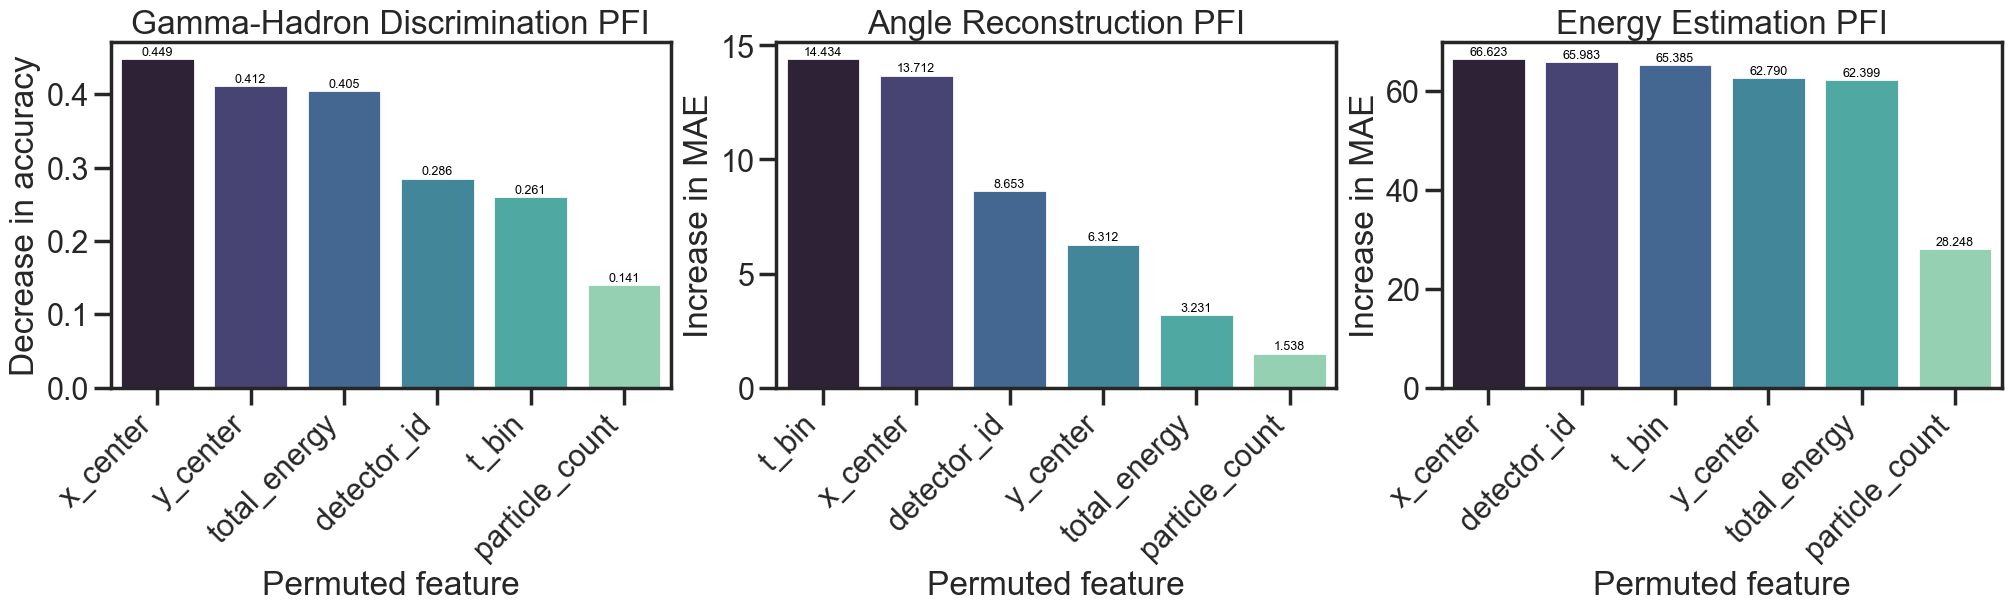

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def _friendly_feature_name(raw_name: str) -> str:
    return raw_name.split("::", 1)[-1]

def plot_pfi_triptych(pfi_results, top_n=None, output_path=None):
    tasks_order = [
        ("particle", "Gamma-Hadron Discrimination PFI", "Decrease in accuracy"),
        ("angle", "Angle Reconstruction PFI", "Increase in MAE"),
        ("energy", "Energy Estimation PFI", "Increase in MAE"),
    ]
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
    sns.set_style("whitegrid")

    for ax, (task, title, ylabel) in zip(axes, tasks_order):
        subset = pfi_results[pfi_results["task"] == task].copy()
        subset = subset.sort_values("importance_delta", ascending=False)
        if top_n is not None:
            subset = subset.head(top_n)

        subset["feature_pretty"] = subset["feature"].apply(_friendly_feature_name)
        sns.barplot(
            data=subset,
            x="feature_pretty",
            y="importance_delta",
            hue="feature_pretty",
            palette="mako",
            ax=ax,
            legend=False,
        )
        ax.set_title(title)
        ax.set_xlabel("Permuted feature")
        ax.set_ylabel(ylabel)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        for bar_idx, (_, row) in enumerate(subset.iterrows()):
            ax.text(
                bar_idx,
                row["importance_delta"],
                f"{row['importance_delta']:.3f}",
                ha="center",
                va="bottom" if row["importance_delta"] >= 0 else "top",
                fontsize=9,
                color="black",
            )

    fig.subplots_adjust(bottom=0.28, wspace=0.25)

    if output_path is not None:
        fig.savefig(output_path, dpi=200, bbox_inches="tight")
    plt.show()

plot_pfi_triptych(
    pfi_results,
    top_n=None,
    output_path=ARTIFACTS_DIR / "diagnostics" / "permutation_importance_all_tasks.png",
)

### Attention Maps
- Auxiliary model to extract attention (class/angle/energy heads).
- Average attention heatmaps with padding masks.

In [62]:
# ===========================
# Modelo auxiliar de atención
# ===========================
print("Creando modelo auxiliar (CNN + RAW) para extraer attention scores...")

# Capas MHA (CNN)
mha_class_cnn = model.get_layer("mha_class_cnn")
mha_angle_cnn = model.get_layer("mha_angle_cnn")
mha_energy_cnn = model.get_layer("mha_energy_cnn")

# Capas MHA (RAW)
mha_class_raw = model.get_layer("mha_class_raw")
mha_angle_raw = model.get_layer("mha_angle_raw")
mha_energy_raw = model.get_layer("mha_energy_raw")

# Entradas normalizadas (CNN)
pre_mha_class_cnn = model.get_layer("pre_mha_norm_class_cnn").output
pre_mha_angle_cnn = model.get_layer("pre_mha_norm_angle_cnn").output
pre_mha_energy_cnn = model.get_layer("pre_mha_norm_energy_cnn").output

# Entradas normalizadas (RAW)
pre_mha_class_raw = model.get_layer("pre_mha_norm_class_raw").output
pre_mha_angle_raw = model.get_layer("pre_mha_norm_angle_raw").output
pre_mha_energy_raw = model.get_layer("pre_mha_norm_energy_raw").output

# Llamadas con return_attention_scores=True
_, attn_class_cnn = mha_class_cnn(pre_mha_class_cnn, pre_mha_class_cnn, return_attention_scores=True)
_, attn_angle_cnn = mha_angle_cnn(pre_mha_angle_cnn, pre_mha_angle_cnn, return_attention_scores=True)
_, attn_energy_cnn = mha_energy_cnn(pre_mha_energy_cnn, pre_mha_energy_cnn, return_attention_scores=True)

_, attn_class_raw = mha_class_raw(pre_mha_class_raw, pre_mha_class_raw, return_attention_scores=True)
_, attn_angle_raw = mha_angle_raw(pre_mha_angle_raw, pre_mha_angle_raw, return_attention_scores=True)
_, attn_energy_raw = mha_energy_raw(pre_mha_energy_raw, pre_mha_energy_raw, return_attention_scores=True)

# Modelo auxiliar con las 6 atenciones
attention_model = Model(
    inputs=model.inputs,
    outputs=[
        attn_class_cnn, attn_angle_cnn, attn_energy_cnn,
        attn_class_raw, attn_angle_raw, attn_energy_raw,
    ],
    name="CONDOR_AttentionExtractor"
)

print("✓ Modelo de atención (CNN+RAW) creado")

Creando modelo auxiliar (CNN + RAW) para extraer attention scores...
✓ Modelo de atención (CNN+RAW) creado


Extrayendo attention scores de 200 muestras...
50/50 [==============================] - 31s 606ms/step
Shapes CNN: (200, 1, 236, 236) (200, 1, 236, 236) (200, 1, 236, 236)
Shapes RAW: (200, 1, 472, 472) (200, 1, 472, 472) (200, 1, 472, 472)


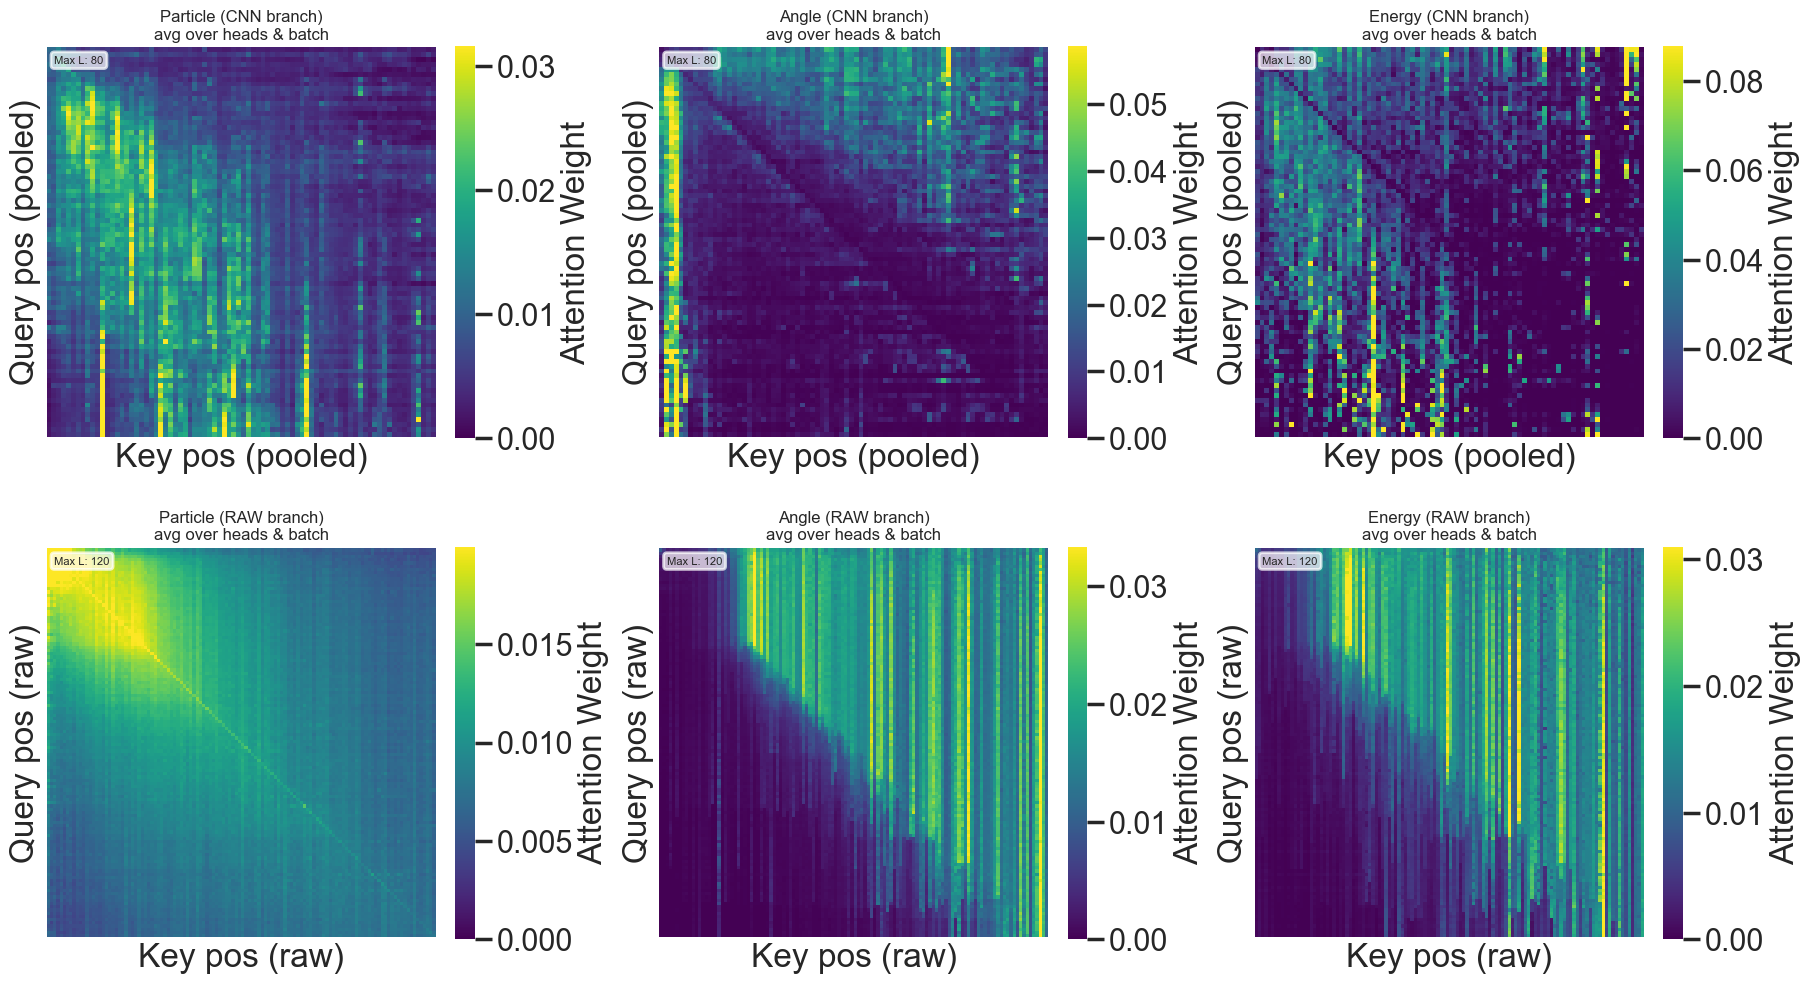

✓ Patrones de atención (CNN vs RAW) guardados en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_patterns_cnn_vs_raw.png


In [68]:
# =======================================================
# Extracción y visualización: atención CNN vs atención RAW
# =======================================================
sample_size = min(200, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_indices]
Xg_sample = Xg_test[sample_indices]

print(f"Extrayendo attention scores de {sample_size} muestras...")
with tf.device('/CPU:0'):
    (
        attn_class_cnn_scores,
        attn_angle_cnn_scores,
        attn_energy_cnn_scores,
        attn_class_raw_scores,
        attn_angle_raw_scores,
        attn_energy_raw_scores,
    ) = attention_model.predict([X_sample, Xg_sample], batch_size=4, verbose=1)

print("Shapes CNN:", attn_class_cnn_scores.shape, attn_angle_cnn_scores.shape, attn_energy_cnn_scores.shape)
print("Shapes RAW:", attn_class_raw_scores.shape, attn_angle_raw_scores.shape, attn_energy_raw_scores.shape)

# Máscaras de padding (longitud real en espacio RAW)
valid_masks_raw = ~np.all(np.isclose(X_sample, 0.0, atol=1e-8), axis=-1)
valid_lengths_raw = valid_masks_raw.sum(axis=-1)  # (batch,)

def average_attention(attn_scores, valid_lengths, max_len=100, pool_factor=1):
    """
    Promedia matrices de atención (batch, heads?, L, L) respetando padding.
    pool_factor=2 para ramas CNN (por MaxPool1D), 1 para RAW.
    """
    if attn_scores.ndim == 4:  # (batch, heads, L, L)
        attn_scores = attn_scores.mean(axis=1)
    batch, L_attn, _ = attn_scores.shape
    max_len = min(max_len, L_attn)
    attn_avg = np.zeros((max_len, max_len))
    count = np.zeros((max_len, max_len))
    for i in range(batch):
        L_eff = int(np.ceil(valid_lengths[i] / pool_factor))
        L_eff = max(0, min(L_eff, L_attn, max_len))
        if L_eff == 0:
            continue
        attn_avg[:L_eff, :L_eff] += attn_scores[i, :L_eff, :L_eff]
        count[:L_eff, :L_eff] += 1
    attn_avg = np.divide(attn_avg, count, where=count > 0)
    attn_avg[count == 0] = np.nan
    return attn_avg

# Promedios
avg_maps = {
    ("CNN", "Particle"): average_attention(attn_class_cnn_scores, valid_lengths_raw, max_len=80, pool_factor=2),
    ("CNN", "Angle"):    average_attention(attn_angle_cnn_scores, valid_lengths_raw, max_len=80, pool_factor=2),
    ("CNN", "Energy"):   average_attention(attn_energy_cnn_scores, valid_lengths_raw, max_len=80, pool_factor=2),
    ("RAW", "Particle"): average_attention(attn_class_raw_scores, valid_lengths_raw, max_len=120, pool_factor=1),
    ("RAW", "Angle"):    average_attention(attn_angle_raw_scores, valid_lengths_raw, max_len=120, pool_factor=1),
    ("RAW", "Energy"):   average_attention(attn_energy_raw_scores, valid_lengths_raw, max_len=120, pool_factor=1),
}

# Figura 2x3: fila CNN, fila RAW
task_order = ["Particle", "Angle", "Energy"]
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
for col, task in enumerate(task_order):
    # CNN
    ax = axes[0, col]
    m = avg_maps[("CNN", task)]
    vmax = np.nanpercentile(m, 99)
    sns.heatmap(
        m, cmap="viridis", square=True, ax=ax, vmin=0, vmax=vmax,
        cbar_kws={"label": "Attention Weight", "shrink": 0.8},
        xticklabels=False, yticklabels=False,
    )
    ax.set_title(f"{task} (CNN branch)\navg over heads & batch", fontsize=12)
    ax.set_xlabel("Key pos (pooled)")
    ax.set_ylabel("Query pos (pooled)")
    ax.text(0.02, 0.98, f"Max L: {m.shape[0]}", transform=ax.transAxes,
            va="top", ha="left", fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

    # RAW
    ax = axes[1, col]
    m = avg_maps[("RAW", task)]
    vmax = np.nanpercentile(m, 99)
    sns.heatmap(
        m, cmap="viridis", square=True, ax=ax, vmin=0, vmax=vmax,
        cbar_kws={"label": "Attention Weight", "shrink": 0.8},
        xticklabels=False, yticklabels=False,
    )
    ax.set_title(f"{task} (RAW branch)\navg over heads & batch", fontsize=12)
    ax.set_xlabel("Key pos (raw)")
    ax.set_ylabel("Query pos (raw)")
    ax.text(0.02, 0.98, f"Max L: {m.shape[0]}", transform=ax.transAxes,
            va="top", ha="left", fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.savefig(plots_dir / "attention_patterns_cnn_vs_raw.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Patrones de atención (CNN vs RAW) guardados en: {plots_dir / 'attention_patterns_cnn_vs_raw.png'}")

### Attention vs Performance
- Compare attention for correct vs incorrect (or best/worst quartiles).
- Difference heatmaps and marginal distributions.

ANÁLISIS AVANZADO DE INTERPRETABILIDAD DE ATENCIÓN

1. Separando patrones por performance del modelo...


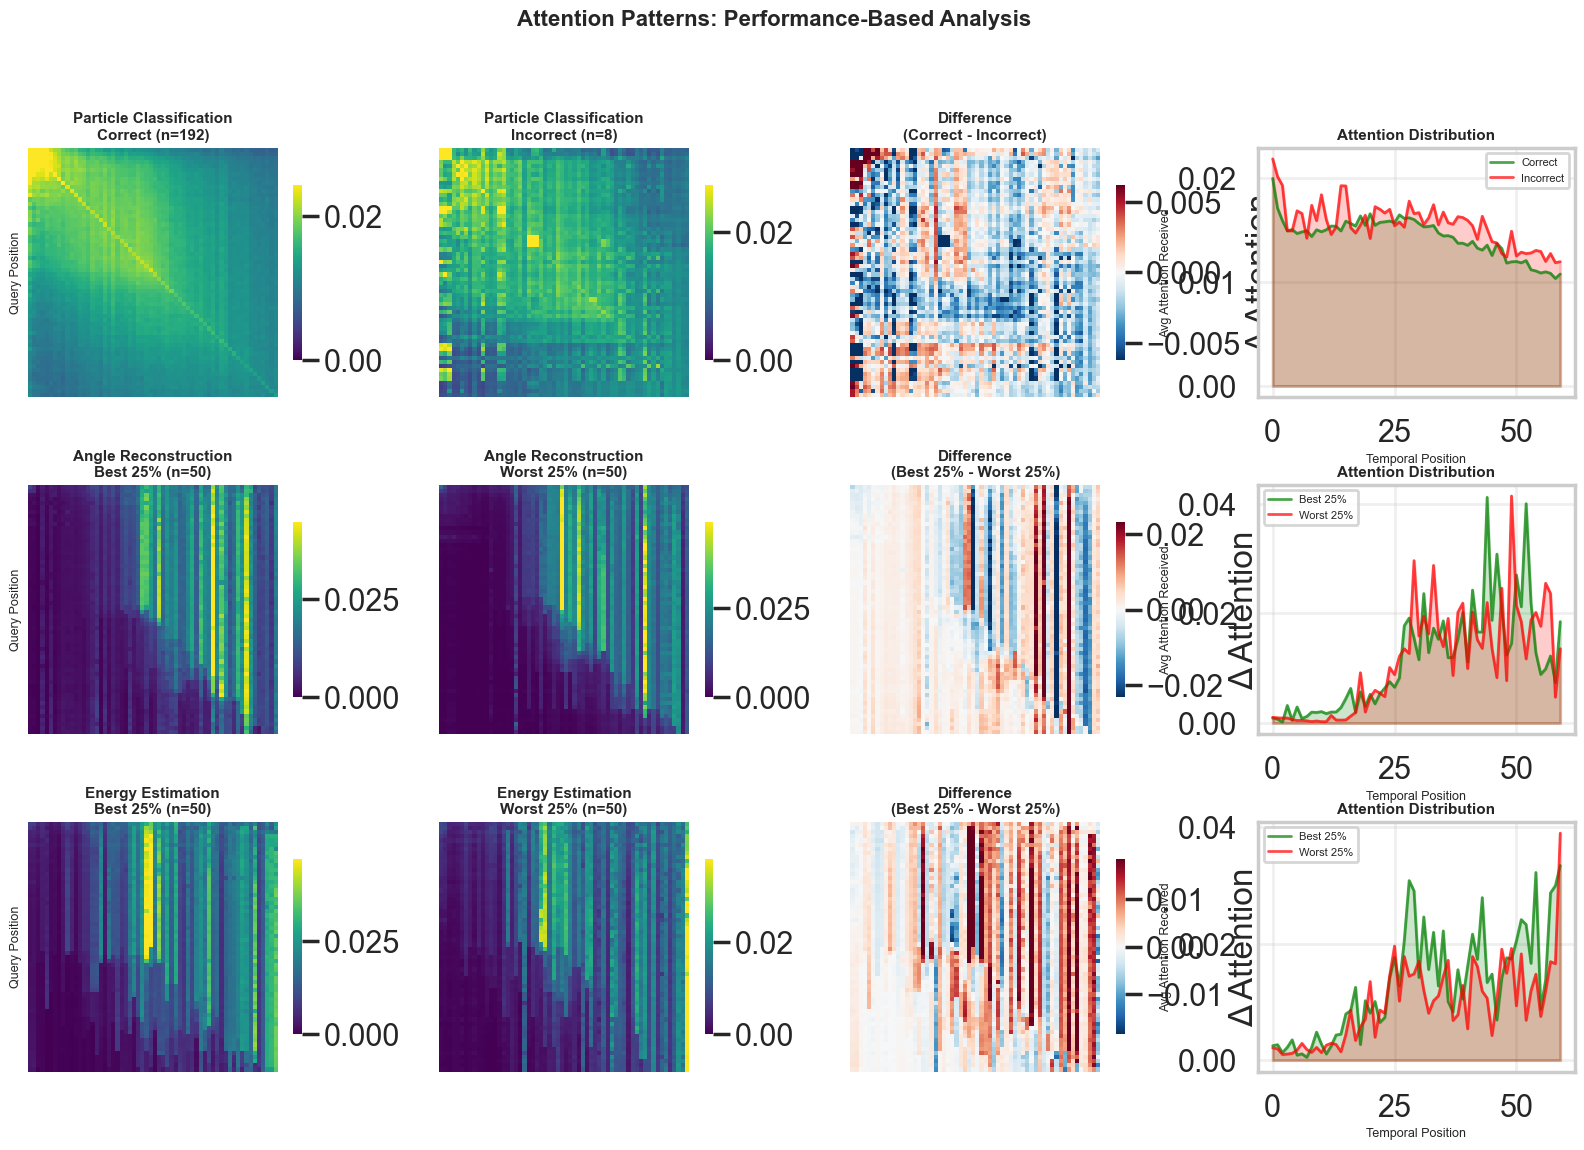

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_performance_comparison.png


In [70]:
# ----------------------------------------- #
# Análisis Avanzado de Patrones de Atención #
# ----------------------------------------- #

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

print("="*60)
print("ANÁLISIS AVANZADO DE INTERPRETABILIDAD DE ATENCIÓN")
print("="*60)

# Usaremos las atenciones RAW (sin pooling) para evitar ambigüedad de longitudes
attn_class_scores = attn_class_raw_scores
attn_angle_scores = attn_angle_raw_scores
attn_energy_scores = attn_energy_raw_scores
valid_lengths = valid_lengths_raw  # longitudes reales en espacio RAW

# 1. ANÁLISIS POR PERFORMANCE: Predicciones correctas vs incorrectas
# ----------------------------- #
print("\n1. Separando patrones por performance del modelo...")

# Definir subgrupos de performance
particle_correct_mask = pred_summary["particle_correct"].values[sample_indices]
angle_error = pred_summary["angle_abs_error_deg"].values[sample_indices]
energy_error = pred_summary["energy_abs_error_GeV"].values[sample_indices]

# Usar np.quantile en lugar de .quantile()
angle_good_mask = angle_error <= np.quantile(angle_error, 0.25)  # Mejor 25%
angle_bad_mask = angle_error >= np.quantile(angle_error, 0.75)   # Peor 25%

energy_good_mask = energy_error <= np.quantile(energy_error, 0.25)
energy_bad_mask = energy_error >= np.quantile(energy_error, 0.75)

# Comparar patrones de atención: buenas vs malas predicciones
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 4, figure=fig, hspace=0.35, wspace=0.3)

task_comparisons = [
    ("Particle Classification", attn_class_scores, particle_correct_mask, ~particle_correct_mask, "Correct", "Incorrect"),
    ("Angle Reconstruction", attn_angle_scores, angle_good_mask, angle_bad_mask, "Best 25%", "Worst 25%"),
    ("Energy Estimation", attn_energy_scores, energy_good_mask, energy_bad_mask, "Best 25%", "Worst 25%"),
]

for row_idx, (task_name, attn_scores, good_mask, bad_mask, good_label, bad_label) in enumerate(task_comparisons):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores
    max_len = 60

    # Patrón promedio para predicciones BUENAS
    attn_good = np.zeros((max_len, max_len))
    count_good = np.zeros((max_len, max_len))
    for idx in np.where(good_mask)[0]:
        L = min(int(valid_lengths[idx]), max_len)
        if L > 0:
            attn_good[:L, :L] += attn_3d[idx, :L, :L]
            count_good[:L, :L] += 1
    attn_good = np.divide(attn_good, count_good, where=count_good > 0)
    attn_good[count_good == 0] = np.nan

    # Patrón promedio para predicciones MALAS
    attn_bad = np.zeros((max_len, max_len))
    count_bad = np.zeros((max_len, max_len))
    for idx in np.where(bad_mask)[0]:
        L = min(int(valid_lengths[idx]), max_len)
        if L > 0:
            attn_bad[:L, :L] += attn_3d[idx, :L, :L]
            count_bad[:L, :L] += 1
    attn_bad = np.divide(attn_bad, count_bad, where=count_bad > 0)
    attn_bad[count_bad == 0] = np.nan

    # DIFERENCIA entre buenos y malos
    attn_diff = attn_good - attn_bad

    # Plot 1: Predicciones BUENAS
    ax1 = fig.add_subplot(gs[row_idx, 0])
    vmax_good = np.nanpercentile(attn_good, 99) if np.isfinite(attn_good).any() else 1.0
    sns.heatmap(attn_good, cmap="viridis", square=True, cbar=True, ax=ax1,
                vmin=0, vmax=vmax_good,
                cbar_kws={"shrink": 0.7}, xticklabels=False, yticklabels=False)
    ax1.set_title(f"{task_name}\n{good_label} (n={good_mask.sum()})", fontweight="bold", fontsize=11)
    ax1.set_ylabel("Query Position", fontsize=9)

    # Plot 2: Predicciones MALAS
    ax2 = fig.add_subplot(gs[row_idx, 1])
    vmax_bad = np.nanpercentile(attn_bad, 99) if np.isfinite(attn_bad).any() else 1.0
    sns.heatmap(attn_bad, cmap="viridis", square=True, cbar=True, ax=ax2,
                vmin=0, vmax=vmax_bad,
                cbar_kws={"shrink": 0.7}, xticklabels=False, yticklabels=False)
    ax2.set_title(f"{task_name}\n{bad_label} (n={bad_mask.sum()})", fontweight="bold", fontsize=11)

    # Plot 3: DIFERENCIA (Good - Bad)
    ax3 = fig.add_subplot(gs[row_idx, 2])
    vmax_diff = np.nanpercentile(np.abs(attn_diff), 95) if np.isfinite(attn_diff).any() else 1.0
    sns.heatmap(attn_diff, cmap="RdBu_r", center=0, square=True, cbar=True, ax=ax3,
                vmin=-vmax_diff, vmax=vmax_diff,
                cbar_kws={"shrink": 0.7, "label": "Δ Attention"},
                xticklabels=False, yticklabels=False)
    ax3.set_title(f"Difference\n({good_label} - {bad_label})", fontweight="bold", fontsize=11)

    # Plot 4: Distribución de atención por posición (marginal)
    ax4 = fig.add_subplot(gs[row_idx, 3])
    attn_received_good = np.nanmean(attn_good, axis=0)[:max_len]
    attn_received_bad = np.nanmean(attn_bad, axis=0)[:max_len]

    positions = np.arange(len(attn_received_good))
    ax4.plot(positions, attn_received_good, label=good_label, color='green', linewidth=2, alpha=0.7)
    ax4.plot(positions, attn_received_bad, label=bad_label, color='red', linewidth=2, alpha=0.7)
    ax4.fill_between(positions, attn_received_good, alpha=0.2, color='green')
    ax4.fill_between(positions, attn_received_bad, alpha=0.2, color='red')
    ax4.set_xlabel("Temporal Position", fontsize=9)
    ax4.set_ylabel("Avg Attention Received", fontsize=9)
    ax4.set_title("Attention Distribution", fontweight="bold", fontsize=11)
    ax4.legend(fontsize=8)
    ax4.grid(alpha=0.3)

plt.suptitle("Attention Patterns: Performance-Based Analysis", fontsize=16, fontweight="bold", y=0.995)
plt.savefig(plots_dir / "attention_performance_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_performance_comparison.png'}")

### Temporal Attention Patterns
- Early/Mid/Late attention distributions.
- Attention entropy; self vs context (diagonal/off-diagonal).


2. Analizando importancia temporal de las posiciones...


C:\Users\Froxo\AppData\Local\Temp\ipykernel_4524\722521776.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([early_attn, mid_attn, late_attn],
C:\Users\Froxo\AppData\Local\Temp\ipykernel_4524\722521776.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([early_attn, mid_attn, late_attn],
C:\Users\Froxo\AppData\Local\Temp\ipykernel_4524\722521776.py:61: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(row_norm * np.log(row_norm + 1e-12))
C:\Users\Froxo\AppData\Local\Temp\ipykernel_4524\722521776.py:61: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(row_norm * np.log(row_norm + 1e-12))
C:\Users\Froxo\AppData\Local\Temp\ipykernel_4524\722521776.py:40: Matplo

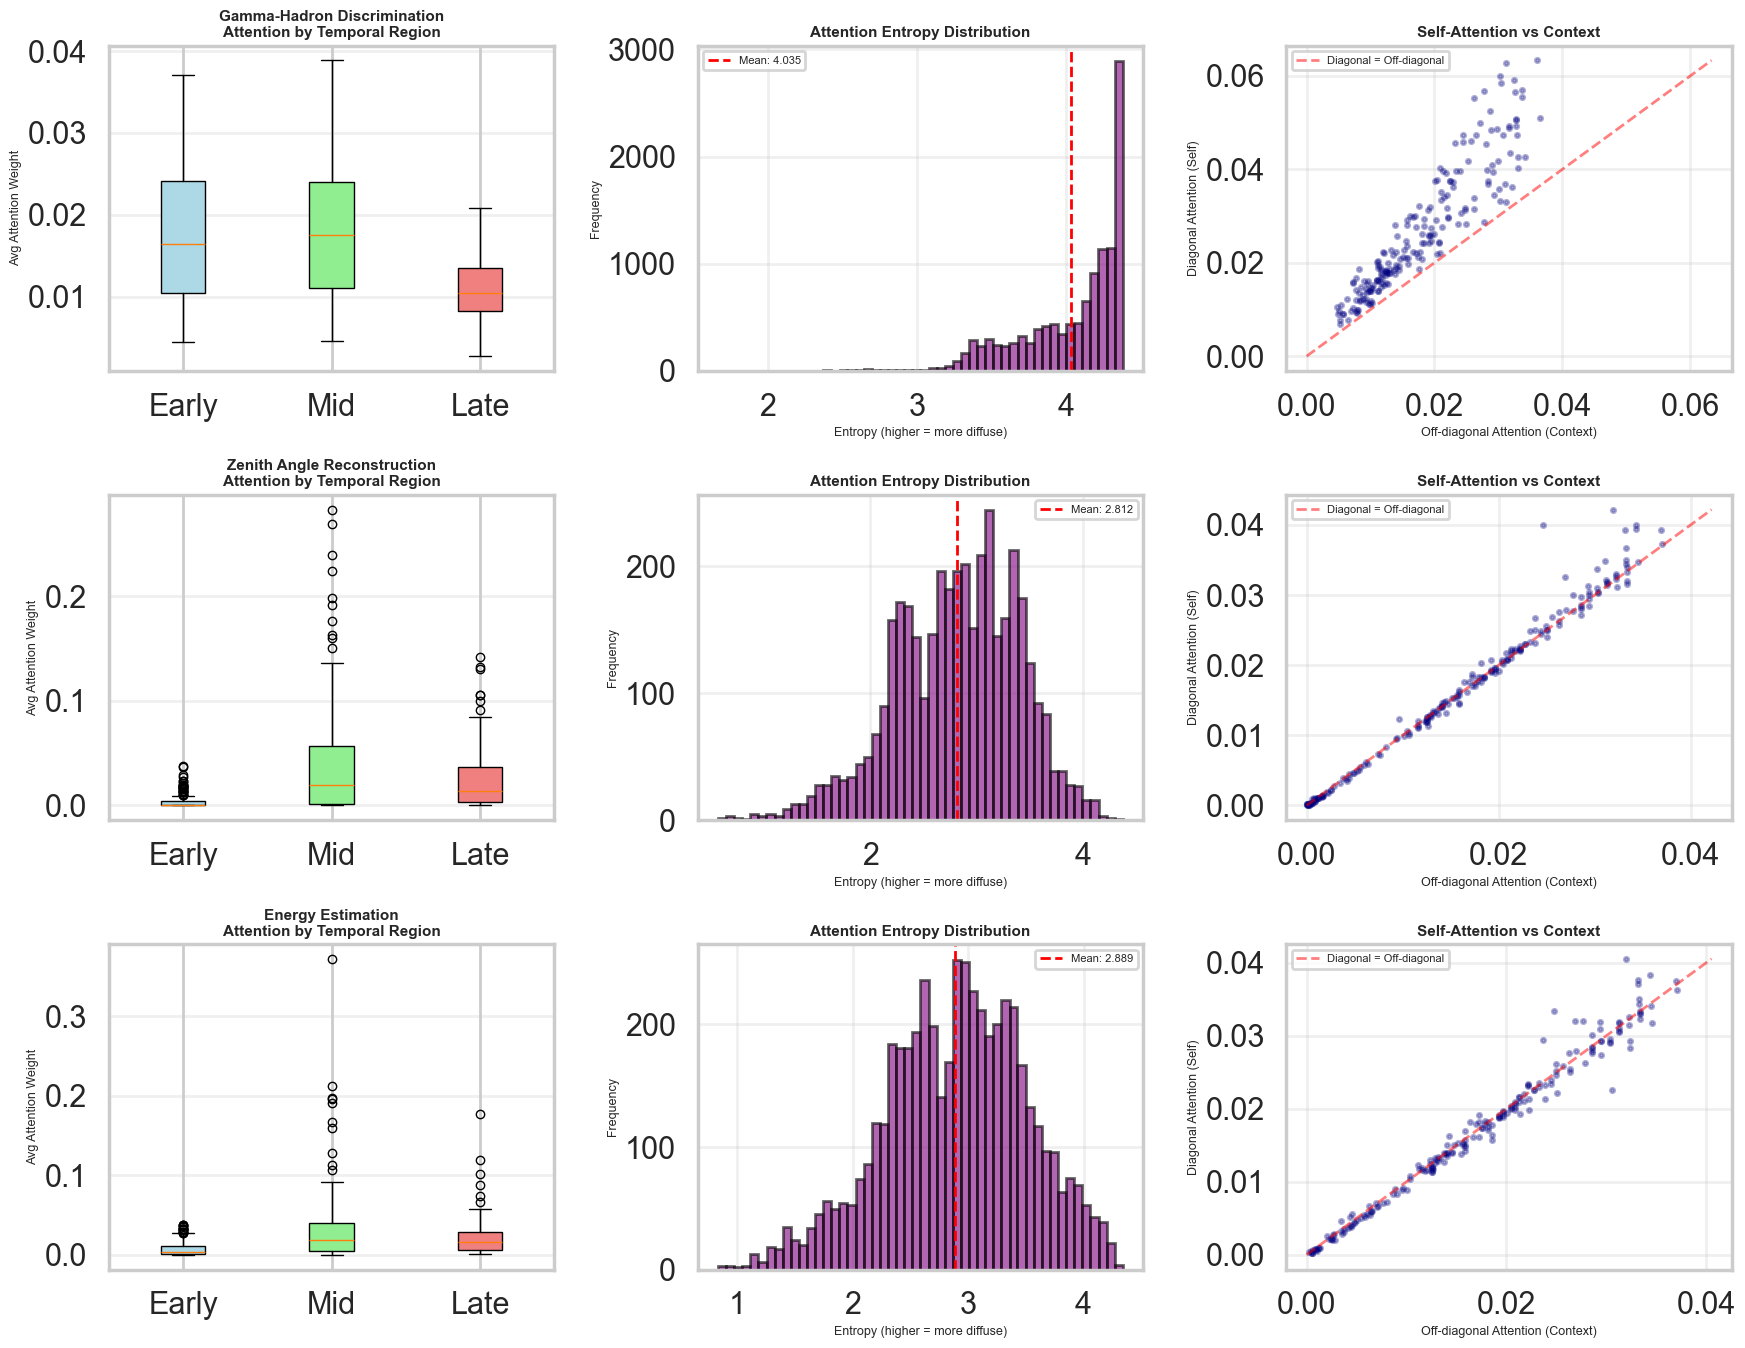

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_temporal_analysis.png


In [71]:
# 2. ANÁLISIS TEMPORAL: Importancia de posiciones early/mid/late
# ----------------------------- #
print("\n2. Analizando importancia temporal de las posiciones...")

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

for task_idx, (task_name, attn_scores) in enumerate([
    ("Gamma-Hadron Discrimination", attn_class_scores),
    ("Zenith Angle Reconstruction", attn_angle_scores),
    ("Energy Estimation", attn_energy_scores)
]):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores

    max_len = 80
    early_range = (0, max_len // 3)
    mid_range = (max_len // 3, 2 * max_len // 3)
    late_range = (2 * max_len // 3, max_len)

    early_attn, mid_attn, late_attn = [], [], []

    for idx in range(len(attn_3d)):
        L = min(int(valid_lengths[idx]), max_len)
        if L > 10:
            attn_mat = attn_3d[idx, :L, :L]
            attn_received = attn_mat.mean(axis=0)

            e_end = min(L, early_range[1])
            m_start = min(L, mid_range[0]); m_end = min(L, mid_range[1])
            l_start = min(L, late_range[0])

            if e_end > early_range[0]:
                early_attn.append(np.nanmean(attn_received[early_range[0]:e_end]))
            if m_end > m_start:
                mid_attn.append(np.nanmean(attn_received[m_start:m_end]))
            if L > l_start:
                late_attn.append(np.nanmean(attn_received[l_start:L]))

    # Plot 1: Box plot
    ax1 = axes[task_idx, 0]
    bp = ax1.boxplot([early_attn, mid_attn, late_attn],
                     labels=['Early', 'Mid', 'Late'],
                     patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
        patch.set_facecolor(color)
    ax1.set_title(f"{task_name}\nAttention by Temporal Region", fontsize=11, fontweight="bold")
    ax1.set_ylabel("Avg Attention Weight", fontsize=9)
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Entropía
    ax2 = axes[task_idx, 1]
    entropies = []
    for idx in range(len(attn_3d)):
        L = min(int(valid_lengths[idx]), max_len)
        if L > 5:
            attn_mat = attn_3d[idx, :L, :L]
            for row in attn_mat:
                s = row.sum()
                if s <= 0:
                    continue
                row_norm = row / s
                entropy = -np.sum(row_norm * np.log(row_norm + 1e-12))
                if np.isfinite(entropy):
                    entropies.append(entropy)

    if entropies:
        ax2.hist(entropies, bins=50, color='purple', alpha=0.6, edgecolor='black')
        mean_ent = float(np.mean(entropies))
        ax2.axvline(mean_ent, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ent:.3f}')
        ax2.legend(fontsize=8)
    ax2.set_title("Attention Entropy Distribution", fontsize=11, fontweight="bold")
    ax2.set_xlabel("Entropy (higher = more diffuse)", fontsize=9)
    ax2.set_ylabel("Frequency", fontsize=9)
    ax2.grid(alpha=0.3)

    # Plot 3: Self vs Context
    ax3 = axes[task_idx, 2]
    diag_strengths, offdiag_strengths = [], []

    for idx in range(len(attn_3d)):
        L = min(int(valid_lengths[idx]), max_len)
        if L > 5:
            attn_mat = attn_3d[idx, :L, :L]
            diag = np.diag(attn_mat).mean()
            mask = ~np.eye(L, dtype=bool)
            offdiag = attn_mat[mask].mean()
            if np.isfinite(diag) and np.isfinite(offdiag):
                diag_strengths.append(diag)
                offdiag_strengths.append(offdiag)

    if diag_strengths and offdiag_strengths:
        ax3.scatter(offdiag_strengths, diag_strengths, alpha=0.3, s=10, color='navy')
        lim = max(offdiag_strengths + diag_strengths)
        ax3.plot([0, lim], [0, lim], 'r--', linewidth=2, alpha=0.5, label='Diagonal = Off-diagonal')
        ax3.legend(fontsize=8)
    ax3.set_xlabel("Off-diagonal Attention (Context)", fontsize=9)
    ax3.set_ylabel("Diagonal Attention (Self)", fontsize=9)
    ax3.set_title("Self-Attention vs Context", fontsize=11, fontweight="bold")
    ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / "attention_temporal_analysis.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_temporal_analysis.png'}")

### Attention by Physics (Particle & Energy)
- Attention profiles split by particle type and energy level.
- Aggregated heatmaps by energy bin.


3. Analizando patrones por tipo de partícula y energía...


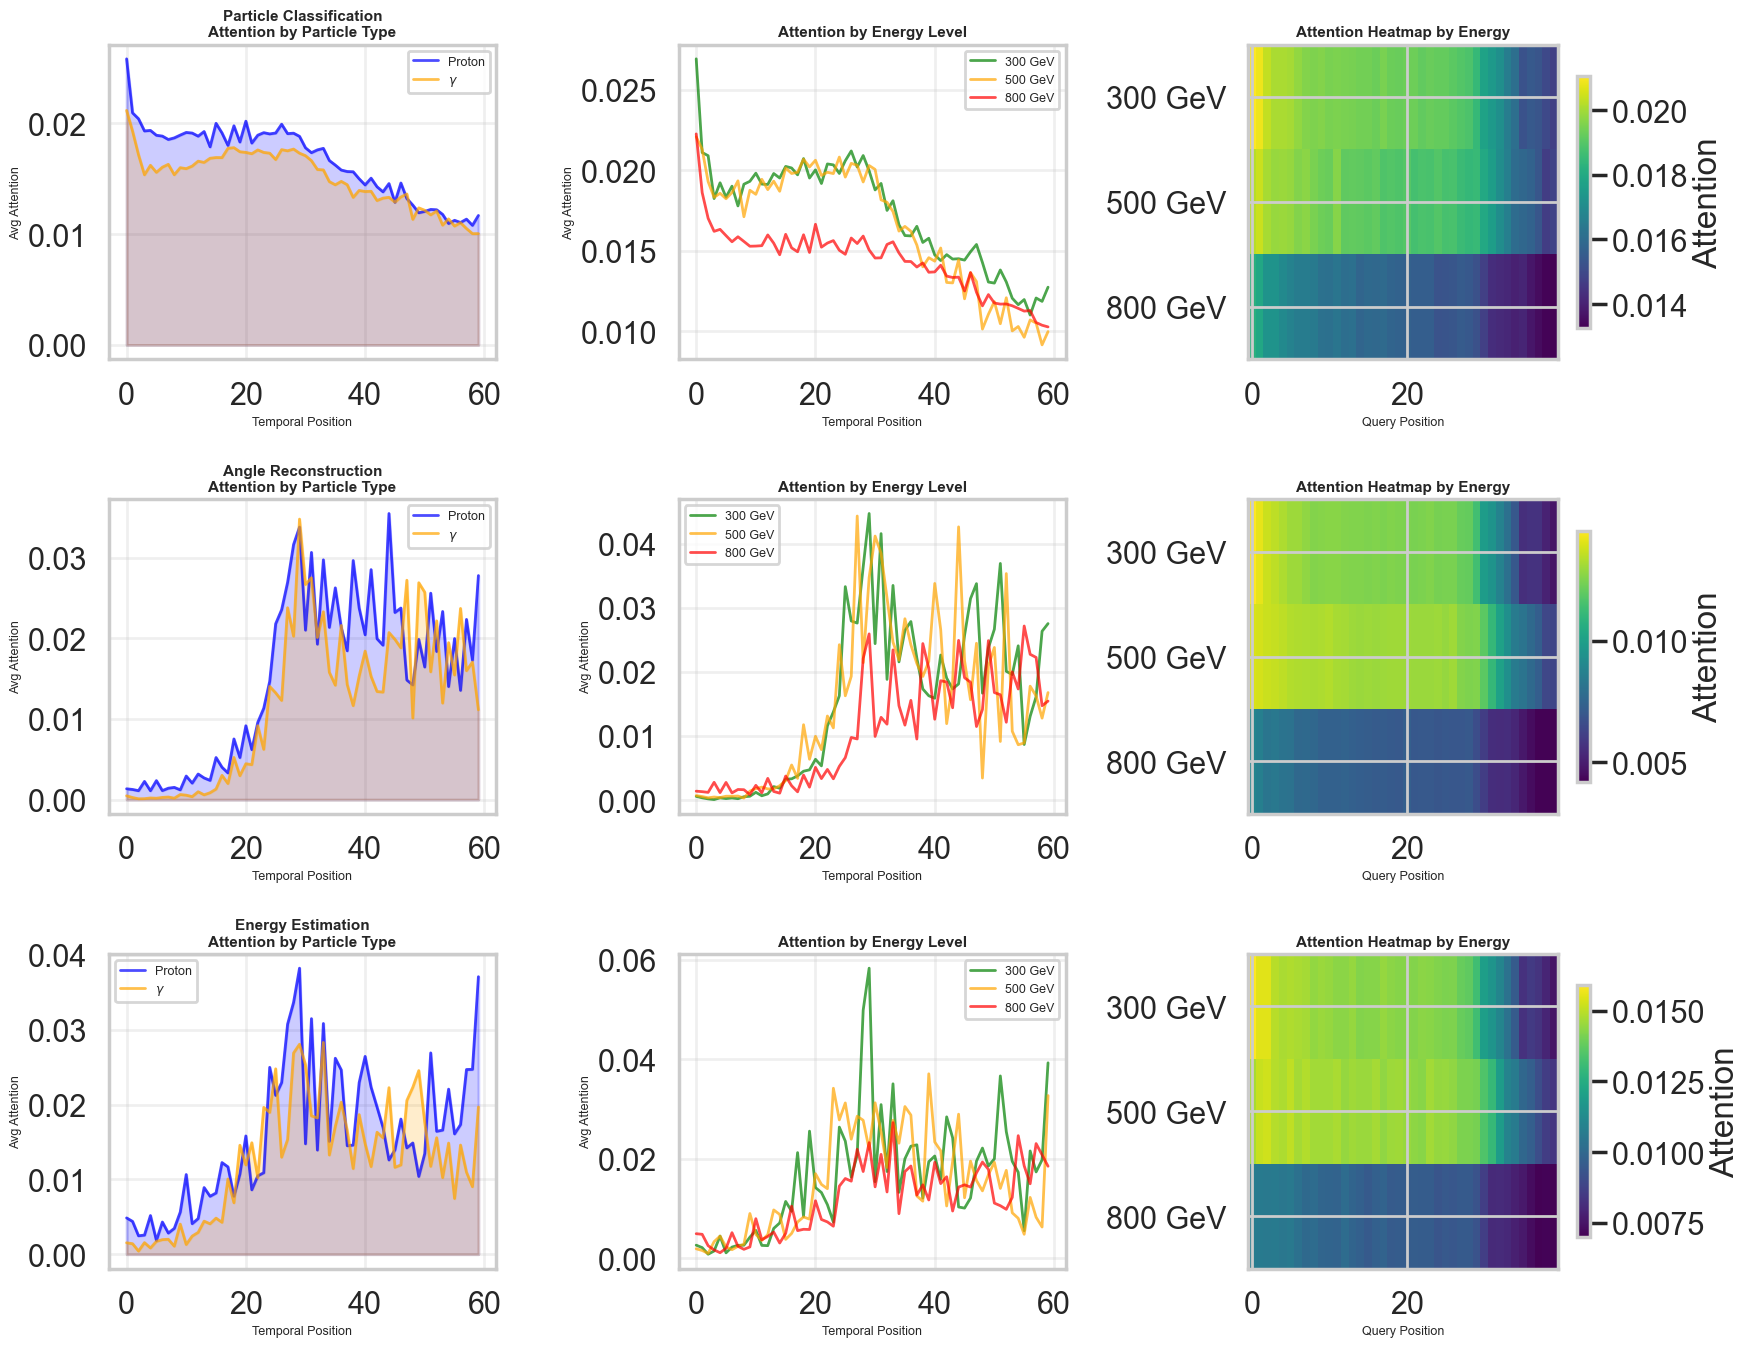

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_physics_analysis.png

ANÁLISIS COMPLETADO

Resumen de visualizaciones generadas:
1. attention_performance_comparison.png - Patrones según performance
2. attention_temporal_analysis.png - Análisis temporal y entropía
3. attention_physics_analysis.png - Análisis por física del evento


In [74]:
# 3. ANÁLISIS POR TIPO DE PARTÍCULA Y ENERGÍA
# ----------------------------- #
print("\n3. Analizando patrones por tipo de partícula y energía...")

particle_types = pred_summary["particle_true"].values[sample_indices]
energy_levels_sample = pred_summary["energy_level_true"].values[sample_indices]

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

for task_idx, (task_name, attn_scores) in enumerate([
    ("Particle Classification", attn_class_scores),
    ("Angle Reconstruction", attn_angle_scores),
    ("Energy Estimation", attn_energy_scores)
]):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores

    # Comparación: Photon vs Proton
    ax1 = axes[task_idx, 0]
    max_plot_len = 60

    for particle_type, color, label in [(0, 'blue', 'Proton'), (1, 'orange', r'$\gamma$')]:
        mask = particle_types == particle_type
        if mask.sum() > 0:
            attention_by_pos = np.full((mask.sum(), max_plot_len), np.nan)
            valid_count = 0

            for array_idx, idx in enumerate(np.where(mask)[0]):
                L = min(int(valid_lengths[idx]), max_plot_len)
                if L > 5:
                    attn_mat = attn_3d[idx, :L, :L]
                    attention_by_pos[valid_count, :L] = attn_mat.mean(axis=0)
                    valid_count += 1

            if valid_count > 0:
                avg_attn = np.nanmean(attention_by_pos[:valid_count], axis=0)
                positions = np.arange(len(avg_attn))
                ax1.plot(positions, avg_attn, label=label, color=color, linewidth=2, alpha=0.7)
                ax1.fill_between(positions, avg_attn, alpha=0.2, color=color)

    ax1.set_title(f"{task_name}\nAttention by Particle Type", fontsize=11, fontweight="bold")
    ax1.set_xlabel("Temporal Position", fontsize=9)
    ax1.set_ylabel("Avg Attention", fontsize=9)
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3)

    # Comparación por nivel de energía
    ax2 = axes[task_idx, 1]
    energy_colors = {"3E2": "green", "5E2": "orange", "8E2": "red"}
    energy_labels = {"3E2": "300 GeV", "5E2": "500 GeV", "8E2": "800 GeV"}

    for energy_level in ["3E2", "5E2", "8E2"]:
        mask = energy_levels_sample == energy_level
        if mask.sum() > 0:
            attention_by_pos = np.full((mask.sum(), max_plot_len), np.nan)
            valid_count = 0

            for array_idx, idx in enumerate(np.where(mask)[0]):
                L = min(int(valid_lengths[idx]), max_plot_len)
                if L > 5:
                    attn_mat = attn_3d[idx, :L, :L]
                    attention_by_pos[valid_count, :L] = attn_mat.mean(axis=0)
                    valid_count += 1

            if valid_count > 0:
                avg_attn = np.nanmean(attention_by_pos[:valid_count], axis=0)
                positions = np.arange(len(avg_attn))
                ax2.plot(positions, avg_attn,
                        label=energy_labels[energy_level],
                        color=energy_colors[energy_level], linewidth=2, alpha=0.7)

    ax2.set_title("Attention by Energy Level", fontsize=11, fontweight="bold")
    ax2.set_xlabel("Temporal Position", fontsize=9)
    ax2.set_ylabel("Avg Attention", fontsize=9)
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)

    # Heatmap agregado por energía
    ax3 = axes[task_idx, 2]
    energy_attn_summary = []
    energy_labels_list = []
    max_heatmap_len = 40

    for energy_level in ["3E2", "5E2", "8E2"]:
        mask = energy_levels_sample == energy_level
        if mask.sum() > 0:
            attn_avg = np.zeros((max_heatmap_len, max_heatmap_len))
            count = np.zeros((max_heatmap_len, max_heatmap_len))
            for idx in np.where(mask)[0]:
                L = min(int(valid_lengths[idx]), max_heatmap_len)
                if L > 5:
                    attn_avg[:L, :L] += attn_3d[idx, :L, :L]
                    count[:L, :L] += 1

            attn_avg = np.divide(attn_avg, count, where=count > 0)
            attn_avg[count == 0] = np.nan

            row_means = []
            for i in range(max_heatmap_len):
                if count[i, :].sum() > 0:
                    valid_vals = attn_avg[i, count[i, :] > 0]
                    row_means.append(np.nanmean(valid_vals) if len(valid_vals) > 0 else np.nan)
                else:
                    row_means.append(np.nan)

            energy_attn_summary.append(row_means)
            energy_labels_list.append(energy_labels[energy_level])

    if energy_attn_summary:
        im = ax3.imshow(energy_attn_summary, aspect='auto', cmap='viridis', interpolation='nearest')
        ax3.set_yticks(range(len(energy_labels_list)))
        ax3.set_yticklabels(energy_labels_list)
        ax3.set_xlabel("Query Position", fontsize=9)
        ax3.set_title("Attention Heatmap by Energy", fontsize=11, fontweight="bold")
        plt.colorbar(im, ax=ax3, shrink=0.8, label="Attention")

plt.tight_layout()
plt.savefig(plots_dir / "attention_physics_analysis.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_physics_analysis.png'}")

print("\n" + "="*60)
print("ANÁLISIS COMPLETADO")
print("="*60)
print("\nResumen de visualizaciones generadas:")
print("1. attention_performance_comparison.png - Patrones según performance")
print("2. attention_temporal_analysis.png - Análisis temporal y entropía")
print("3. attention_physics_analysis.png - Análisis por física del evento")

### Spatial Attention (Detector Map)
- Attention aggregated per detector_id using geometry.
- Radial trends, quadrant analysis.


[1] ANÁLISIS ESPACIAL: Mapeo de importancia por detector

Particle Classification:
  Detectores analizados: 120
  Incluye detector_id=0: True
  Atención promedio: 0.003854 ± 0.000437

Angle Reconstruction:
  Detectores analizados: 120
  Incluye detector_id=0: True
  Atención promedio: 0.005000 ± 0.005714

Energy Estimation:
  Detectores analizados: 120
  Incluye detector_id=0: True
  Atención promedio: 0.005102 ± 0.007375


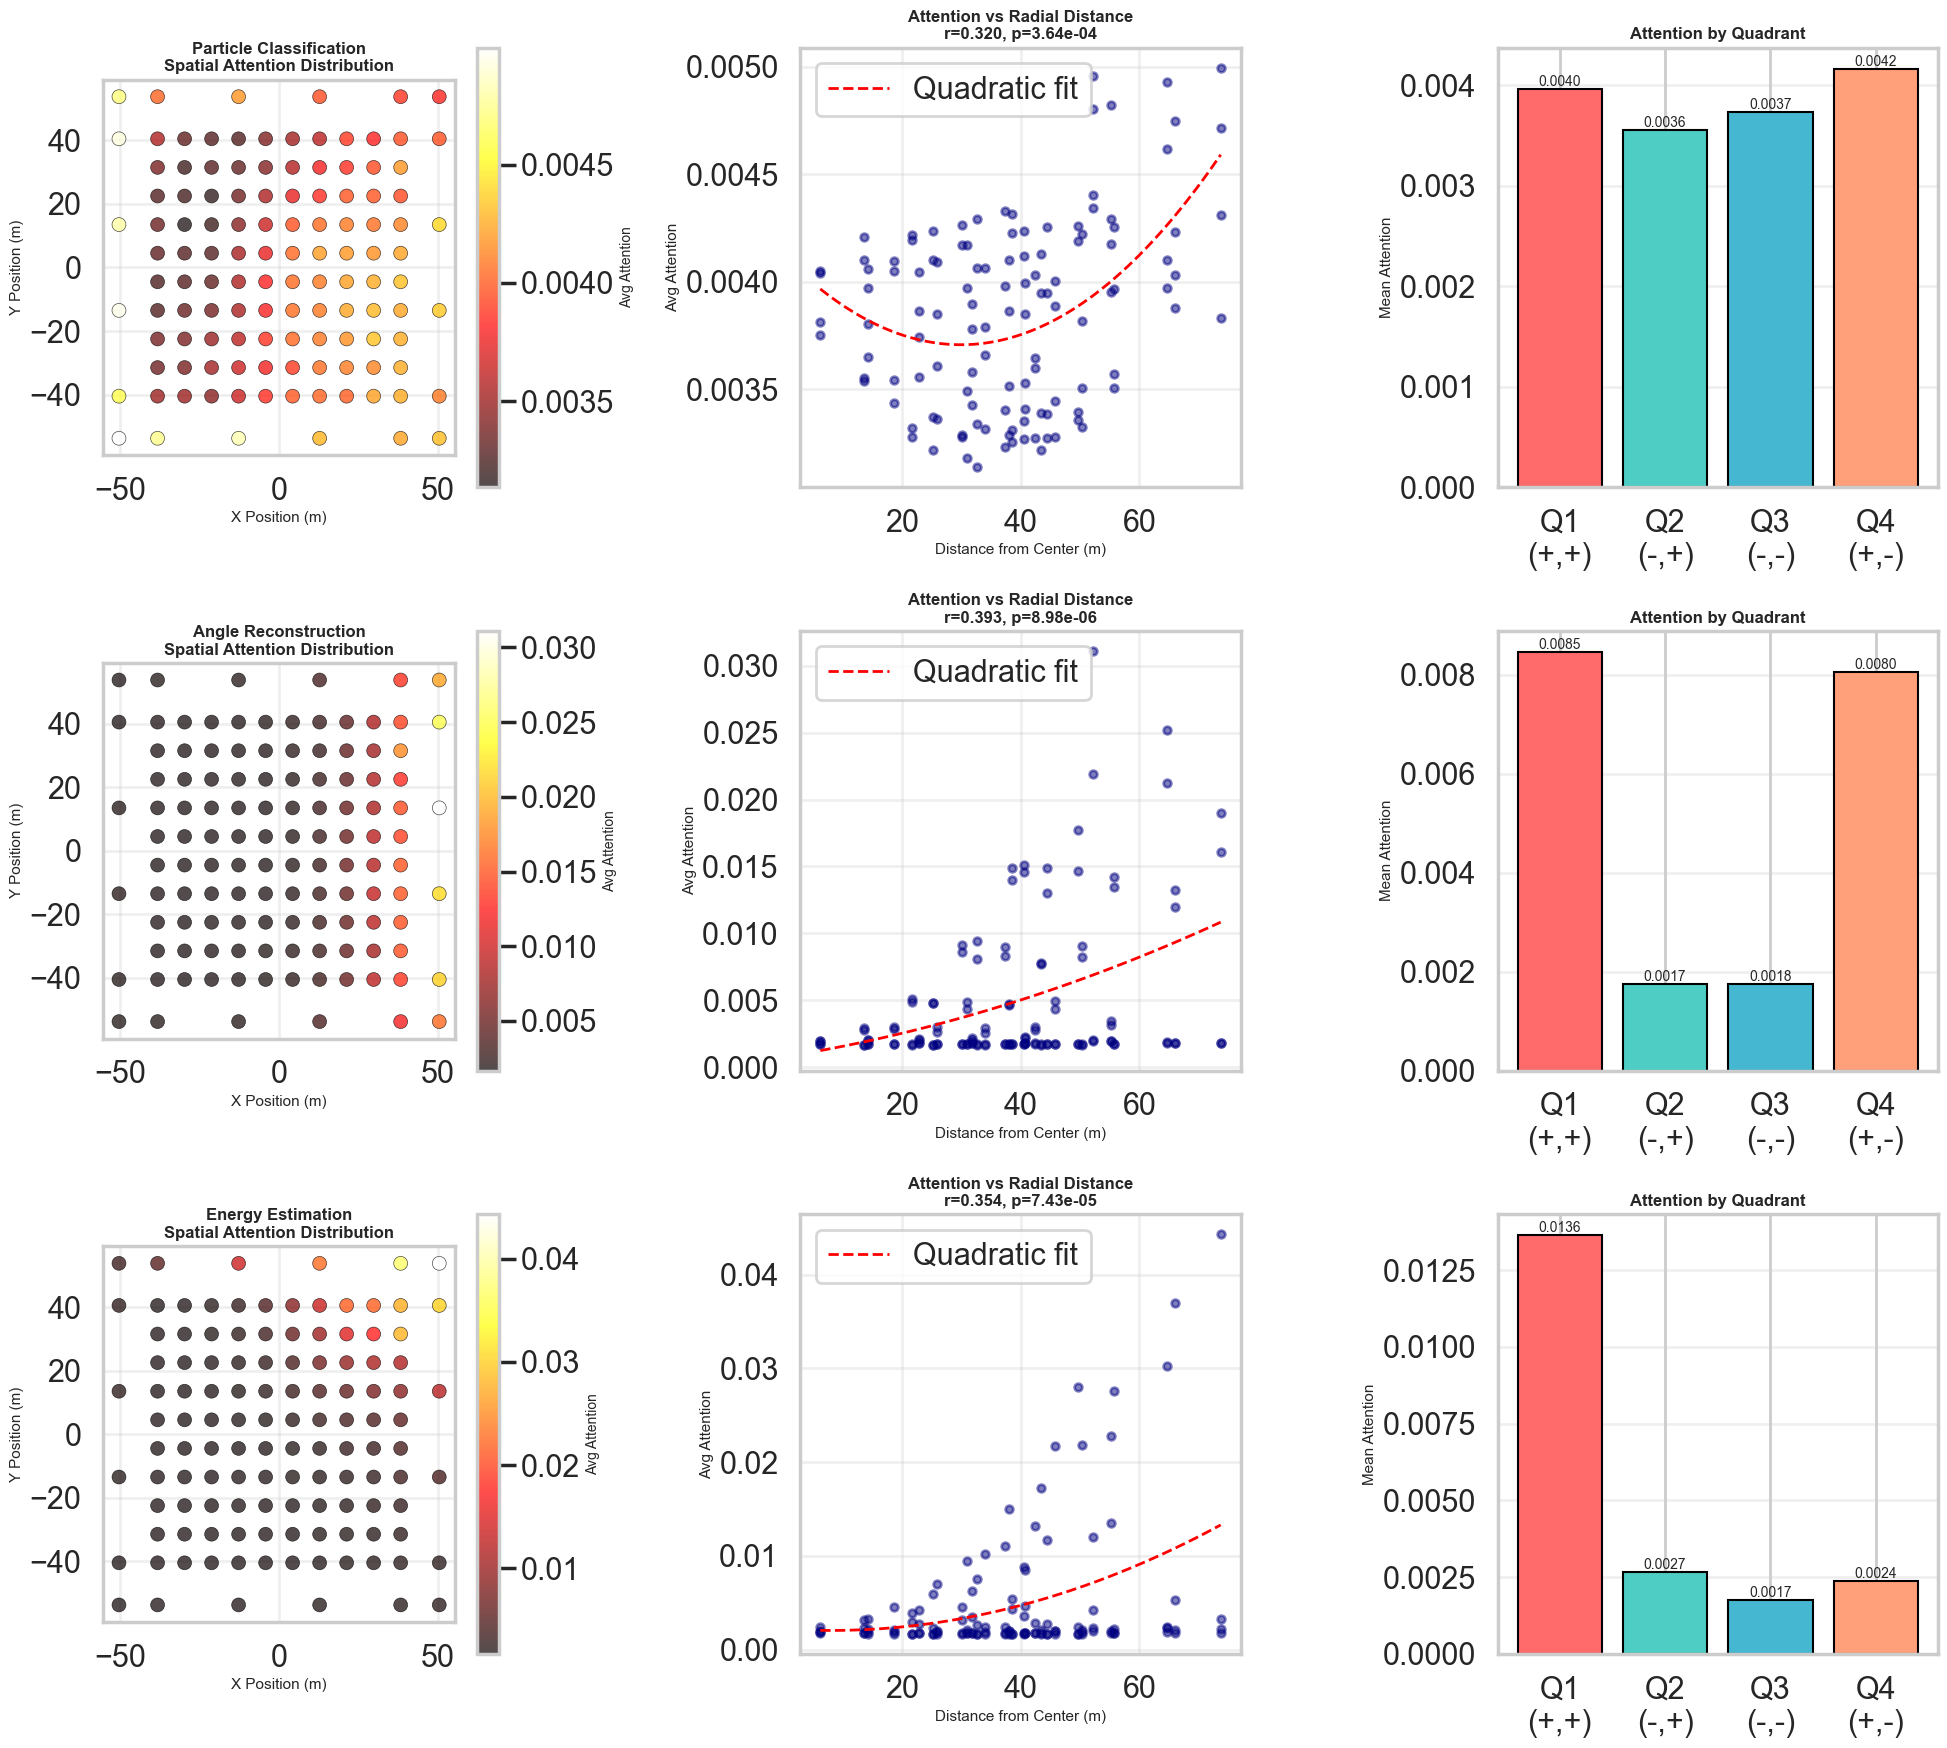


✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_spatial_analysis.png


In [ ]:
# ============================================================
# ANÁLISIS DE EXPLICABILIDAD FÍSICA: CNN-TRANSFORMER ESPACIOTEMPORAL
# ============================================================
# Contexto: Detectores CONDOR capturan cascadas atmosféricas extensas (EAS)
# Features: detector_id, particle_count, t_bin, total_energy, x_center, y_center
# Arquitectura: CNN (extracción temporal) → Transformer (atención) → 3 heads (particle/angle/energy)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA

# ============================================================
# 1. ANÁLISIS ESPACIAL: ¿Qué regiones del detector son importantes?
# ============================================================
print("\n[1] ANÁLISIS ESPACIAL: Mapeo de importancia por detector")

# Reconstruir posiciones espaciales desde el catálogo
detector_positions = detector_catalog.set_index('detector_id')[['x_center', 'y_center']].to_dict('index')

# Para cada tarea, calcular qué detectores reciben más atención
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

for task_idx, (task_name, attn_scores, ax_row) in enumerate([
    ("Particle Classification", attn_class_scores, axes[0]),
    ("Angle Reconstruction", attn_angle_scores, axes[1]),
    ("Energy Estimation", attn_energy_scores, axes[2]),
]):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores

    detector_importance = {}
    detector_count = {}

    for idx in range(len(X_sample)):
        seq = X_sample[idx]
        L = int(valid_lengths[idx])

        if L <= 5:
            continue

        attn_mat = attn_3d[idx]
        attn_len = attn_mat.shape[0]

        # Factor de pooling dinámico (1 para RAW, 2 para CNN pooled)
        pool_factor = max(1, int(np.ceil(L / max(1, attn_len))))

        # Atención recibida (promedio sobre queries), saneando NaN/inf
        attn_received = attn_mat.mean(axis=0)
        attn_received = np.where(np.isfinite(attn_received), attn_received, np.nan)
        if attn_received.size == 0:
            continue

        max_t = min(attn_len, int(np.ceil(L / pool_factor)))
        for t_pos in range(max_t):
            seq_idx = min(int(t_pos * pool_factor), L - 1)
            det_id = int(seq[seq_idx, 0])

            if det_id >= 0 and det_id in detector_positions:
                if det_id not in detector_importance:
                    detector_importance[det_id] = 0.0
                    detector_count[det_id] = 0
                if t_pos < len(attn_received):
                    val = attn_received[t_pos]
                    if np.isfinite(val):
                        detector_importance[det_id] += val
                        detector_count[det_id] += 1

    for det_id in list(detector_importance):
        if detector_count[det_id] > 0:
            detector_importance[det_id] /= detector_count[det_id]
        else:
            detector_importance.pop(det_id, None)

    if len(detector_importance) == 0:
        print(f"⚠ Warning: No hay datos de importancia de detectores para {task_name}")
        continue

    detector_ids = list(detector_importance.keys())
    x_coords = [detector_positions[d]['x_center'] for d in detector_ids]
    y_coords = [detector_positions[d]['y_center'] for d in detector_ids]
    importances = np.array([detector_importance[d] for d in detector_ids], dtype=float)

    print(f"\n{task_name}:")
    print(f"  Detectores analizados: {len(detector_ids)}")
    print(f"  Incluye detector_id=0: {0 in detector_ids}")
    print(f"  Atención promedio: {np.nanmean(importances):.6f} ± {np.nanstd(importances):.6f}")

    scatter = ax_row[0].scatter(x_coords, y_coords, c=importances, s=100,
                                cmap='hot', alpha=0.7, edgecolors='black', linewidth=0.5)
    ax_row[0].set_xlabel("X Position (m)", fontsize=11)
    ax_row[0].set_ylabel("Y Position (m)", fontsize=11)
    ax_row[0].set_title(f"{task_name}\nSpatial Attention Distribution", fontsize=12, fontweight='bold')
    ax_row[0].grid(alpha=0.3)
    ax_row[0].set_aspect('equal')
    cbar = plt.colorbar(scatter, ax=ax_row[0])
    cbar.set_label("Avg Attention", fontsize=10)

    distances = np.sqrt(np.array(x_coords)**2 + np.array(y_coords)**2)
    ax_row[1].scatter(distances, importances, alpha=0.5, s=30, color='navy')

    if len(distances) > 3:
        z = np.polyfit(distances, importances, 2)
        p = np.poly1d(z)
        x_fit = np.linspace(distances.min(), distances.max(), 100)
        ax_row[1].plot(x_fit, p(x_fit), "r--", linewidth=2, label='Quadratic fit')

    if len(distances) > 1:
        corr, pval = pearsonr(distances, importances)
    else:
        corr, pval = np.nan, np.nan

    ax_row[1].set_xlabel("Distance from Center (m)", fontsize=11)
    ax_row[1].set_ylabel("Avg Attention", fontsize=11)
    ax_row[1].set_title(f"Attention vs Radial Distance\nr={corr:.3f}, p={pval:.2e}",
                        fontsize=12, fontweight='bold')
    ax_row[1].legend()
    ax_row[1].grid(alpha=0.3)

    ax_row[2].set_title("Attention by Quadrant", fontsize=12, fontweight='bold')
    quadrants = {'Q1 (+,+)': [], 'Q2 (-,+)': [], 'Q3 (-,-)': [], 'Q4 (+,-)': []}
    for x, y, imp in zip(x_coords, y_coords, importances):
        if x >= 0 and y >= 0:
            quadrants['Q1 (+,+)'].append(imp)
        elif x < 0 and y >= 0:
            quadrants['Q2 (-,+)'].append(imp)
        elif x < 0 and y < 0:
            quadrants['Q3 (-,-)'].append(imp)
        else:
            quadrants['Q4 (+,-)'].append(imp)

    quad_means = [np.nanmean(quadrants[q]) if len(quadrants[q]) > 0 else 0
                  for q in ['Q1 (+,+)', 'Q2 (-,+)', 'Q3 (-,-)', 'Q4 (+,-)']]

    colors_quad = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    bars = ax_row[2].bar(range(4), quad_means, color=colors_quad, edgecolor='black', linewidth=1.5)
    ax_row[2].set_xticks(range(4))
    ax_row[2].set_xticklabels(['Q1\n(+,+)', 'Q2\n(-,+)', 'Q3\n(-,-)', 'Q4\n(+,-)'])
    ax_row[2].set_ylabel("Mean Attention", fontsize=11)
    ax_row[2].grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax_row[2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(plots_dir / "attention_spatial_analysis.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"\n✓ Guardado: {plots_dir / 'attention_spatial_analysis.png'}")

### Spatio-Temporal Evolution
- Early/Mid/Late windows after pooling: energy, particle count, radial spread.

### Correlation: Attention vs Physical Features
- Spearman correlations with particle_count, total_energy, temporal position, radial distance.


[3] CORRELACIÓN ENTRE ATENCIÓN Y FEATURES FÍSICAS


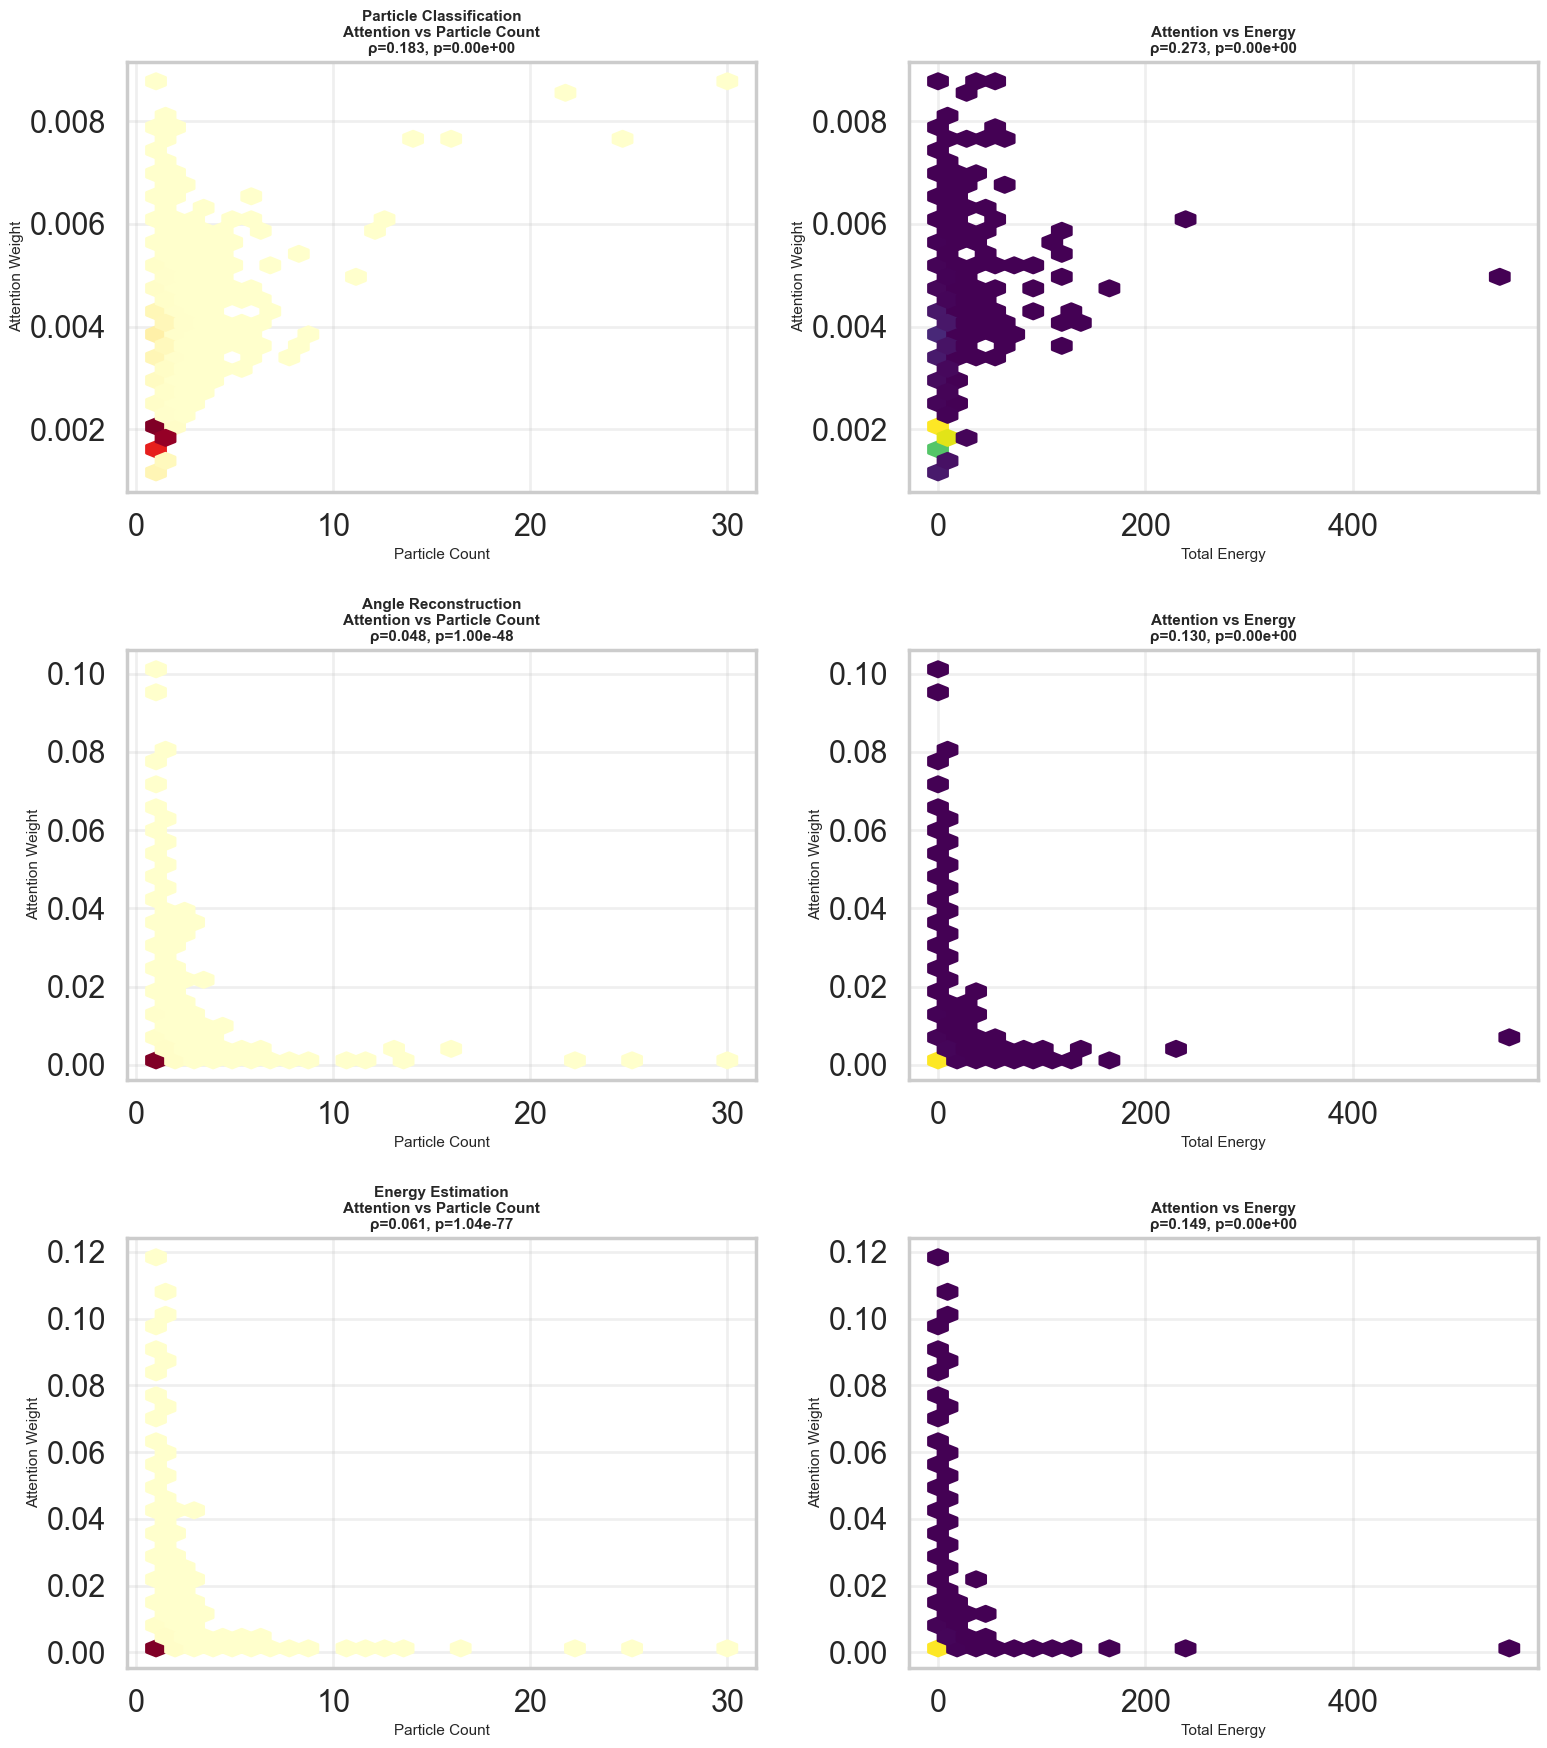

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_feature_correlation.png


In [77]:
# ============================================================
# 3. ANÁLISIS DE CORRELACIÓN ATENCIÓN-FEATURES
# ============================================================
print("\n[3] CORRELACIÓN ENTRE ATENCIÓN Y FEATURES FÍSICAS")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for task_idx, (task_name, attn_scores) in enumerate([
    ("Particle Classification", attn_class_scores),
    ("Angle Reconstruction", attn_angle_scores),
    ("Energy Estimation", attn_energy_scores)
]):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores

    attention_weights = []
    particle_counts = []
    energies = []
    temporal_positions = []
    spatial_distances = []

    for idx in range(len(X_sample)):
        seq = X_sample[idx]
        L = int(valid_lengths[idx])

        if L <= 5:
            continue

        attn_mat = attn_3d[idx]
        attn_len = attn_mat.shape[0]
        if attn_len == 0:
            continue

        # Factor de pooling dinámico (1 RAW, ~2 CNN pooled)
        pool_factor = max(1, int(np.round(L / max(1, attn_len))))

        attn_received = attn_mat.mean(axis=0)
        attn_received = np.where(np.isfinite(attn_received), attn_received, np.nan)

        max_t = min(attn_len, attn_received.shape[0])
        for t_pos in range(max_t):
            seq_idx = min(int(t_pos * pool_factor), L - 1)
            det_id = int(seq[seq_idx, 0])

            if det_id >= 0 and det_id in detector_positions:
                aw = attn_received[t_pos]
                if not np.isfinite(aw):
                    continue
                attention_weights.append(float(aw))
                particle_counts.append(float(seq[seq_idx, 1]))
                energies.append(float(seq[seq_idx, 3]))
                temporal_positions.append(t_pos / attn_len)
                x = detector_positions[det_id]['x_center']
                y = detector_positions[det_id]['y_center']
                spatial_distances.append(float(np.hypot(x, y)))

    if len(attention_weights) == 0:
        print(f"⚠ Warning: No hay datos para {task_name}")
        continue

    attention_weights = np.array(attention_weights, dtype=float)
    particle_counts = np.array(particle_counts, dtype=float)
    energies = np.array(energies, dtype=float)
    temporal_positions = np.array(temporal_positions, dtype=float)
    spatial_distances = np.array(spatial_distances, dtype=float)

    # Plot 1: Atención vs Particle Count
    ax1 = axes[task_idx, 0]
    ax1.hexbin(particle_counts, attention_weights, gridsize=30, cmap='YlOrRd', mincnt=1)
    corr_pc, pval_pc = spearmanr(particle_counts, attention_weights) if len(particle_counts) > 2 else (np.nan, np.nan)
    ax1.set_xlabel("Particle Count", fontsize=11)
    ax1.set_ylabel("Attention Weight", fontsize=11)
    ax1.set_title(f"{task_name}\nAttention vs Particle Count\nρ={corr_pc:.3f}, p={pval_pc:.2e}",
                  fontsize=11, fontweight='bold')
    ax1.grid(alpha=0.3)

    # Plot 2: Atención vs Energy
    ax2 = axes[task_idx, 1]
    ax2.hexbin(energies, attention_weights, gridsize=30, cmap='viridis', mincnt=1)
    corr_e, pval_e = spearmanr(energies, attention_weights) if len(energies) > 2 else (np.nan, np.nan)
    ax2.set_xlabel("Total Energy", fontsize=11)
    ax2.set_ylabel("Attention Weight", fontsize=11)
    ax2.set_title(f"Attention vs Energy\nρ={corr_e:.3f}, p={pval_e:.2e}",
                  fontsize=11, fontweight='bold')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / "attention_feature_correlation.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_feature_correlation.png'}")

### CNN Embedding Space
- PCA on pooled CNN embeddings.
- Color by particle type, energy, correctness.


[4] ANÁLISIS DE EMBEDDING: ¿Qué aprende la CNN?
Extrayendo embeddings CNN...


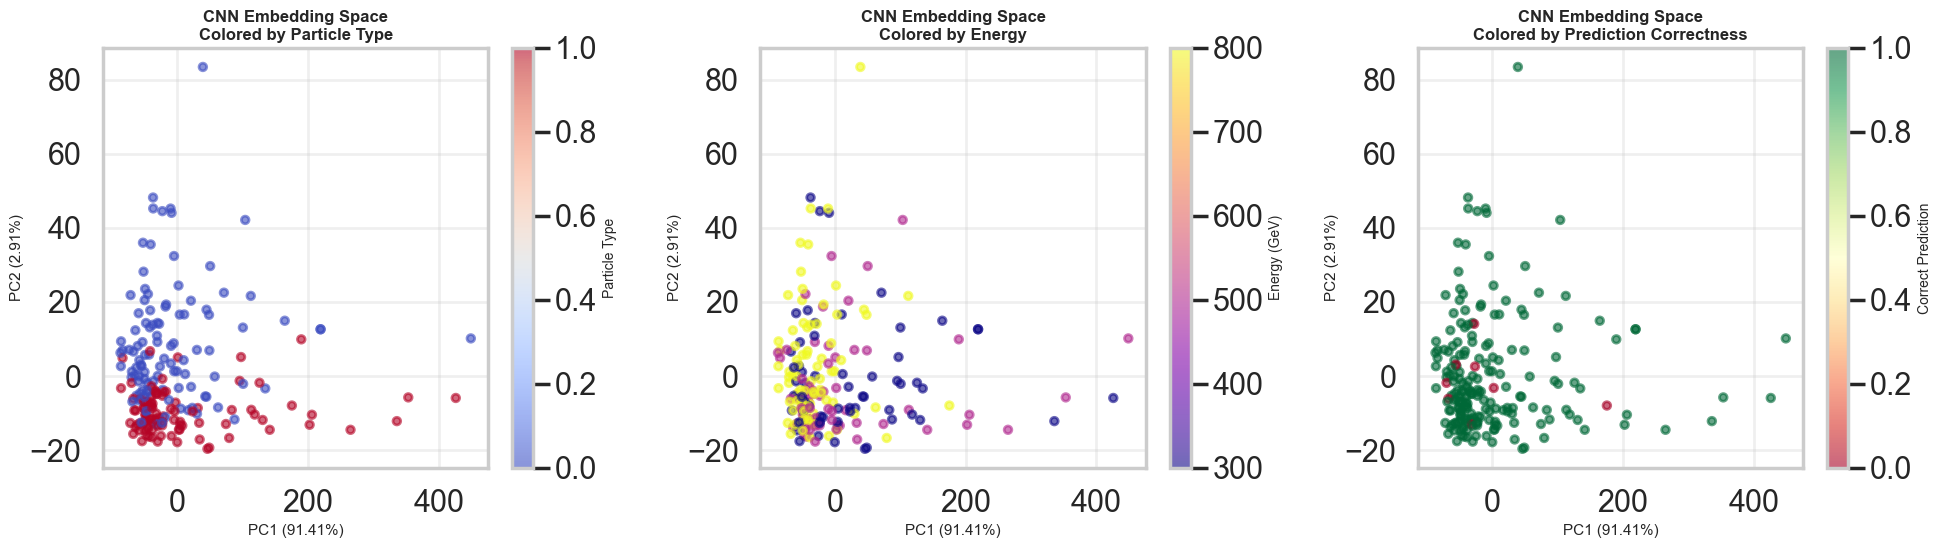

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\cnn_embedding_analysis.png


In [78]:
# ============================================================
# 4. ANÁLISIS DE EMBEDDING: Representación CNN
# ============================================================
print("\n[4] ANÁLISIS DE EMBEDDING: ¿Qué aprende la CNN?")

# Crear modelo intermedio para extraer embeddings CNN
cnn_output_layer = model.get_layer("dense_after_cnn4")
embedding_model = Model(inputs=model.inputs, outputs=cnn_output_layer.output)

# Extraer embeddings para subset
print("Extrayendo embeddings CNN...")
embeddings = embedding_model.predict([X_sample, Xg_sample], batch_size=64, verbose=0)
# embeddings shape: (batch, seq_len, 128)

# Promediar sobre secuencia para obtener representación global (evitar NaN si L=0)
embeddings_avg_list = []
for i, emb in enumerate(embeddings):
    L = int(valid_lengths[i])
    if L <= 0:
        embeddings_avg_list.append(np.zeros(emb.shape[-1], dtype=np.float32))
    else:
        vec = np.nanmean(emb[:L], axis=0)
        if not np.all(np.isfinite(vec)):
            vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
        embeddings_avg_list.append(vec.astype(np.float32))
embeddings_avg = np.vstack(embeddings_avg_list)

# PCA para visualización (salir si hay menos de 2 muestras)
if embeddings_avg.shape[0] < 2:
    print("⚠ No hay suficientes embeddings para PCA.")
else:
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_avg)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Colored by particle type
    scatter1 = axes[0].scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=particle_types, cmap='coolwarm', s=30, alpha=0.6
    )
    axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=11)
    axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=11)
    axes[0].set_title("CNN Embedding Space\nColored by Particle Type", fontsize=12, fontweight='bold')
    cbar1 = plt.colorbar(scatter1, ax=axes[0])
    cbar1.set_label("Particle Type", fontsize=10)
    axes[0].grid(alpha=0.3)

    # Plot 2: Colored by energy
    energy_numeric = np.array([float(e.replace('E', 'e')) for e in energy_levels_sample])
    scatter2 = axes[1].scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=energy_numeric, cmap='plasma', s=30, alpha=0.6
    )
    axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=11)
    axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=11)
    axes[1].set_title("CNN Embedding Space\nColored by Energy", fontsize=12, fontweight='bold')
    cbar2 = plt.colorbar(scatter2, ax=axes[1])
    cbar2.set_label("Energy (GeV)", fontsize=10)
    axes[1].grid(alpha=0.3)

    # Plot 3: Colored by prediction correctness
    particle_correct = particle_correct_mask.astype(int)
    scatter3 = axes[2].scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=particle_correct, cmap='RdYlGn', s=30, alpha=0.6
    )
    axes[2].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=11)
    axes[2].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=11)
    axes[2].set_title("CNN Embedding Space\nColored by Prediction Correctness", fontsize=12, fontweight='bold')
    cbar3 = plt.colorbar(scatter3, ax=axes[2])
    cbar3.set_label("Correct Prediction", fontsize=10)
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(plots_dir / "cnn_embedding_analysis.png", dpi=200, bbox_inches="tight")
    plt.show()

    print(f"✓ Guardado: {plots_dir / 'cnn_embedding_analysis.png'}")

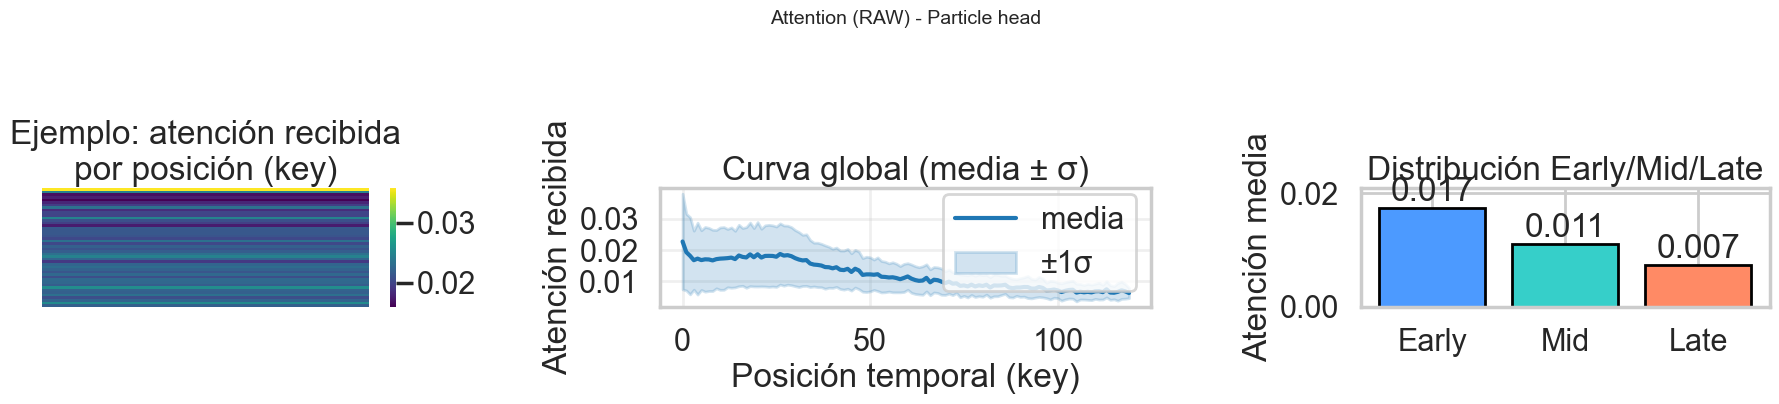

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attn_global_particle.png


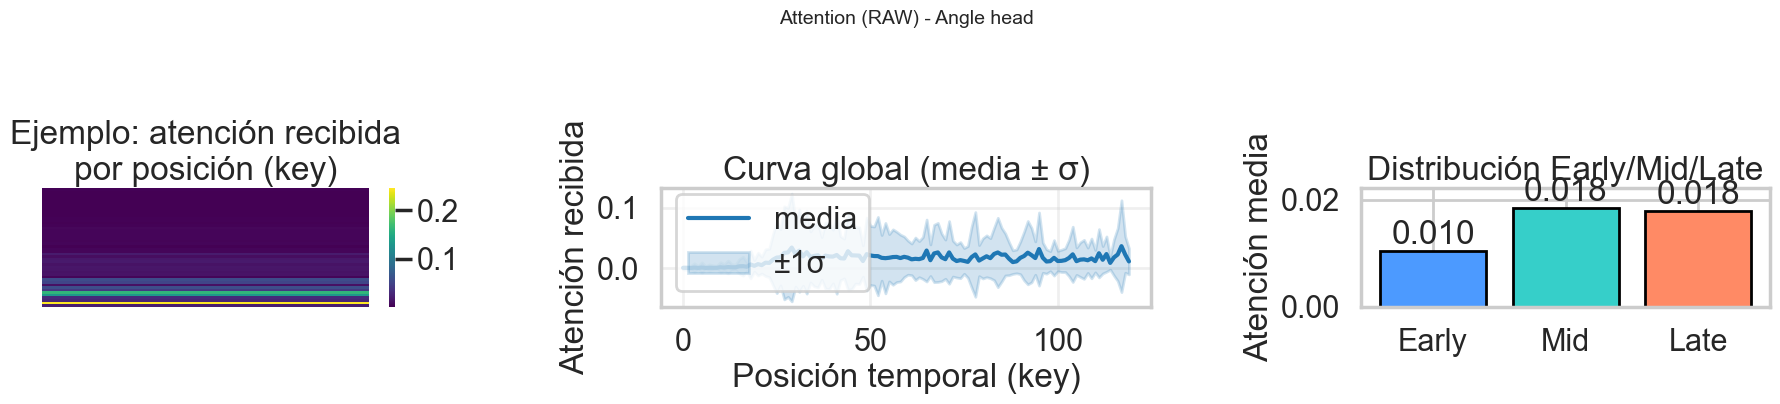

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attn_global_angle.png


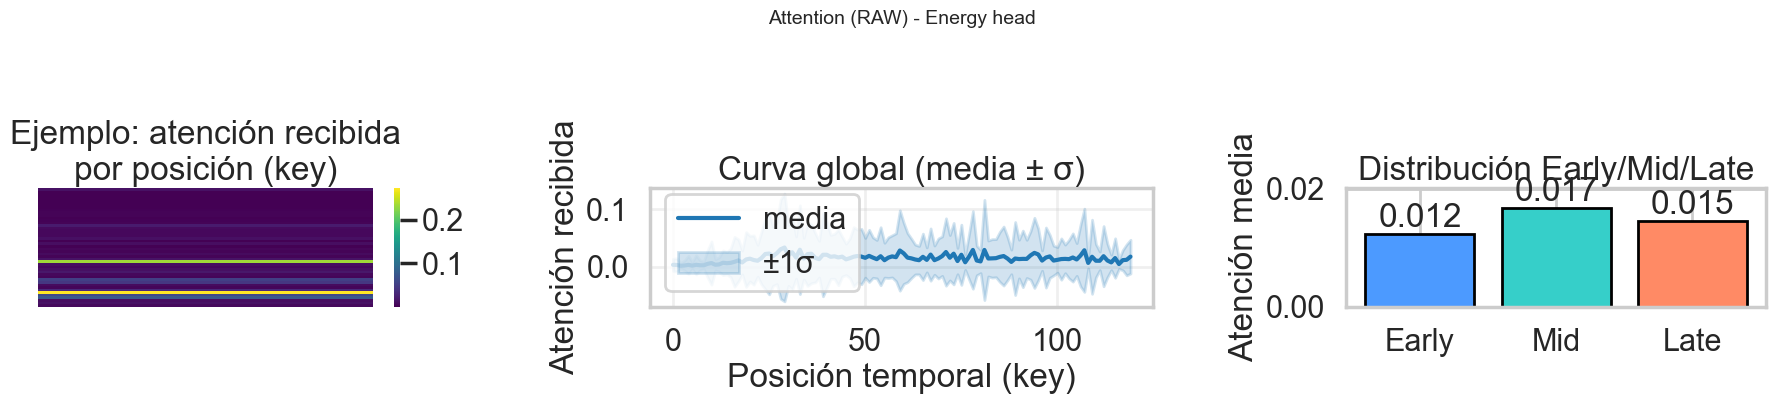

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attn_global_energy.png


In [82]:
# --- Atención: curva global y resumen simple (RAW) ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def attention_received_per_event(attn_scores, valid_lengths, max_len=120):
    """Promedia atención recibida por posición (keys) por evento, respetando padding."""
    if attn_scores.ndim == 4:
        attn_scores = attn_scores.mean(axis=1)  # heads -> mean
    curves = []
    for mat, L in zip(attn_scores, valid_lengths):
        L = int(min(L, max_len, mat.shape[0]))
        if L <= 0:
            continue
        attn_recv = mat[:L, :L].mean(axis=0)
        curves.append(attn_recv)
    return curves

def plot_global_attention(attn_scores, valid_lengths, title, save_path, max_len=120):
    curves = attention_received_per_event(attn_scores, valid_lengths, max_len)
    if not curves:
        print("Sin muestras válidas para atención.")
        return
    max_L = min(max(len(c) for c in curves), max_len)
    padded = []
    for c in curves:
        Lc = min(len(c), max_L)
        pad = np.full(max_L, np.nan, dtype=float)
        pad[:Lc] = c[:Lc]
        padded.append(pad)
    stack = np.vstack(padded)
    mean_curve = np.nanmean(stack, axis=0)
    std_curve = np.nanstd(stack, axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), gridspec_kw={"width_ratios": [1, 1.2, 1]})
    sns.heatmap(curves[0][:, None], cmap="viridis", ax=axes[0], cbar=True, yticklabels=False, xticklabels=False)
    axes[0].set_title("Ejemplo: atención recibida\npor posición (key)")
    x = np.arange(max_L)
    axes[1].plot(x, mean_curve, color="tab:blue", label="media")
    axes[1].fill_between(x, mean_curve - std_curve, mean_curve + std_curve, color="tab:blue", alpha=0.2, label="±1σ")
    axes[1].set_xlabel("Posición temporal (key)")
    axes[1].set_ylabel("Atención recibida")
    axes[1].set_title("Curva global (media ± σ)")
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    thirds = np.array_split(mean_curve, 3)
    parts = [np.nanmean(t) for t in thirds]
    axes[2].bar(["Early", "Mid", "Late"], parts, color=["#4C9AFF", "#36CFC9", "#FF8A65"], edgecolor="k")
    axes[2].set_ylim(0, np.nanmax(parts) * 1.2)
    axes[2].set_ylabel("Atención media")
    axes[2].set_title("Distribución Early/Mid/Late")
    for i, v in enumerate(parts):
        axes[2].text(i, v, f"{v:.3f}", ha="center", va="bottom")
    fig.suptitle(title, fontsize=14, y=1.05)
    fig.tight_layout()
    fig.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"✓ Guardado: {save_path}")

plot_global_attention(attn_class_raw_scores, valid_lengths_raw, "Attention (RAW) - Particle head", plots_dir / "attn_global_particle.png")
plot_global_attention(attn_angle_raw_scores, valid_lengths_raw, "Attention (RAW) - Angle head", plots_dir / "attn_global_angle.png")
plot_global_attention(attn_energy_raw_scores, valid_lengths_raw, "Attention (RAW) - Energy head", plots_dir / "attn_global_energy.png")

In [80]:
# --- Top-k hits más influyentes por evento (RAW) ---
import pandas as pd

FEATURE_IDX = {"detector_id": 0, "particle_count": 1, "t_bin": 2, "total_energy": 3, "x_center": 4, "y_center": 5}

def topk_attention_hits(attn_scores, sequences, valid_lengths, k=5):
    """Devuelve lista de dataframes con los k hits con mayor atención recibida por evento."""
    if attn_scores.ndim == 4:
        attn_scores = attn_scores.mean(axis=1)
    results = []
    for mat, seq, L in zip(attn_scores, sequences, valid_lengths):
        L = int(min(L, mat.shape[0], seq.shape[0]))
        if L <= 0:
            results.append(pd.DataFrame())
            continue
        attn_recv = mat[:L, :L].mean(axis=0)
        top_idx = np.argsort(attn_recv)[::-1][:k]
        rows = []
        for idx in top_idx:
            rows.append({
                "rank": len(rows)+1,
                "attention": float(attn_recv[idx]),
                "detector_id": int(seq[idx, FEATURE_IDX["detector_id"]]),
                "t_bin": float(seq[idx, FEATURE_IDX["t_bin"]]),
                "particle_count": float(seq[idx, FEATURE_IDX["particle_count"]]),
                "total_energy": float(seq[idx, FEATURE_IDX["total_energy"]]),
                "x_center": float(seq[idx, FEATURE_IDX["x_center"]]),
                "y_center": float(seq[idx, FEATURE_IDX["y_center"]]),
            })
        results.append(pd.DataFrame(rows))
    return results

topk_particle = topk_attention_hits(attn_class_raw_scores, X_sample, valid_lengths_raw, k=5)

# Ejemplo: mostrar primer evento y guardar CSV
if topk_particle and not topk_particle[0].empty:
    display(topk_particle[0])
all_topk = pd.concat(topk_particle, keys=range(len(topk_particle)), names=["event_idx"])
all_topk.to_csv(plots_dir / "topk_attention_hits_particle.csv")
print(f"✓ Guardado: {plots_dir / 'topk_attention_hits_particle.csv'}")

rank  attention  detector_id  t_bin  particle_count  total_energy  \
0     1   0.035706          109    0.0             1.0      0.148531   
1     2   0.025574           71  104.0             1.0      0.163399   
2     3   0.025467           93  130.0             1.0      4.028406   
3     4   0.024841           46   64.0             1.0     93.210968   
4     5   0.024704           63   87.0             1.0     22.446203   

    x_center  y_center  
0 -50.400002     53.75  
1  21.250000    -31.50  
2  38.250000    -13.50  
3  -4.250000     13.50  
4  12.750000    -13.50

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\topk_attention_hits_particle.csv


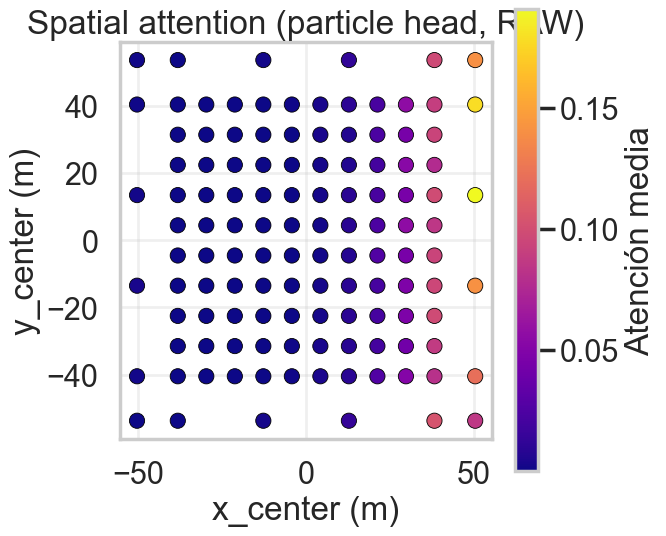

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attn_spatial_simple.png


In [85]:
# --- Mapa espacial sencillo: atención media por detector (RAW, head de partícula) ---
def spatial_attention_map(attn_scores, sequences, valid_lengths, detector_catalog, title, save_path, max_len=120):
    if attn_scores.ndim == 4:
        attn_scores = attn_scores.mean(axis=1)
    pos = detector_catalog.set_index("detector_id")[["x_center", "y_center"]]
    acc = {}
    cnt = {}
    for mat, seq, L in zip(attn_scores, sequences, valid_lengths):
        L = int(min(L, mat.shape[0], seq.shape[0], max_len))
        if L <= 0:
            continue
        attn_recv = mat[:L, :L].mean(axis=0)
        for t in range(L):
            det = int(seq[t, FEATURE_IDX["detector_id"]])
            if det in pos.index and np.isfinite(attn_recv[t]):
                acc[det] = acc.get(det, 0.0) + float(attn_recv[t])
                cnt[det] = cnt.get(det, 0) + 1
    if not acc:
        print("Sin datos para mapa espacial.")
        return
    imp = {d: acc[d]/cnt[d] for d in acc}
    df = pd.DataFrame({"detector_id": list(imp.keys()), "attention": list(imp.values())}).merge(pos, left_on="detector_id", right_index=True)
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(df.x_center, df.y_center, c=df.attention, s=120, cmap="plasma", edgecolor="k", linewidth=0.6)
    plt.colorbar(sc, label="Atención media")
    plt.xlabel("x_center (m)"); plt.ylabel("y_center (m)")
    plt.title(title)
    plt.gca().set_aspect("equal")
    plt.grid(alpha=0.3)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"✓ Guardado: {save_path}")

spatial_attention_map(attn_angle_raw_scores, X_sample, valid_lengths_raw, detector_catalog,
                      "Spatial attention (particle head, RAW)", plots_dir / "attn_spatial_simple.png")

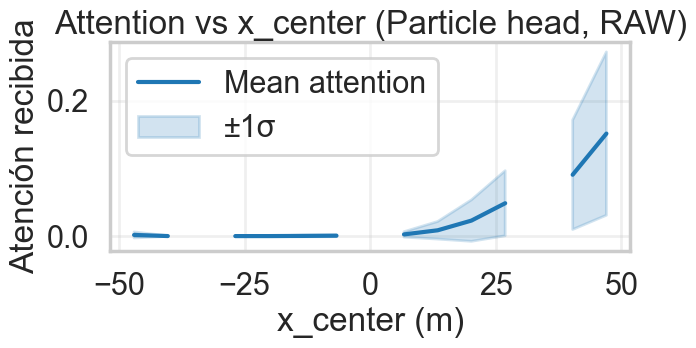

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attn_vs_xcenter_particle.png


In [95]:
# Curva: atención recibida vs x_center (RAW, head de partícula)
def plot_attention_vs_xcenter(attn_scores, sequences, valid_lengths, title, save_path, bins=15, max_len=120):
    # Promedio de heads si vienen en (batch, heads, L, L)
    if attn_scores.ndim == 4:
        attn_scores = attn_scores.mean(axis=1)
    xs, attn_vals = [], []
    for mat, seq, L in zip(attn_scores, sequences, valid_lengths):
        L = int(min(L, mat.shape[0], seq.shape[0], max_len))
        if L <= 0:
            continue
        attn_recv = mat[:L, :L].mean(axis=0)  # atención recibida por key-pos
        x_centers = seq[:L, 4]               # idx 4 = x_center
        mask = np.isfinite(attn_recv) & np.isfinite(x_centers)
        xs.append(x_centers[mask])
        attn_vals.append(attn_recv[mask])
    if not xs:
        print("Sin datos válidos para graficar.")
        return
    xs = np.concatenate(xs)
    attn_vals = np.concatenate(attn_vals)

    # Bineo y promedios
    bin_edges = np.linspace(xs.min(), xs.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    digitized = np.digitize(xs, bin_edges[:-1], right=False)
    mean_attn, std_attn, counts = [], [], []
    for b in range(1, bins + 1):
        m = digitized == b
        if m.any():
            mean_attn.append(attn_vals[m].mean())
            std_attn.append(attn_vals[m].std(ddof=0))
            counts.append(m.sum())
        else:
            mean_attn.append(np.nan)
            std_attn.append(np.nan)
            counts.append(0)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(bin_centers, mean_attn, color="tab:blue", label="Mean attention")
    ax.fill_between(bin_centers,
                    np.array(mean_attn) - np.array(std_attn),
                    np.array(mean_attn) + np.array(std_attn),
                    color="tab:blue", alpha=0.2, label="±1σ")
    ax.set_xlabel("x_center (m)")
    ax.set_ylabel("Atención recibida")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"✓ Guardado: {save_path}")

# Ejecutar para head de partícula (RAW)
plot_attention_vs_xcenter(
    attn_angle_raw_scores,
    X_sample,           # secuencias correspondientes a las atenciones extraídas
    valid_lengths_raw,  # longitudes reales (RAW)
    "Attention vs x_center (Particle head, RAW)",
    plots_dir / "attn_vs_xcenter_particle.png",
    bins=15,
    max_len=120,
)

### Explainability Findings (Quantitative)
- Spatial: central vs peripheral detector attention.
- Temporal: entropy, self vs context attention.
- Correlations with energy/particle count.
- Embedding separability (variance explained).

---

Este documento resume las métricas clave utilizadas para evaluar el rendimiento del modelo en las tres tareas principales: Clasificación (Gamma/Hadrón), Reconstrucción Angular y Estimación de Energía.

---

## 1. Tabla Resumen de Métricas

| Categoría | Métrica | Notación / Fórmula | Interpretación | Valor Objetivo (Benchmark) | Importancia |
|:---|:---|:---|:---|:---|:---|
| **🎯 Clasificación** | **Accuracy** | $\frac{TP + TN}{Total}$ | % Global de predicciones correctas | $85\% - 95\%$ | ⭐⭐⭐ Básica |
| (Gamma/Hadrón) | **Precision** | $\frac{TP}{TP + FP}$ | Pureza de la muestra de gammas | $> 90\%$ | ⭐⭐⭐⭐⭐ **Crítica para Astronomía** |
| | **Recall (Efficiency)** | $\epsilon_\gamma = \frac{TP}{TP + FN}$ | Eficiencia de retención de gammas | $> 80\%$ | ⭐⭐⭐⭐⭐ **Área Efectiva** |
| | **F1-Score** | $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ | Balance armónico | $> 85\%$ | ⭐⭐⭐⭐ Robustez |
| | **AUC-ROC** | $\int TPR \, d(FPR)$ | Capacidad discriminativa global | $0.90 - 0.98$ | ⭐⭐⭐⭐⭐ **Gold Standard** |
| | **Q-Factor** | $Q = \frac{\epsilon_\gamma}{\sqrt{\epsilon_h}}$ | **Figura de Mérito (IACTs)** | $3 - 7$ | ⭐⭐⭐⭐⭐ **Sensibilidad** |
| **📐 Ángulo** | **MAE** | $\langle \lvert \hat{\theta} - \theta \rvert \rangle$ | Error absoluto medio | $1.0^\circ - 3.0^\circ$ | ⭐⭐⭐ Básica |
| (Dirección) | **PSF68** ($\sigma_{68}$) | $P_{68}(\lvert \hat{\theta} - \theta \rvert)$ | **Resolución Angular (Contención 68%)** | $0.5^\circ - 1.5^\circ$ | ⭐⭐⭐⭐⭐ **Estándar en Papers** |
| | **Bias (Zenith)** | $\langle \hat{\theta} - \theta \rangle$ | Sesgo sistemático en cenit | $\pm 0.1^\circ$ | ⭐⭐⭐⭐⭐ **Apuntado** |
| | **Opening Angle** | $\psi = \arccos(\hat{\vec{v}} \cdot \vec{v})$ | Ángulo sólido entre vectores 3D | Distribución Rayleigh | ⭐⭐⭐⭐ Física 3D |
| **⚡ Energía** | **MAE** | $\langle \lvert \hat{E} - E \rvert \rangle$ | Error medio (GeV) | Depende de $E$ | ⭐⭐⭐ Básica |
| (Calorimetría) | **Energy Bias** | $\langle \frac{\hat{E} - E}{E} \rangle$ | **Sesgo Relativo Sistemático** | $<\pm 5\%$ | ⭐⭐⭐⭐⭐ **Escala de Energía** |
| | **Energy Resolution** | $\sigma_{68}(\frac{\hat{E} - E}{E})$ | **Resolución Relativa** | $15\% - 30\%$ | ⭐⭐⭐⭐⭐ **Espectroscopía** |
| | **Migration** | $P(\hat{E}_j \lvert E_i)$ | Matriz de confusión de energía | Diagonal dominante | ⭐⭐⭐⭐ Unfolding |

---

## 🔍 Explicación Detallada de Métricas Clave

### 1. Quality Factor ($Q$-Factor)

Es la métrica fundamental para optimizar cortes de selección en astronomía de rayos gamma (como en MAGIC, CTA o HAWC). Maximiza la señal ($\gamma$) mientras suprime el fondo dominante (hadrones).

$$Q = \frac{\epsilon_\gamma}{\sqrt{\epsilon_h}}$$

Donde:
- $\epsilon_\gamma$: Eficiencia de señal (Recall de Gammas).
- $\epsilon_h$: Eficiencia residual de fondo (Tasa de Falsos Positivos de Hadrones).
- $\sqrt{\epsilon_h}$: Representa la fluctuación estadística del fondo (Poisson).

**Interpretación:**
- Un factor $Q=5$ implica que la sensibilidad del instrumento mejora por un factor de 5 respecto a no usar cortes, reduciendo el tiempo de observación necesario en un factor de 25 ($t \propto 1/Q^2$).

---

### 2. Significancia de Li & Ma ($\sigma_{LiMa}$)

Es el estándar estadístico para reclamar el descubrimiento de una fuente astrofísica. Compara los eventos en la zona de la fuente ($N_{on}$) con una zona de control ($N_{off}$).

$$S_{LiMa} = \sqrt{2 \left( N_{on} \ln \left[ \frac{1+\alpha}{\alpha} \left( \frac{N_{on}}{N_{on} + N_{off}} \right) \right] + N_{off} \ln \left[ (1+\alpha) \left( \frac{N_{off}}{N_{on} + N_{off}} \right) \right] \right)}$$

- $\alpha$: Ratio de exposición entre las regiones ON y OFF ($t_{on}/t_{off}$).
- **Umbral de descubrimiento:** $S > 5\sigma$ (probabilidad de fluctuación aleatoria $< 2.8 \times 10^{-7}$).

---

### 3. Resolución Angular (PSF - Point Spread Function)

En lugar de usar una desviación estándar gaussiana ($\sigma$), en rayos cósmicos se usa el **Radio de Contención del 68%** (PSF68), ya que las distribuciones de error suelen tener colas largas no gaussianas.

- **Definición:** El valor angular $\Psi$ tal que el 68% de los eventos reconstruidos tienen un error menor a $\Psi$.
- **Importancia:** Define la capacidad del telescopio para resolver la morfología de fuentes extensas y reduce la contaminación de fondo en fuentes puntuales.

---

### 4. Métricas de Energía: Bias y Resolución

Debido a que el espectro de rayos cósmicos sigue una ley de potencia ($dN/dE \propto E^{-\gamma}$), pequeños errores sistemáticos pueden distorsionar gravemente el flujo medido.

#### **Energy Bias (Sesgo)**
$$\text{Bias} = \left\langle \frac{E_{pred} - E_{true}}{E_{true}} \right\rangle$$
- **Objetivo:** $\approx 0\%$.
- **Peligro:** Un bias positivo ($+10\%$) desplaza eventos de baja energía (muy abundantes) a bines de alta energía, creando falsas señales o "harder spectra".

#### **Energy Resolution (Resolución)**
$$\frac{\sigma_E}{E} = \frac{1}{2} (\text{Percentil}_{84} - \text{Percentil}_{16}) \quad \text{de la distribución } \frac{\Delta E}{E}$$
- Se usa el rango intercuartil robusto en lugar de la desviación estándar simple para mitigar el efecto de *outliers*.

---

### 5. Matriz de Migración (Migration Matrix)

Visualiza la probabilidad de que un evento con energía verdadera $E_i$ sea reconstruido con energía $E_j$.

**Ejemplo Teórico:**

| $E_{true}$ \ $E_{rec}$ | **300 GeV** | **500 GeV** | **800 GeV** |
|:---:|:---:|:---:|:---:|
| **300 GeV** | **0.85** | 0.12 | 0.03 |
| **500 GeV** | 0.10 | **0.80** | 0.10 |
| **800 GeV** | 0.05 | 0.15 | **0.80** |

- **Diagonal:** Representa la precisión de la reconstrucción.
- **Triángulo Superior:** Eventos "spill-over" (reconstruidos con más energía de la real).
- **Uso:** Esta matriz es esencial para el proceso de *Unfolding* (desconvolución) del espectro de energía final.